In [374]:
import sys
print(sys.version)

3.8.3 | packaged by conda-forge | (default, Jun  1 2020, 17:21:09) 
[Clang 9.0.1 ]


In [375]:
"""
Created on May 1 2021
@author: Neven Caplar
@contact: ncaplar@princeton.edu

These comments are theoretically the only ones you need to read to run the notebook

1. Specify the directory in which you want to run the analysis below (PSF_DIRECTORY)
2. Name and place the data in DATA_FOLDER. The data is avaliable at https://github.com/nevencaplar/PFS_Work_In_Progress/tree/master/CutsForTigerMay2
3. TESTING_FOLDER will be filled during the run with images from the analysis analysis

4. (OPTIONAL)Next cell contains some extensions that I use that make life much easier when using jupyter notebook 
    Without them this notebook becomes reallllly huge and hard to deal with
    These can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

"""
############################################################
# name your directory where you want to have files!
PSF_DIRECTORY='/Users/nevencaplar/Documents/PFS/'
# place cutouts in this folder - name as you wish
DATA_FOLDER=PSF_DIRECTORY+'TigerAnalysis/CutsForTigerMay2/'
############################################################
    

TESTING_FOLDER=PSF_DIRECTORY+'Testing/'
TESTING_PUPIL_IMAGES_FOLDER=TESTING_FOLDER+'Pupil_Images/'
TESTING_WAVEFRONT_IMAGES_FOLDER=TESTING_FOLDER+'Wavefront_Images/'
TESTING_FINAL_IMAGES_FOLDER=TESTING_FOLDER+'Final_Images/'
import os

for i in [PSF_DIRECTORY,DATA_FOLDER,TESTING_PUPIL_IMAGES_FOLDER,TESTING_WAVEFRONT_IMAGES_FOLDER,TESTING_FINAL_IMAGES_FOLDER]:
    if not os.path.exists(i):
        os.makedirs(i)

In [376]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [377]:
# make notebook nice and wide to fill the entire screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [378]:
%load_ext autoreload
%autoreload 2

#import Zernike_Module
#from Zernike_Module import LNP_PFS,LN_PFS_single,create_parInit,downsample_manual_function,Zernike_Analysis,PFSPupilFactory,custom_fftconvolve,stepK,maxK,sky_scale,sky_size,create_x,remove_pupil_parameters_from_all_parameters

import Zernike_Module
import Zernike_Analysis_Module
from Zernike_Module import *
from Residual_1D_module import * 
from Zernike_Analysis_Module import *

# 0.35d or greater

print('Zernike_Module.__version__: '+str(Zernike_Module.__version__))
print('Zernike_Analysis_Module.__version__: '+str(Zernike_Analysis_Module.__version__))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Zernike_Module.__version__: 0.45c
Zernike_Analysis_Module.__version__: 0.26g


In [1233]:
from Zernike_Module_v040a import *
import Zernike_Module_v040a


In [379]:
import galsim
import numpy as np
np.set_printoptions(suppress=True)
np.seterr(divide='ignore', invalid='ignore')
import pandas as pd
import io
import math
import pickle
import glob
import time

#tqdm is not necesarry, it is the monitor evaluation of the 'for' loops
from tqdm import tqdm

# lsst stack
#import lsst.afw
#from lsst.afw.cameraGeom import PupilFactory
#from lsst.afw.geom import Angle, degrees
#from lsst.afw import geom
#from lsst.afw.geom import Point2D

# astropy
import astropy
import astropy.convolution
from astropy.convolution import Gaussian2DKernel

# scipy and skimage
#from scipy.ndimage import gaussian_filter
import scipy.misc
import skimage.transform

#lmfit
import lmfit

#matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 18})
%config InlineBackend.rc = {}
%matplotlib inline
%config IPython.matplotlib.backend = "retina"

from shutil import copy
from scipy.optimize import curve_fit

from astropy.io import fits

def lin_fit_1D(x, a, b):
    return a * x + b

def lin_fit_1DConstant(x, b):
    return  np.full(len(x),b)

def lin_fit_2D(x,y, a, b,c):
    return a * x + b*y+c



print(np.__version__)
print(skimage.__version__)
print(scipy.__version__)
print(pd.__version__)

1.18.5
0.17.2
1.5.0
1.0.5


# Unit test 

In [1234]:
columns=['z4','z5','z6','z7','z8','z9','z10','z11',
          'hscFrac','strutFrac','dxFocal','dyFocal','slitFrac','slitFrac_dy',
          'radiometricEffect','radiometricExponent','x_ilum','y_ilum',
          'x_fiber','y_fiber','effective_radius_illumination',
          'frd_sigma','frd_lorentz_factor','det_vert','slitHolder_frac_dx',
          'grating_lines','scattering_slope','scattering_amplitude',
          'pixel_effect','fiber_r','flux']  

sci_image_unit=np.ones((20,20))
var_image_unit=np.ones((20,20))
#array([     0.85110826,      0.73047372,     -0.31672873,     -0.00539844, -0.32264156,     -0.04922217,     -0.49565709,      0.18057418,
#            0.79993531,      0.10032969,      0.08769052,      0.25372595,          0.06064503,      0.21049747,   
#           0.45840763,      2.05047984,  0.30893478,     -0.13166649, 
#           -0.06752367,     -0.13093007,            0.89197452, 
#           0.10757197,   0.60969064,      1.06409559,   0.14192374, 
#           109336.61223169,   2.41053199,      0.00379578,
#            0.4673993 ,      1.88555321,      0.99733826])
allparameters_proposal=np.array([7.1,1.09,0.02,-0.1,0.0,0.1,0.02,0.2,
                                 0.7,0.1,0.3,0.0,0.07,0.0,
                                 0.17,0.67,1,1,
                                 0.0,-0.0,0.80,
                                 0.01,0.51,1.06,0.28,
                                 50000,2.5,0.027,
                                 0.37,1.85,1.0])
print('version of the code is: '+str(Zernike_Module.__version__))
model = LN_PFS_single(sci_image_unit,var_image_unit,dithering=1,save=1,verbosity=0,npix=1536)   

res=model(allparameters_proposal,return_Image=True)


print(res[0])

version of the code is: 0.45c
-367.5754132818689


/Users/nevencaplar/anaconda2/envs/idp2_pyfftw/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [381]:
pupililluminated=np.load(TESTING_PUPIL_IMAGES_FOLDER+'pupil.illuminated.npy')
ilum=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum.npy')
radiometricEffectArray=np.load(TESTING_PUPIL_IMAGES_FOLDER+'radiometricEffectArray.npy')
optPsf=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf.npy')
ilum_radiometric=np.load(TESTING_PUPIL_IMAGES_FOLDER+'ilum_radiometric.npy')
wf_full=np.load(TESTING_WAVEFRONT_IMAGES_FOLDER+'wf_full.npy') 

optPsf_cut_fiber_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved.npy')
optPsf_cut_pixel_response_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_pixel_response_convolved.npy')
optPsf_cut_grating_convolved=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_grating_convolved.npy')
optPsf_cut_fiber_convolved_downsampled=np.load(TESTING_FINAL_IMAGES_FOLDER+'optPsf_cut_fiber_convolved_downsampled.npy')



res_iapetus=res[1]

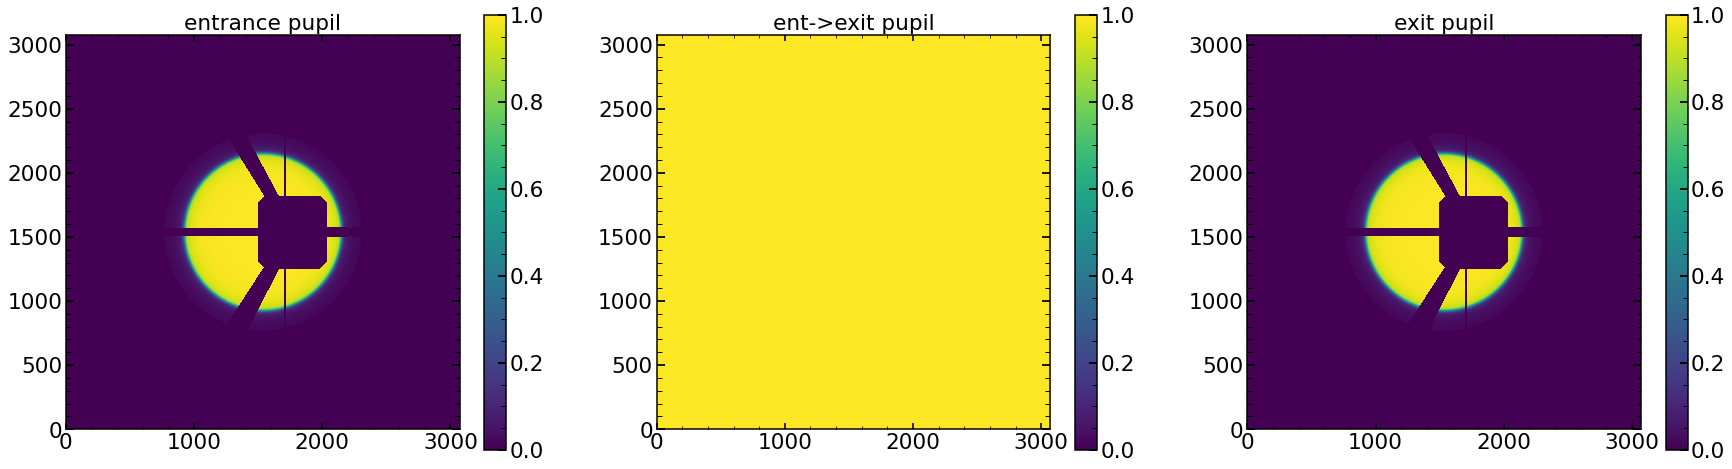

In [382]:
plt.figure(figsize=(30,8))
plt.subplot(131)
plt.imshow(ilum,origin='lower',vmax=1,vmin=0)
plt.title('entrance pupil')
plt.colorbar()
plt.subplot(132)
plt.title('ent->exit pupil')
plt.imshow(radiometricEffectArray,origin='lower',vmax=1,vmin=0)

plt.colorbar()
plt.subplot(133)
plt.title('exit pupil')
plt.imshow(ilum_radiometric,origin='lower',vmax=1,vmin=0)
plt.colorbar()

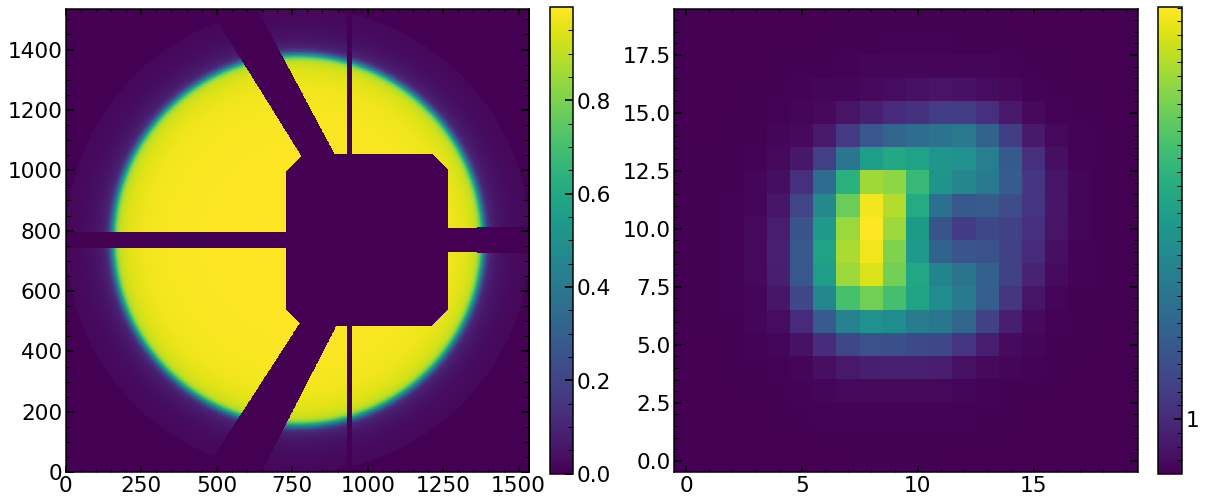

In [383]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(pupililluminated,origin='lower')
cbar=plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(122)
plt.imshow(res_iapetus,origin='lower')
cbar=plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_ticks([10**-2,1,10,10**2,10**3,10**4,10**5])

# Apr 29

In [102]:
import glob

finalAr=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalAr_flip.pkl",allow_pickle=True)
finalNe=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalNe_flip.pkl",allow_pickle=True)
finalKr=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalKr_flip.pkl",allow_pickle=True)

def remove(string): 
    return string.replace(" ", "")

## scripts 

## which are avaliable 

In [195]:
date='May0721'

ResultsFromTiger_FOLDER='/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/'


Emcee3_HgAr=glob.glob(ResultsFromTiger_FOLDER+date+'/chain'+date+'_Single_P_*HgArSwarm1.npy', recursive=True)

Emcee3_Ar=glob.glob(ResultsFromTiger_FOLDER+date+'/chain'+date+'_Single_P_*ArSwarm1.npy', recursive=True)
Emcee3_Ne=glob.glob(ResultsFromTiger_FOLDER+date+'/chain'+date+'_Single_P_*NeSwarm1.npy', recursive=True)
Emcee3_Kr=glob.glob(ResultsFromTiger_FOLDER+date+'/chain'+date+'_Single_P_*KrSwarm1.npy', recursive=True)

In [196]:
eps_value=6

analyzed_Neon_images=[]
for i in range(len(Emcee3_Ne)):
    single_string=Emcee3_Ne[i][len(ResultsFromTiger_FOLDER)+30:len(Emcee3_Ne[i])-13]
    # only select images with a given eps
    if Emcee3_Ne[i][Emcee3_Ne[i].find('Ne')-1:Emcee3_Ne[i].find('Ne')]==str(eps_value):
        analyzed_Neon_images.append([int(single_string[:5]),int(single_string[5:]),'Ne'])
   
analyzed_Neon_images=np.array(analyzed_Neon_images)
###########
analyzed_Ar_images=[]
for i in range(len(Emcee3_Ar)):
    single_string=Emcee3_Ar[i][len(ResultsFromTiger_FOLDER)+30:len(Emcee3_Ar[i])-13]
    # only select images with a given eps
    if Emcee3_Ar[i][Emcee3_Ar[i].find('Ar')-1:Emcee3_Ar[i].find('Ar')]==str(eps_value):
        analyzed_Ar_images.append([int(single_string[:5]),int(single_string[5:]),'Ar'])
 

analyzed_Ar_images=np.array(analyzed_Ar_images)
###########
analyzed_Kr_images=[]
for i in range(len(Emcee3_Kr)):
    single_string=Emcee3_Kr[i][len(ResultsFromTiger_FOLDER)+30:len(Emcee3_Kr[i])-13]
    # only select images with a given eps
    if Emcee3_Kr[i][Emcee3_Kr[i].find('Kr')-1:Emcee3_Kr[i].find('Kr')]==str(eps_value):
        analyzed_Kr_images.append([int(single_string[:5]),int(single_string[5:]),'Kr'])
    
analyzed_Kr_images=np.array(analyzed_Kr_images)

In [197]:
print(analyzed_Ar_images)
print(analyzed_Neon_images)
print(analyzed_Kr_images)

[['34437' '11' 'Ar']]
[]
[]


In [198]:
if len(analyzed_Ar_images)>0:
    arranged_by_defocus_Ar=analyzed_Ar_images[analyzed_Ar_images[:,0].argsort()]
    arranged_by_spot_number_Ar=analyzed_Ar_images[analyzed_Ar_images[:,1].argsort()]
else:
    arranged_by_defocus_Ar=[]
    arranged_by_spot_number_Ar=[]

if len(analyzed_Neon_images)>0:
    arranged_by_defocus_Ne=analyzed_Neon_images[analyzed_Neon_images[:,0].argsort()]
    arranged_by_spot_number_Ne=analyzed_Neon_images[analyzed_Neon_images[:,1].argsort()]
else:
    arranged_by_defocus_Ne=[]
    arranged_by_spot_number_Ne=[]

if len(analyzed_Kr_images)>0:
    arranged_by_defocus_Kr=analyzed_Kr_images[analyzed_Kr_images[:,0].argsort()]
    arranged_by_spot_number_Kr=analyzed_Kr_images[analyzed_Kr_images[:,1].argsort()]
else:
    arranged_by_defocus_Kr=[]
    arranged_by_spot_number_Kr=[]
    
print('analyzed_Ar_images:'+str(len(analyzed_Ar_images))+' / '+'analyzed_Ne_images:'+str(len(analyzed_Neon_images))+' / '+'analyzed_Kr_images:'+str(len(analyzed_Kr_images)))

analyzed_Ar_images:1 / analyzed_Ne_images:0 / analyzed_Kr_images:0


## single image analysis 

In [1012]:
date='May0721'
#obs=34313
#obs_int=int(obs)
single_number='11'
image_index=int(single_number)
eps=6
arc='Ar'
dataset=6

if arc=='Ar':
    obs=34341+96
    finalArc=finalAr
if arc=='Ne':
    obs=34217+96 
    finalArc=finalNe
if arc=='Kr':
    obs=34561+96
    finalArc=finalKr



list_of_defocuses_input_short=['m4','p4']
list_of_defocuses_input_long=['m4','m35','m3','m05','0','p05','p3','p35','p4']

finalArc.loc[int(single_number)]

fiber                  650
xc                      59
yc                    4044
wavelength        966.0642
close                    1
lamp                    Ar
xc_effective            59
second_offset            0
second_ratio             0
second2_offset           0
second2_ratio            0
Name: 11, dtype: object

STAMPS_FOLDER: /Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/
labelInput: m4
self.single_number: 11
list_of_defocuses: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
list_of_obs: [34341, 34347, 34353, 34383, 34389, 34395, 34425, 34431, 34437]
<_io.BufferedReader name='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalHgAr_Feb2020'>
analyzing label: 34341
double_sources_positions_ratios for this spot is: [0 0]


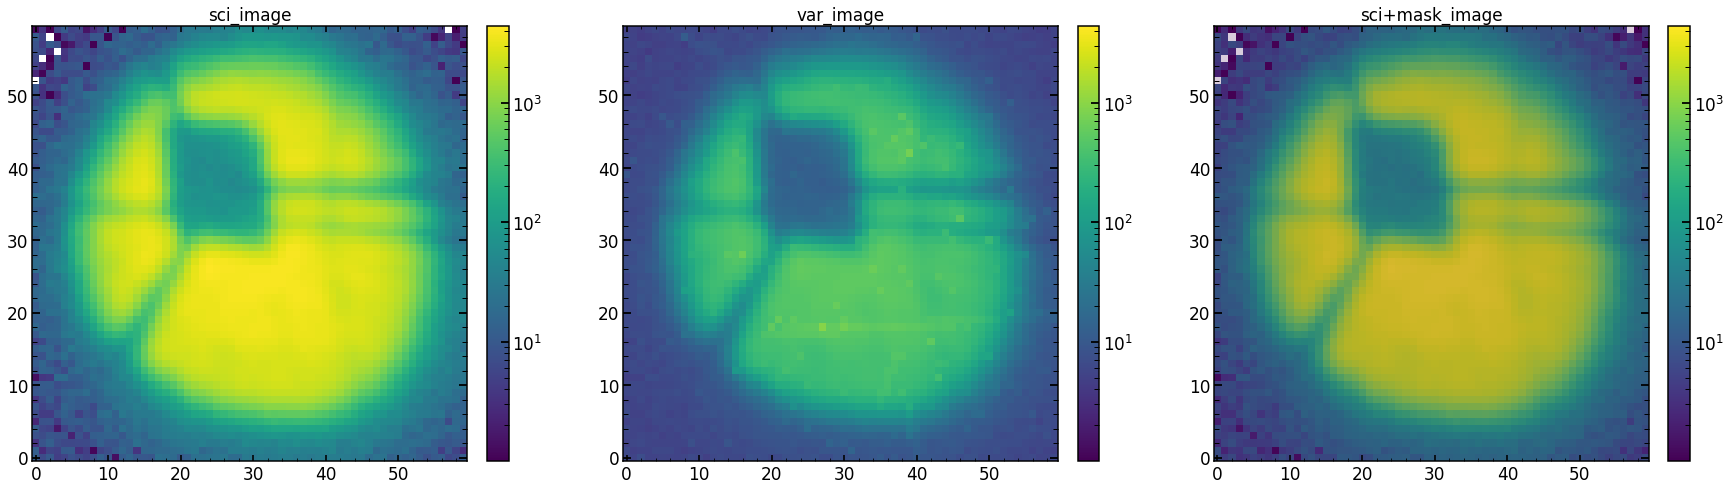

In [1013]:
single_analysis=Zernike_Analysis(date=date,obs='m4',single_number=single_number,eps=eps,arc=arc,dataset=dataset,multi_var=True,\
                                 list_of_defocuses=list_of_defocuses_input_long)
single_analysis.create_basic_data_image()

In [1014]:
double_sources,double_sources_positions_ratios=single_analysis.return_double_sources()
list_of_sci_images,list_of_var_images,list_of_mask_images=single_analysis.return_lists_of_images()
index_of_single_image=single_analysis.return_index_of_single_image_in_list_of_images()
columns,columns22,columns22_analysis=single_analysis.return_columns()


chain0_swarm_1,likechain0_swarm_1=single_analysis.create_chains_swarm_1()
#chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains_Emcee_2()
len_of_chains=single_analysis.len_of_chains()

minchain_parametrization,like_min=single_analysis.create_likelihood()

Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/May0721/chainMay0721_Single_P_34437116ArSwarm1.npy
Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/May0721/chainMay0721_Single_P_34437116ArSwarm1.npy
(41, 480, 129)
Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/May0721/chainMay0721_Single_P_34437116ArSwarm1.npy
(41, 480, 129)
minimal likelihood is: 5.4417069223192005
average chi2 reduced is: -4.754237997621594


### chain analysis 

In [244]:
gbest_filename='/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/'+date+'/chain'+date+'_Single_P_'+str(obs)+str(single_number)+str(eps)+arc+'res_gbests_position.npy'
gbests_positions=np.load(gbest_filename)
print(gbest_filename)
print(gbests_positions.shape)
gbests_positions[-1]

/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/May0721/chainMay0721_Single_P_34437116Arres_gbests_position.npy
(41, 129)


array([   -8.02446599,     0.165249  ,     0.475851  ,    -0.88646635,
           0.21787469,    -0.51657453,    -0.01511797,    -0.31952256,
          -0.07062415,     0.50821633,     0.0184801 ,    -0.42741742,
          -0.02245498,    -0.58090496,    -0.06246074,     0.58554726,
          -0.00324697,     0.03878112,    -0.00227177,     0.22957221,
           0.02556372,    -0.04936574,     0.00142354,     0.03292757,
           0.0064468 ,     0.0588602 ,    -0.01383312,     0.05106129,
           0.0025352 ,     0.02756402,    -0.00080047,    -0.03201344,
           0.00306351,    -0.03294923,     0.0075565 ,     0.02522595,
          -0.02024496,     0.04498579,     0.6982929 ,     0.10099376,
          -0.22868679,     0.27114778,     0.06266987,     0.10090548,
           0.2078081 ,     0.31853494,     0.31105295,     1.28564277,
          -0.0509813 ,    -0.0183548 ,     0.87879873,     0.03103068,
           0.7212447 ,     1.04674646,     0.57226047, 30096.76438941,
      

Text(0, 0.5, 'par_1')

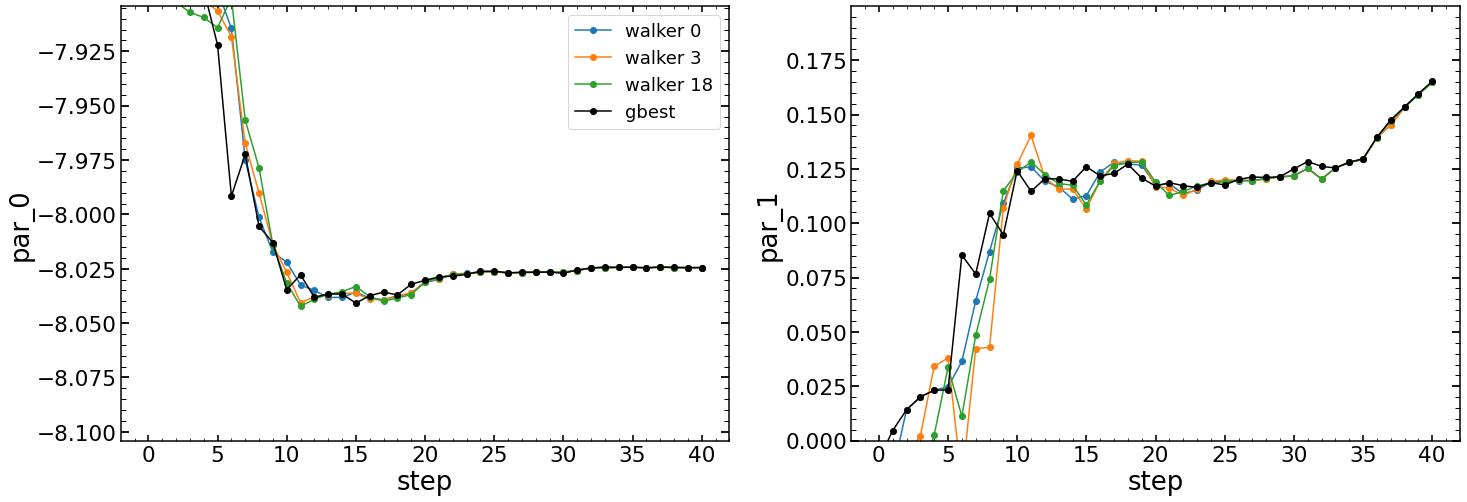

In [245]:
# wavefront paramter
plt.figure(figsize=(24,8))
i=0*2
plt.subplot(121)
# two different walkers, parameter 0
plt.plot(chain0_swarm_1[:,0][:,i],label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,3][:,i],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,18][:,i],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i],label='gbest',color='black',marker='o')
plt.xlabel('step')
plt.ylabel('par_'+str((i)))
mean_one_walker=np.mean(chain0_swarm_1[:,18][:,i])
plt.ylim(mean_one_walker-0.1,mean_one_walker+0.1)
plt.legend()

plt.subplot(122)
#  paramter 2 (z5)

mean_one_what=np.mean(chain0_swarm_1[:,:,i+1][:,2])
plt.plot(chain0_swarm_1[:,:,i+1][:,0],marker='o')
plt.plot(chain0_swarm_1[:,:,i+1][:,3],marker='o')
plt.plot(chain0_swarm_1[:,:,i+1][:,18],marker='o')
plt.plot(gbests_positions[:,i+1],label='gbest',color='black',marker='o')
plt.ylim(mean_one_what-0.1,mean_one_what+0.1)
plt.xlabel('step')
plt.ylabel('par_'+str((i+1)))

Text(0.5, 1.0, 'par_46 / wide_43')

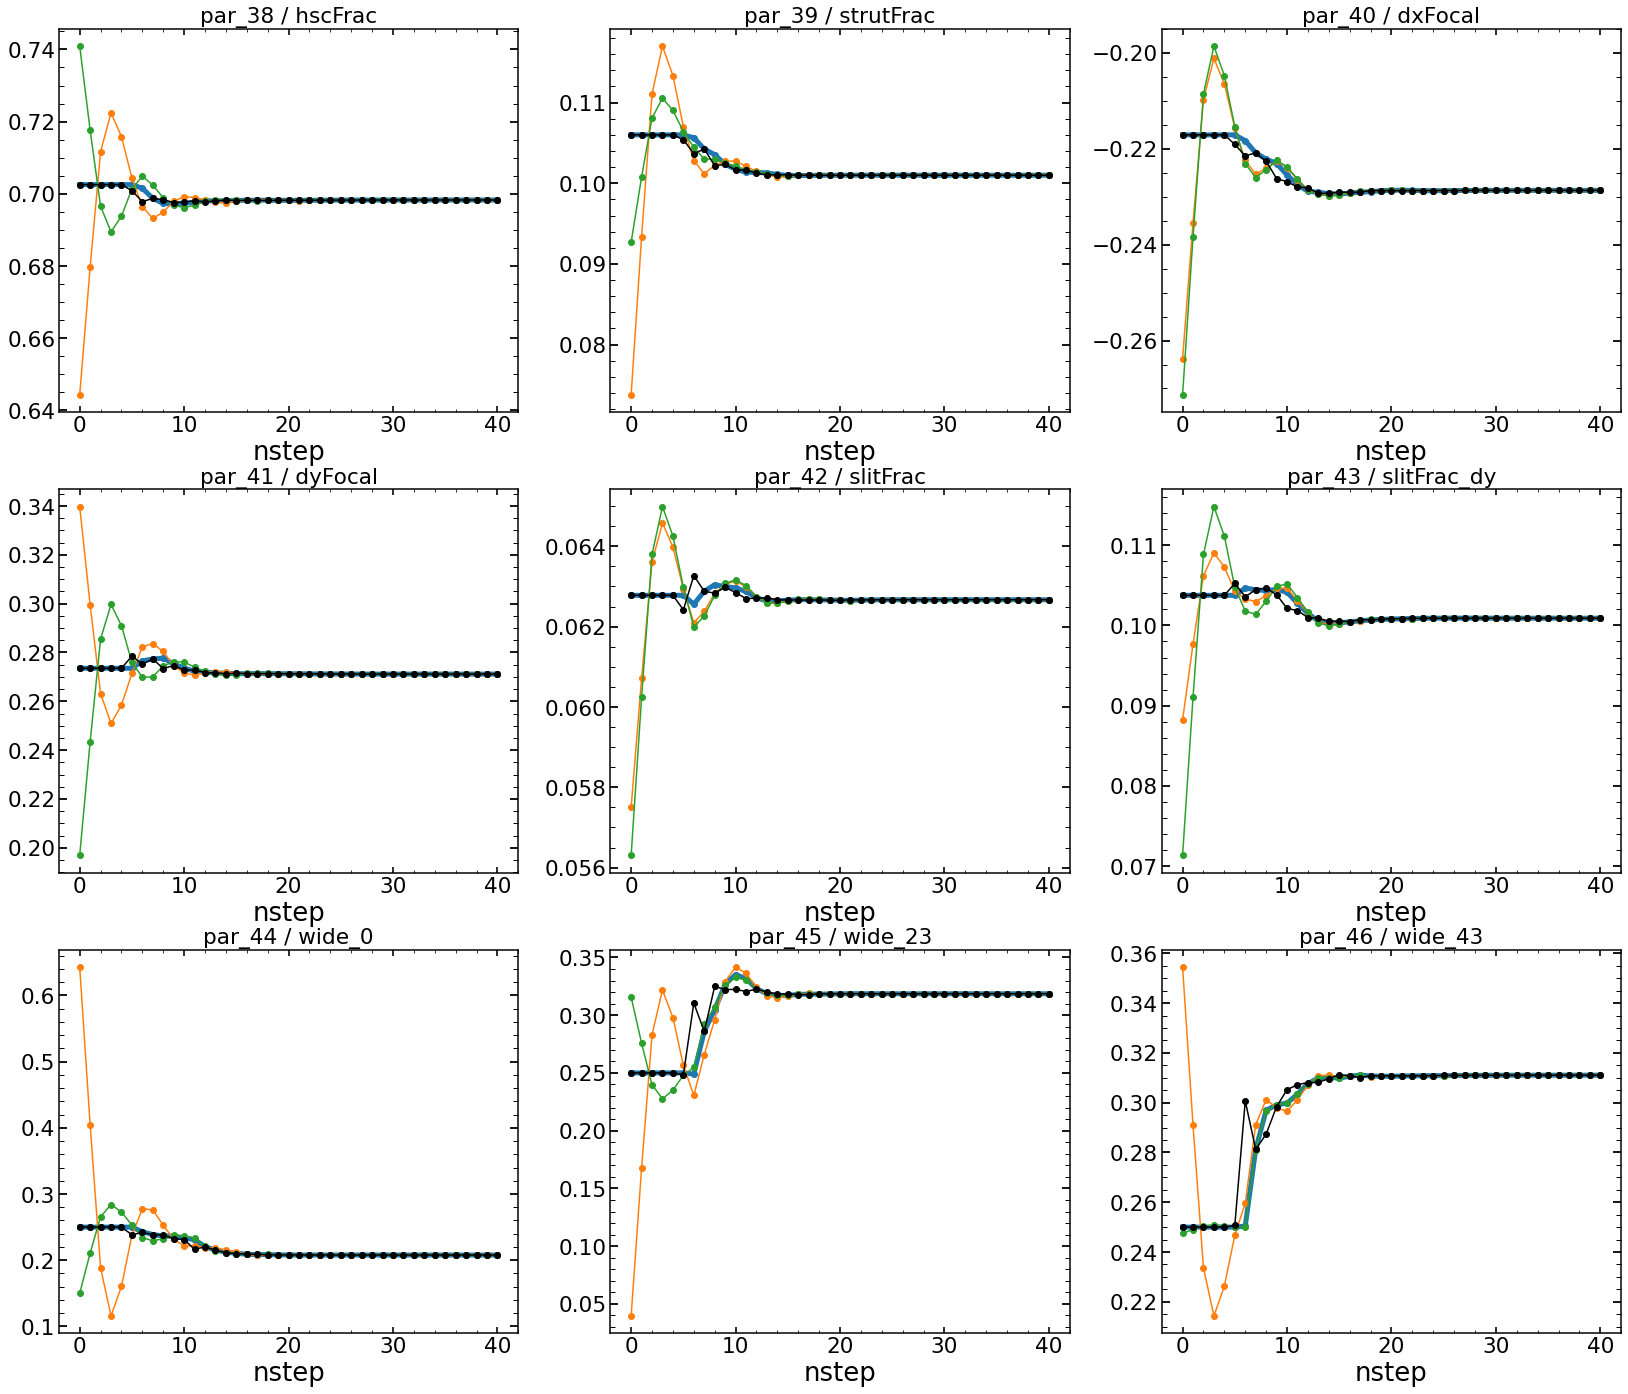

In [246]:
# pupil paramters
plt.figure(figsize=(28,24))
i=19*2
plt.subplot(331)
#plt.plot(chain0_swarm_1[:,:,i][:,2])
plt.plot(chain0_swarm_1[:,0][:,i],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,3][:,i],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,18][:,i],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i))+' / '+columns22[19])

plt.subplot(332)
plt.plot(chain0_swarm_1[:,:,i+1][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+1][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+1][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+1],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+1))+' / '+columns22[20])

plt.subplot(333)
plt.plot(chain0_swarm_1[:,:,i+2][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+2][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+2][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+2],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+2))+' / '+columns22[21])



plt.subplot(334)
#plt.plot(chain0_swarm_1[:,:,i][:,2])
plt.plot(chain0_swarm_1[:,0][:,i+3],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,3][:,i+3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,18][:,i+3],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+3],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+3))+' / '+columns22[19+3])

plt.subplot(335)
plt.plot(chain0_swarm_1[:,:,i+4][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+4][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+4][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+4],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+4))+' / '+columns22[19+4])

plt.subplot(336)
plt.plot(chain0_swarm_1[:,:,i+5][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+5][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+5][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+5],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+5))+' / '+columns22[19+5])


plt.subplot(337)
#plt.plot(chain0_swarm_1[:,:,i][:,2])
plt.plot(chain0_swarm_1[:,0][:,i+6],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,3][:,i+6],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,18][:,i+6],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+6],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+6))+' / '+columns22[19+6])

plt.subplot(338)
plt.plot(chain0_swarm_1[:,:,i+7][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+7][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+7][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+7],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+7))+' / '+columns22[19+7])

plt.subplot(339)
plt.plot(chain0_swarm_1[:,:,i+8][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+8][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+8][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+8],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+8))+' / '+columns22[19+8])

Text(0.5, 1.0, 'par_58 / pixel_effect')

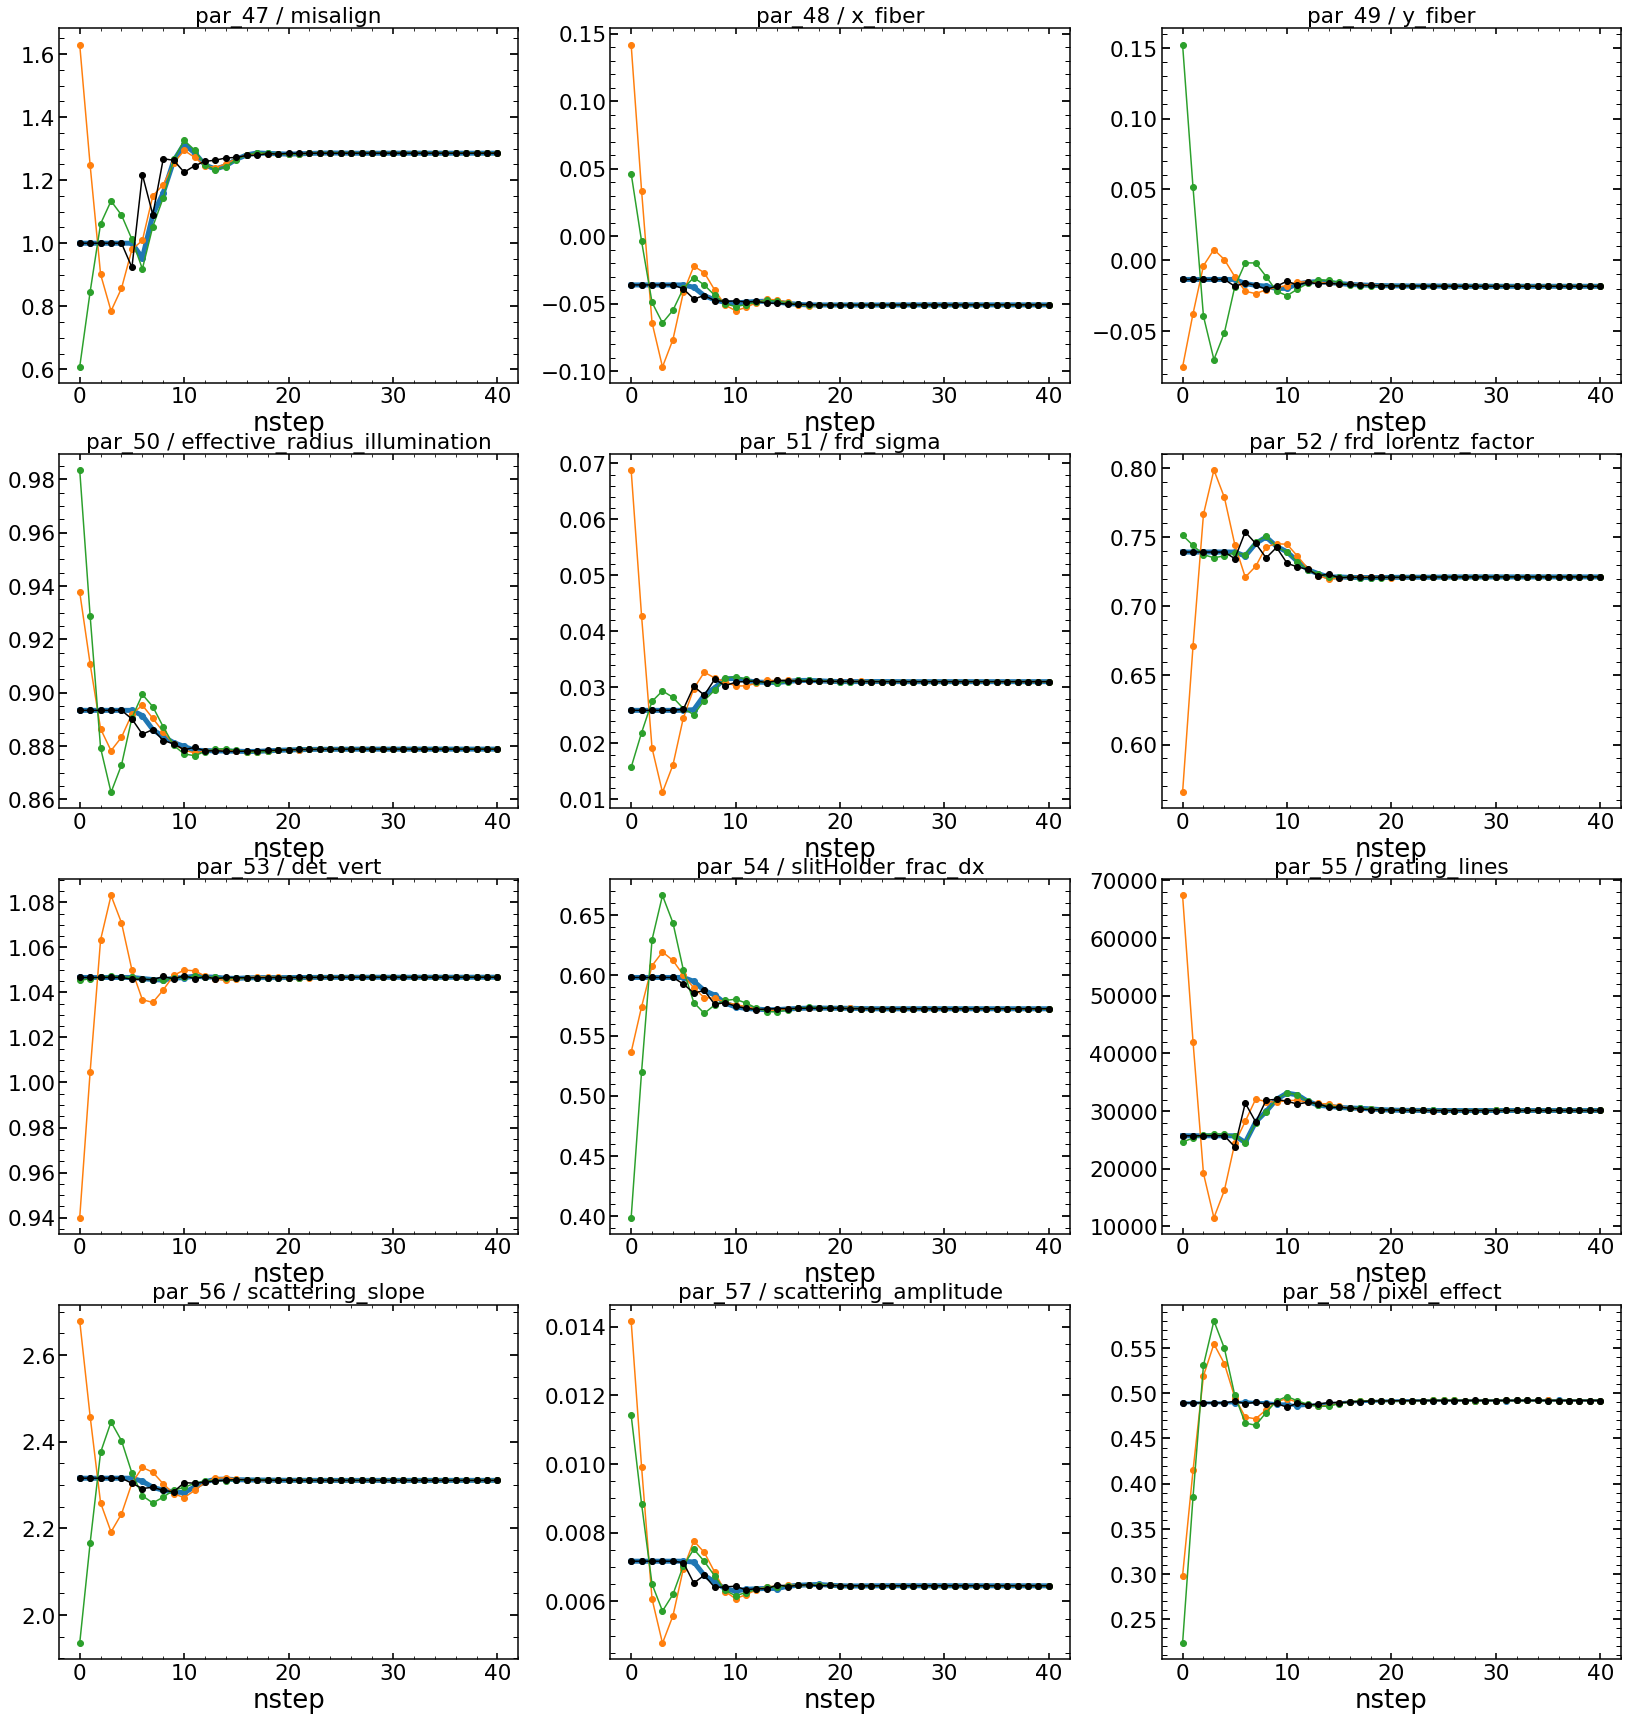

In [247]:
# pupil paramters
plt.figure(figsize=(28,30))
i=19*2
plt.subplot(431)
#plt.plot(chain0_swarm_1[:,:,i][:,2])
plt.plot(chain0_swarm_1[:,0][:,i+9],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,3][:,i+9],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,18][:,i+9],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+9],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+9))+' / '+columns22[19+9])

plt.subplot(432)
plt.plot(chain0_swarm_1[:,:,i+10][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+10][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+10][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+10],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+10))+' / '+columns22[19+10])

plt.subplot(433)
plt.plot(chain0_swarm_1[:,:,i+11][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+11][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+11][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+11],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+11))+' / '+columns22[19+11])



plt.subplot(434)
#plt.plot(chain0_swarm_1[:,:,i][:,2])
plt.plot(chain0_swarm_1[:,0][:,i+12],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,3][:,i+12],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,18][:,i+12],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+12],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+12))+' / '+columns22[19+12])

plt.subplot(435)
plt.plot(chain0_swarm_1[:,:,i+13][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+13][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+13][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+13],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+13))+' / '+columns22[19+13])

plt.subplot(436)
plt.plot(chain0_swarm_1[:,:,i+14][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+14][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+14][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+14],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+14))+' / '+columns22[19+14])


plt.subplot(437)
#plt.plot(chain0_swarm_1[:,:,i][:,2])
plt.plot(chain0_swarm_1[:,0][:,i+15],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,3][:,i+15],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,18][:,i+15],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+15],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+15))+' / '+columns22[19+15])

plt.subplot(438)
plt.plot(chain0_swarm_1[:,:,i+16][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+16][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+16][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+16],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+16))+' / '+columns22[19+16])

plt.subplot(439)
plt.plot(chain0_swarm_1[:,:,i+17][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+17][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+17][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+17],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+17))+' / '+columns22[19+17])


plt.subplot(4,3,10)
#plt.plot(chain0_swarm_1[:,:,i][:,2])
plt.plot(chain0_swarm_1[:,0][:,i+18],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,3][:,i+18],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,18][:,i+18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+18],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+18))+' / '+columns22[19+18])

plt.subplot(4,3,11)
plt.plot(chain0_swarm_1[:,:,i+19][:,0],lw=5,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+19][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+19][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+19],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+19))+' / '+columns22[19+19])

plt.subplot(4,3,12)
plt.plot(chain0_swarm_1[:,:,i+20][:,0],lw=3,label='walker 0',marker='o')
plt.plot(chain0_swarm_1[:,:,i+20][:,3],label='walker 3',marker='o')
plt.plot(chain0_swarm_1[:,:,i+20][:,18],label='walker 18',marker='o')
plt.plot(gbests_positions[:,i+20],label='gbest',color='black',marker='o')
plt.xlabel('nstep')
plt.title('par_'+str((i+20))+' / '+columns22[19+20])

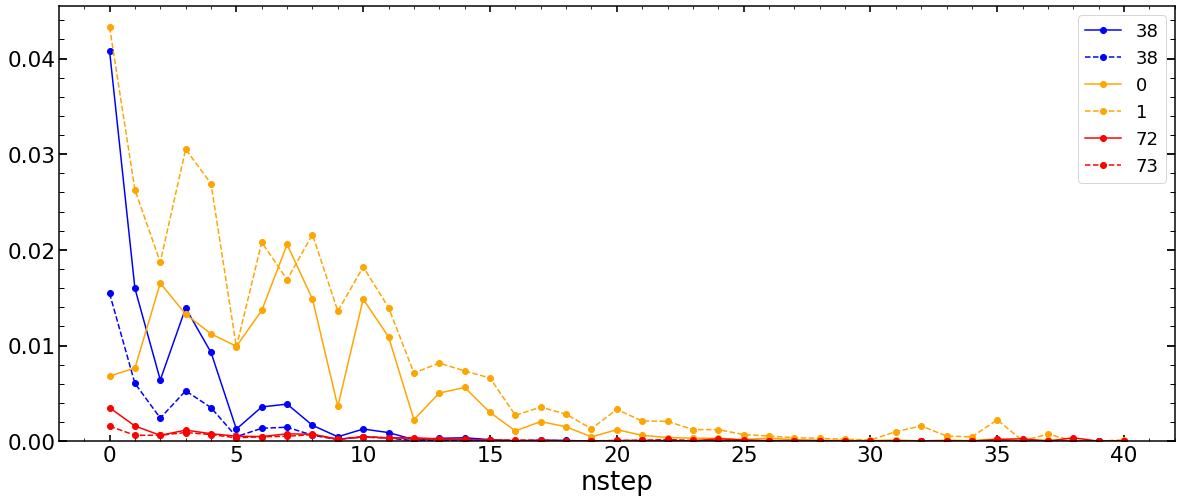

In [248]:
list_of_std_1=[]
i1=19*2+0
for j in range(len(chain0_swarm_1)):
    list_of_std_1.append(np.std(chain0_swarm_1[:,:,i1][j]))
    
list_of_std_6=[]
i6=19*2+1
for j in range(len(chain0_swarm_1)):
    list_of_std_6.append(np.std(chain0_swarm_1[:,:,i6][j]))
    
    
list_of_std_2=[]
i2=0
for j in range(len(chain0_swarm_1)):
    list_of_std_2.append(np.std(chain0_swarm_1[:,:,i2][j]))
    
list_of_std_3=[]
i3=1
for j in range(len(chain0_swarm_1)):
    list_of_std_3.append(np.std(chain0_swarm_1[:,:,i3][j]))
    
    
    
list_of_std_4=[]
i4=72
for j in range(len(chain0_swarm_1)):
    list_of_std_4.append(np.std(chain0_swarm_1[:,:,i4][j]))
    
list_of_std_5=[]
i5=73
for j in range(len(chain0_swarm_1)):
    list_of_std_5.append(np.std(chain0_swarm_1[:,:,i5][j]))


plt.figure(figsize=(20,8))
plt.plot(list_of_std_1,marker='o',label=str(i1),color='blue')
plt.plot(list_of_std_6,marker='o',label=str(i1),ls='--',color='blue')
plt.plot(list_of_std_2,marker='o',label=str(i2),color='orange')
plt.plot(list_of_std_3,marker='o',label=str(i3),ls='--',color='orange')


plt.plot(list_of_std_4,marker='o',label=str(i4),color='red')
plt.plot(list_of_std_5,marker='o',label=str(i5),ls='--',color='red')

plt.ylim(0)
plt.xlabel('nstep')


plt.legend()

(0.0959904180667274, 0.10599709304570504)

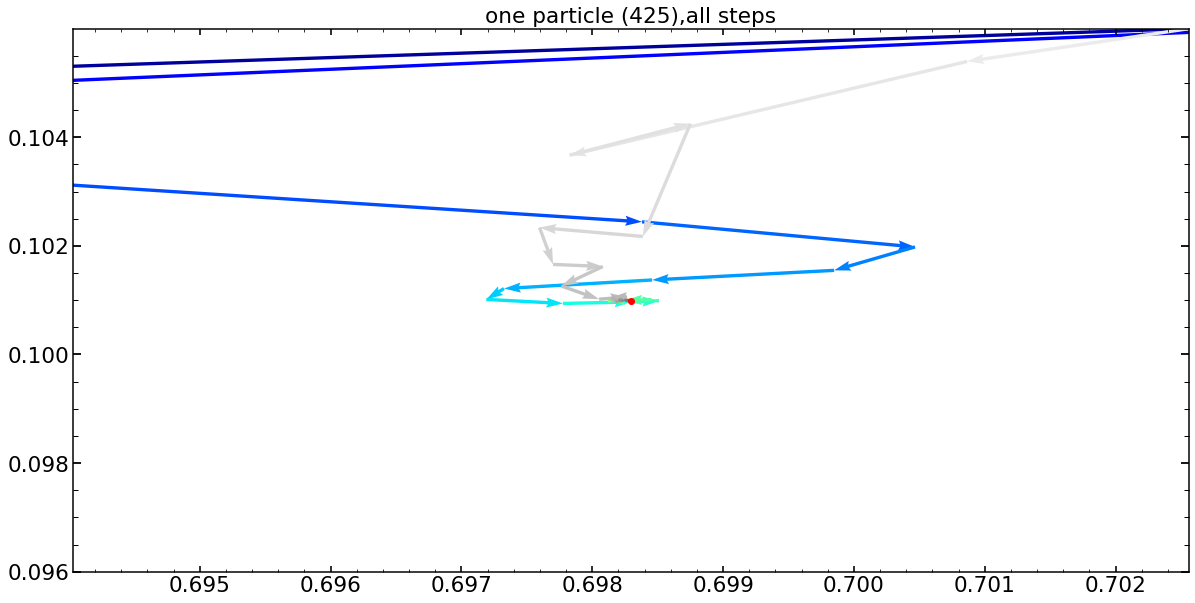

In [279]:
nsteps=chain0_swarm_1.shape[0]


j=0
n_particle=425
list_of_single_particle_par_movements=[]
list_of_gbest_particle_movements=[]
for j in range(len(chain0_swarm_1)):
    step0_test_1=chain0_swarm_1[:,:,i1][:,n_particle][j]
    step0_test_6=chain0_swarm_1[:,:,i6][:,n_particle][j]
    
    
    list_of_single_particle_par_movements.append([step0_test_1,step0_test_6])
    list_of_gbest_particle_movements.append([gbests_positions[:,i1][j],gbests_positions[:,i6][j]])
    
array_of_single_particle_par_movements=np.array(list_of_single_particle_par_movements)   
array_of_gbest_particle_movements=np.array(list_of_gbest_particle_movements)
    
step32_dif_1=np.ediff1d(array_of_single_particle_par_movements[:,0])
step32_dif_6=np.ediff1d(array_of_single_particle_par_movements[:,1])

step32_dif_1_best=np.ediff1d(array_of_gbest_particle_movements[:,0])
step32_dif_6_best=np.ediff1d(array_of_gbest_particle_movements[:,1])


X=array_of_single_particle_par_movements[:,0][0:(nsteps-1)]
Y=array_of_single_particle_par_movements[:,1][0:(nsteps-1)]
U=step32_dif_1[0:(nsteps-1)]
V=step32_dif_6[0:(nsteps-1)]

X_best=array_of_gbest_particle_movements[:,0][0:(nsteps-1)]
Y_best=array_of_gbest_particle_movements[:,1][0:(nsteps-1)]
U_best=step32_dif_1_best[0:(nsteps-1)]
V_best=step32_dif_6_best[0:(nsteps-1)]

cmap = matplotlib.cm.get_cmap('jet')
list_of_colors=[]
for i in range((nsteps-1)):
    list_of_colors.append(cmap(i/(nsteps-1)))

cmap = matplotlib.cm.get_cmap('binary')
list_of_colors_best=[]
for i in range((nsteps-1)):
    list_of_colors_best.append(cmap(i/50))

plt.figure(figsize=(20,10))
plt.title('one particle ('+str(n_particle)+'),all steps')

Q = plt.quiver(X, Y, U, V, angles='xy', scale_units='xy', scale=1,width=0.003,color=list_of_colors)
#Q = plt.quiver(X_best, Y_best, U_best, V_best, angles='xy', scale_units='xy', scale=1,width=0.003,color=list_of_colors,ls=':')
Q = plt.quiver(X_best, Y_best, U_best, V_best, angles='xy', scale_units='xy', scale=1,width=0.003,color=list_of_colors_best,ls='--')
plt.scatter(X_best[-1],Y_best[-1],color='red')

delta_X=np.abs(X_best[0]-X_best[-1])
delta_Y=np.abs(Y_best[0]-Y_best[-1])

plt.xlim(X_best[-1]-delta_X,X_best[-1]+delta_X)
plt.ylim(Y_best[-1]-delta_Y,Y_best[-1]+delta_Y)

In [276]:
chain0_swarm_1[:,:,i1][0]

0.6443081920306089

In [278]:
np.where(chain0_swarm_1[:,:,i1][0]==np.min(chain0_swarm_1[:,:,i1][0]))

(array([425]),)

(0.08598374308774975, 0.11600376802468268)

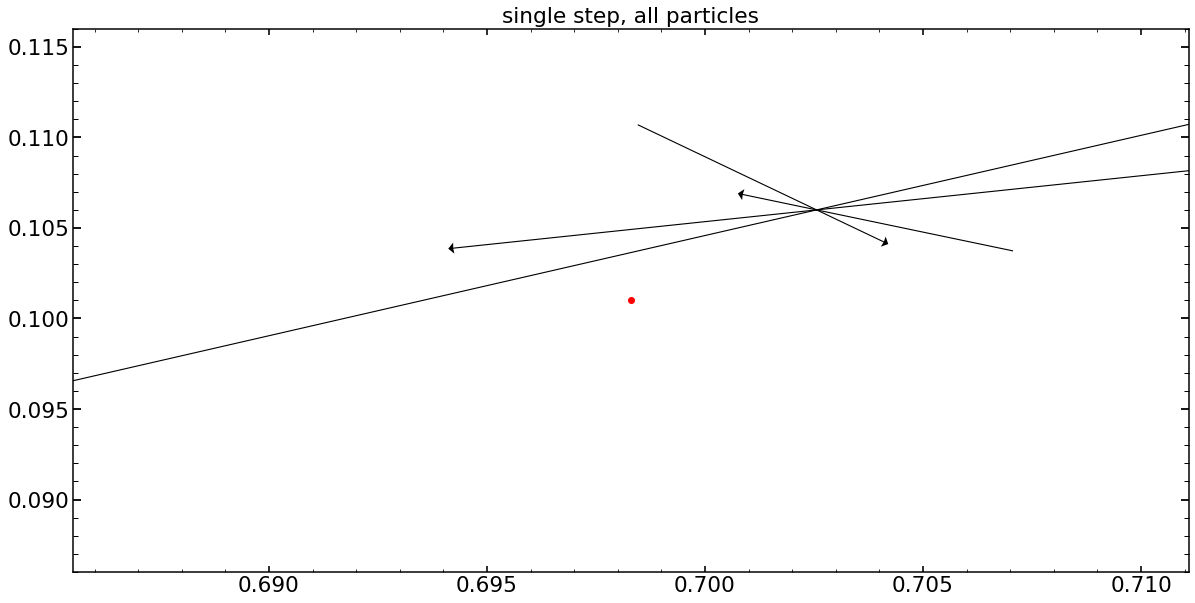

In [280]:
j=0
step0_test_1=chain0_swarm_1[:,:,i1][j]
step0_test_6=chain0_swarm_1[:,:,i6][j]
j=1
step1_test_1=chain0_swarm_1[:,:,i1][j]
step1_test_6=chain0_swarm_1[:,:,i6][j]
j=2
step2_test_1=chain0_swarm_1[:,:,i1][j]
step2_test_6=chain0_swarm_1[:,:,i6][j]
j=3
#step3_test_1=chain0_swarm_1[:,:,i1][j]
#step3_test_6=chain0_swarm_1[:,:,i6][j]

step10_dif_1=step1_test_1-step0_test_1
step10_dif_6=step1_test_6-step0_test_6

step21_dif_1=step2_test_1-step1_test_1
step21_dif_6=step2_test_6-step1_test_6

#step32_dif_1=step3_test_1-step2_test_1
#step32_dif_6=step3_test_6-step2_test_6

X=step1_test_1
Y=step1_test_6
U=step21_dif_1
V=step21_dif_6

plt.figure(figsize=(20,10))
plt.title('single step, all particles')
Q = plt.quiver(X[0:5], Y[0:5], U[0:5], V[0:5], units='width', angles='xy', scale_units='xy', scale=1,width=0.001,headwidth=10)

plt.scatter(X_best[-1],Y_best[-1],color='red')
plt.xlim(X_best[-1]-3*delta_X,X_best[-1]+3*delta_X)
plt.ylim(Y_best[-1]-3*delta_Y,Y_best[-1]+3*delta_Y)

Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/May0721/chainMay0721_Single_P_34437116ArSwarm1.npy
(41, 480, 129)
minimal likelihood is: 5.4417069223192005
average chi2 reduced is: -4.754237997621594
Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/May0721/chainMay0721_Single_P_34437116ArSwarm1.npy
(41, 480, 129)


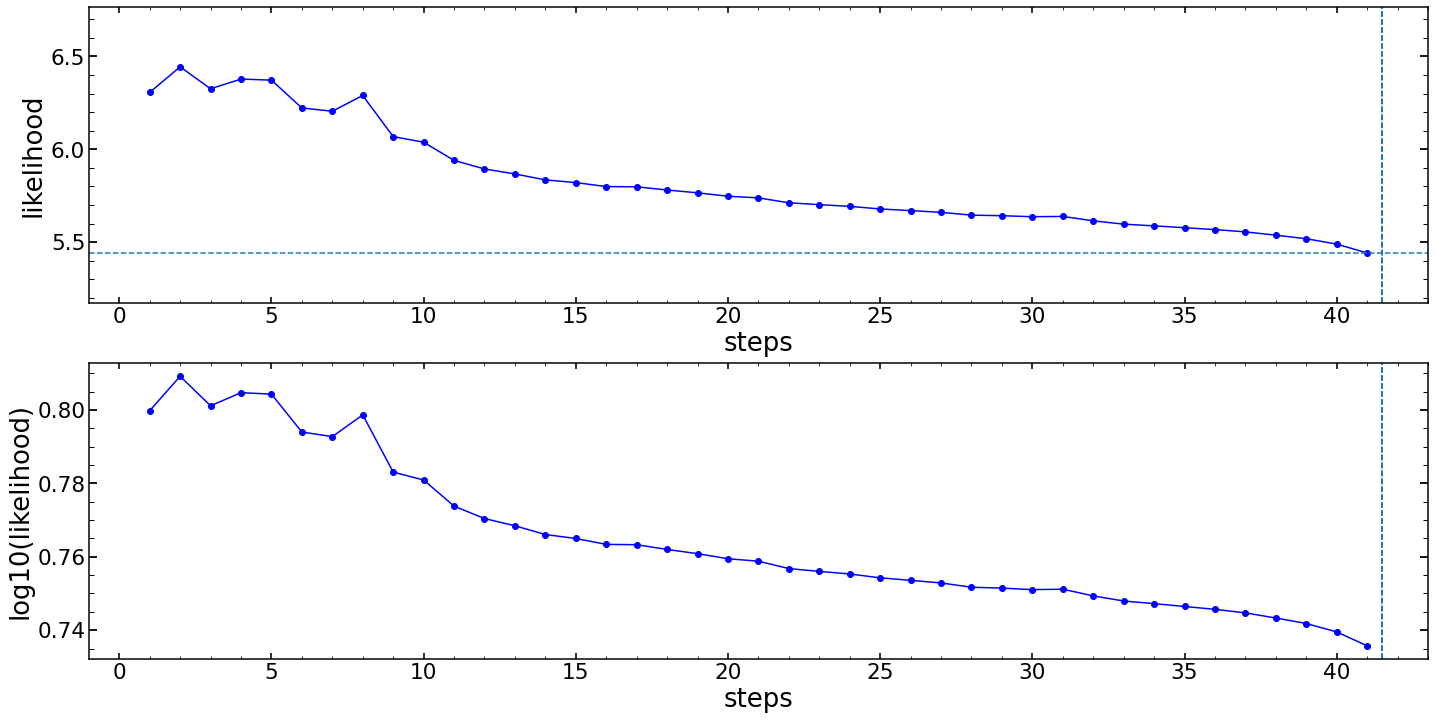

In [283]:
single_analysis.create_fitting_evolution_plot()

In [232]:
array_of_multi_background_factors=np.concatenate((np.arange(80,3,-(80-3)/(nsteps-1)),np.array([3])) )
array_of_multi_background_factors[1]

41.5

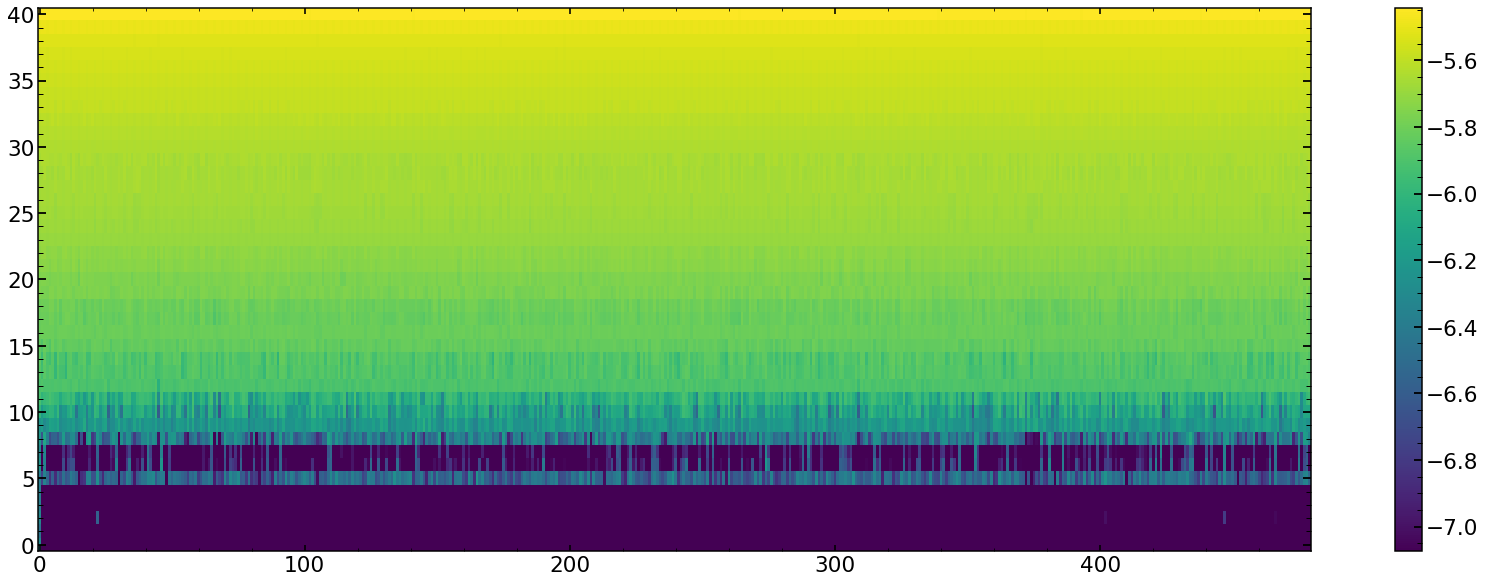

In [285]:
plt.figure(figsize=(30,10))
plt.imshow(likechain0_swarm_1,aspect=int(0.5*likechain0_swarm_1.shape[1]/likechain0_swarm_1.shape[0]),vmax=np.max(likechain0_swarm_1[-1][0:]),vmin=1.3*np.max(likechain0_swarm_1[-1][0:]))
plt.colorbar()

In [ ]:
chain0_swarm_1[2][348]

### image analysis 

In [557]:
minchain_parametrization=np.array([-7.8825157 ,    0.03305758,    0.49241792,   -0.91129426,
          0.2342229 ,   -0.54302017,   -0.01364976,   -0.34325149,
         -0.06352654,    0.40795935,    0.01064555,   -0.44396466,
          0.00450309,   -0.57982209,   -0.06671459,    0.54374951,
         -0.00864246,    0.01886295,    0.00089042,    0.20247791,
          0.01402033,   -0.04694434,    0.01045948,    0.01222624,
          0.00874718,    0.03680648,   -0.00906852,    0.03962365,
         -0.01035716,    0.0319801 ,    0.00243948,   -0.03244641,
          0.01081932,   -0.03921772,    0.00747744,    0.01216259,
         -0.0274368 ,    0.03708531,    0.74796203,    0.10063605,
         -0.18061533,    0.29818468,    0.06030455,    0.09334561,
          0.13455681,    0.60470632,    0.13060856,    2.27934982,
         -0.06023926,    0.12231702,    0.83046815,    0.03813167,
          0.72609787,    1.13772377,    0.3738613 , 5613.41135189,
          1.76309606,    0.00356403,    0.45584128,    1.83302393,
          0.98015069,    0.00174632,   -0.01511988,    0.00168603,
         -0.01584725,    0.00229983,   -0.00785104,   -0.00124334,
          0.00851931,    0.00143488,    0.0022975 ,    0.00128037,
         -0.000155  ,    0.00072586,   -0.01416621,   -0.00198463,
          0.00245813,    0.00959034,   -0.01031893,    0.00038837,
          0.01306438,    0.0030908 ,    0.00319384,    0.00305834,
         -0.02084817,    0.00048789,    0.00160031,   -0.00283995,
          0.01114524,   -0.00086007,    0.00307501,    0.00170246,
         -0.00239154,    0.00263968,   -0.00073899,    0.00002547,
          0.00217737,   -0.00343051,    0.01019274,    0.00481108,
         -0.00834874,   -0.00196319,    0.00685014,   -0.00490918,
         -0.01084985,    0.00127341,   -0.00627397,   -0.00052602,
         -0.01719912,   -0.00058612,   -0.00185252,   -0.000253  ,
          0.00176255,   -0.00248642,   -0.0016823 ,    0.00042267,
         -0.00583862,    0.00281019,   -0.01018753,   -0.00236892,
          0.00407194,   -0.00156917,    0.00138039,   -0.0028367 ,
          0.00124819,    0.00222119,    0.00080149,   -0.005737  ,
         -0.00105242])    

In [ ]:
 0.57050912,  0.00423021,  1.06737511, -0.4293304 , -0.47180848,
        0.16800683,  0.44019932, -0.26865332, -0.72817819, -0.113978  ,
        0.14351805, -0.12059891,  0.32601238,  0.14147169,  0.11959505,
       -0.01162225

In [572]:
minchain_parametrization_test=np.copy(minchain_parametrization)
minchain_parametrization_test[:16]=minchain_parametrization_test[:16]+np.array([ 0.57050912,  0.00423021,  1.06737511, -0.4293304 , -0.47180848,
        0.16800683,  0.44019932, -0.26865332, -0.72817819, -0.113978  ,
        0.14351805, -0.12059891,  0.32601238,  0.14147169,  0.11959505,
       -0.01162225])

In [1237]:
model_multi=LN_PFS_multi_same_spot(list_of_sci_images,list_of_var_images,list_of_mask_images=list_of_mask_images,dithering=1,save=1,zmax=56,verbosity=1,\
                      double_sources=double_sources,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536,test_run=False)   


#minchain_parametrization_test=np.copy(chain0_swarm_1[2][348])
#minchain_parametrization_test[0]=minchain_parametrization_test[0]+array_of_delta_z_parametrizations_None_1_0[0]

list_of_minchain=model_multi.create_list_of_allparameters(minchain_parametrization_test,list_of_defocuses=list_of_defocuses_input_long,zmax=56)
#list_of_minchain=model_multi.create_list_of_allparameters(gbests_positions[-1],list_of_defocuses=list_of_defocuses_input_long,zmax=56)



res_multi=model_multi(list_of_minchain,return_Images=True)
#res_multi=model_multi(list_of_minchain,return_Images=True,use_only_chi=True)

mean_res_of_multi_same_spot,list_of_single_res,list_of_single_model_image,\
                list_of_single_allparameters,list_of_single_chi_results,array_of_psf_positions_output=res_multi

#model = LN_PFS_single(list_of_sci_images[index_of_single_image],list_of_var_images[index_of_single_image],mask_image=list_of_mask_images[index_of_single_image],dithering=1,save=1,zmax=22,verbosity=1,\
#                      double_sources=None,double_sources_positions_ratios=double_sources_positions_ratios,fit_for_flux=True,npix=1536)  

#res_with_Image=model(list_of_minchain[index_of_single_image],return_Image=True)

################################
analyzing image 1 out of 9
 
Science image shape is: (60, 60)
Top left pixel value of the science image is: 26.286358
Variance image shape is: (60, 60)
Top left pixel value of the variance image is: 8.231853
Mask image shape is: (60, 60)
Sum of mask image is: 0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
np.__version__1.18.5
skimage.__version__0.17.2
scipy.__version__1.5.0
Zernike_Module.__version__0.40a
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 56

Entering lnlike_Neven
allparameters [   32.35966296    -2.84449933    -1.46424429    -0.56904809
     1.05677998    -0.79683763    -0.83957595     1.0826209
     0.05159541     0.23869737    -0.15181199     0.02699841
     0.0328766      0.10617364     0.0171643     -0.0287926
    -0.04517753    -0.00510353     0.12597928     0.6982929
     0.10099376    -0.22868679     0.27114778     0.06266987
     0.10090548     0.2078

chi2 within shgo optimization routine (chi_2_almost_multi_values): [ -2.05352403 -23.64955719] / 7687.9805
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-11.05352403  -5.64955719] / 4958.1655
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-10.49102403 -22.52455719] / 7197.542
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-1.49102403 -4.52455719] / 5022.7466
chi2 within shgo optimization routine (chi_2_almost_multi_values): [  3.00897597 -31.52455719] / 9366.641
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ -5.99102403 -13.52455719] / 5979.03
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-11.05352403  -5.64955719] / 4958.1655
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-11.05352404  -5.64955719] / 4958.165
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-11.05352403  -5.64955721] / 4958.165
chi2 within shgo optimization routine (chi_2_

chi2 within shgo optimization routine (chi_2_almost_multi_values): [-6.67687284 15.39540646] / 3868.0442
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-6.67527417 15.39572307] / 3868.0442
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-6.67612565 15.39255714] / 3868.0444
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-6.67548704 15.39493159] / 3868.0437
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-6.67314117 15.39239887] / 3868.0444
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-6.67593993 15.39465456] / 3868.0442
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-6.67500701 15.39390267] / 3868.0442
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-6.67617994 15.39516902] / 3868.044
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-6.67665997 15.39619795] / 3868.0444
chi2 within shgo optimization routine (chi_2_almost_mult

Finished with optPsf_postprocessing
 
Internally fitting for flux; disregarding passed value for flux
Internally fitting for flux; multiplying all values in the model by 0.98
Finished with lnlike_Neven
chi_2_almost/d.o.f is 2367.6445; chi_2_almost_max_dof is 7850.842 log(improvment) is -0.5205997
multiprocessing.current_process() <_MainProcess name='MainProcess' parent=None started> thread 4489811392
uname_result(system='Darwin', node='IapetusUSA', release='18.7.0', version='Darwin Kernel Version 18.7.0: Tue Aug 20 16:57:14 PDT 2019; root:xnu-4903.271.2~2/RELEASE_X86_64', machine='x86_64', processor='i386')
Time for lnlike_Neven function in thread 4489811392 is: 14.559607028961182 seconds
 
################################
analyzing image 2 out of 9
 
Science image shape is: (50, 50)
Top left pixel value of the science image is: 21.762466
Variance image shape is: (50, 50)
Top left pixel value of the variance image is: 7.3002834
Mask image shape is: (50, 50)
Sum of mask image is: 0
Dith

chi2 within shgo optimization routine (chi_2_almost_multi_values): [0.88153221 7.45677829] / 4954.5947
chi2 within shgo optimization routine (chi_2_almost_multi_values): [0.83955448 7.76261185] / 4923.148
chi2 within shgo optimization routine (chi_2_almost_multi_values): [3.77799517 9.13052196] / 4927.57
chi2 within shgo optimization routine (chi_2_almost_multi_values): [2.22481938 9.05823403] / 4857.665
chi2 within shgo optimization routine (chi_2_almost_multi_values): [2.14086393 9.66990115] / 4800.2056
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-0.79757676  8.30199104] / 4823.7847
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 0.50373269 10.20928034] / 4696.4487
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 0.33582179 11.43261458] / 4600.6504
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 3.27426248 12.80052469] / 4619.501
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 1

Finished with optPsf_postprocessing
 
Internally fitting for flux; disregarding passed value for flux
Internally fitting for flux; multiplying all values in the model by 0.98
Finished with lnlike_Neven
chi_2_almost/d.o.f is 1881.2383; chi_2_almost_max_dof is 8588.992 log(improvment) is -0.6594984
multiprocessing.current_process() <_MainProcess name='MainProcess' parent=None started> thread 4489811392
uname_result(system='Darwin', node='IapetusUSA', release='18.7.0', version='Darwin Kernel Version 18.7.0: Tue Aug 20 16:57:14 PDT 2019; root:xnu-4903.271.2~2/RELEASE_X86_64', machine='x86_64', processor='i386')
Time for lnlike_Neven function in thread 4489811392 is: 12.329662084579468 seconds
 
################################
analyzing image 3 out of 9
 
Science image shape is: (40, 40)
Top left pixel value of the science image is: 12.662518
Variance image shape is: (40, 40)
Top left pixel value of the variance image is: 5.796301
Mask image shape is: (40, 40)
Sum of mask image is: 0
Dithe

chi2 within shgo optimization routine (chi_2_almost_multi_values): [ -6.18823308 -12.03291448] / 6823.1826
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-11.25073308  -4.15791448] / 5552.53
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-11.25073309  -4.15791448] / 5552.53
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-11.25073308  -4.1579145 ] / 5552.5312
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-11.25073308  -2.35334274] / 5366.9414
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-11.25073308  -3.25468367] / 5455.4277
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-11.25073308  -3.70580465] / 5502.753
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-11.25073308  -3.9316061 ] / 5527.687
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-11.25073308  -4.04463379] / 5540.2036
chi2 within shgo optimization routine (chi_

chi2 within shgo optimization routine (chi_2_almost_multi_values): [-6.10636085  6.86875593] / 4815.63
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-6.10648953  6.86832579] / 4815.63
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-6.10564368  6.86942111] / 4815.63
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-6.10627807  6.86859962] / 4815.629
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-6.10568959  6.86883466] / 4815.63
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-6.10619303  6.86877561] / 4815.63
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-6.10602522  6.86879529] / 4815.63
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-6.10606661  6.86887345] / 4815.629
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-6.10581376  6.86906912] / 4815.631
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-6

Time for postprocessing pupil after _get_Pupil 0.2592959403991699
Time for pupil and illumination calculation is 0.2657039165496826

Starting creation of wavefront
diam_sic: 0.1395327
aberrations: [0.0, 0, 0.0, 0.0, 4.273962673664593, -1.178405336230402, -0.7009691119821306, -0.6215950751050952, 0.8095662064990572, -0.7319342502216943, -0.9186158883892122, 0.8644709477848977, 0.04025837158063393, 0.23068779926476962, -0.062279907725973284, 0.03208660311617952, 0.05551005330690632, 0.05785645329568458, 0.026264691742315705, -0.031630366905948386, -0.034477770555944906, 0.021386537142988812, 0.05511052927010908, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
aberrations moved to z4=0: [0.0, 0.0, 0.0, 0.0, 0, -1.178405336230402, -0.7009691119821306, -0.6215950751050952, 0.8095662064990572, -0.7319342502216943, -0.9186158883892122, 0, 0.04025837158063393, 0.23068779926

chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 2.86834219 -0.02133663] / 239.00795
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 2.86834221 -0.0213367 ] / 239.00797
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 2.8683422  -0.02133665] / 239.00797
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 2.8683422  -0.02133667] / 239.00797
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 2.86834222 -0.02133671] / 239.00793
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 2.86834226 -0.02133683] / 239.00801
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 2.86834222 -0.02133671] / 239.00793
We are fitting for only one source
One source fitting result is [ 2.86834225 -0.02133679]
type(complete_realization_renormalized)<class 'numpy.float32'>
Time for single_Psf_position protocol is 0.2637519836425781
Sucesfully created optPsf_cut_fiber_convolved_downsa

chi2 within shgo optimization routine (chi_2_almost_multi_values): [-3.3717274  -7.69269317] / 70.53684
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-3.38168041 -7.59022513] / 70.53304
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-3.3123021  -7.61868848] / 70.526764
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-3.32284057 -7.69307268] / 70.538536
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-3.32832937 -7.60227461] / 70.5257
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-3.35672471 -7.62997894] / 70.52547
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-3.37893601 -7.63562417] / 70.52877
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-3.34435663 -7.58586075] / 70.527824
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-3.34161224 -7.63125979] / 70.524895
chi2 within shgo optimization routine (chi_2_almost_multi_val

Time for postprocessing pupil after _get_Pupil 0.24842429161071777
Time for pupil and illumination calculation is 0.25397777557373047

Starting creation of wavefront
diam_sic: 0.1395327
aberrations: [0.0, 0, 0.0, 0.0, -3.7505231235400585, -0.7023784808254919, -0.48289048952133773, -0.6366084986601739, 0.7389337006728449, -0.7133904282886183, -0.9411987291679154, 0.8021423893055932, 0.03701921727871536, 0.22839935053516663, -0.036699312245598685, 0.03354037226601576, 0.0619767556281039, 0.04405154345961625, 0.028864804051634583, -0.03244115740840232, -0.03142069654292452, 0.028955127537114954, 0.03486231570193804, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
aberrations moved to z4=0: [0.0, 0.0, 0.0, 0.0, 0, -0.7023784808254919, -0.48289048952133773, -0.6366084986601739, 0.7389337006728449, -0.7133904282886183, -0.9411987291679154, 0, 0.03701921727871536, 0.228399

chi2 within shgo optimization routine (chi_2_almost_multi_values): [-0.36382175  0.09438451] / 175.84921
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-0.36391649  0.09436397] / 175.84921
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-0.36375233  0.09430139] / 175.84918
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-0.36367026  0.0942701 ] / 175.84921
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-0.36377766  0.09419775] / 175.84921
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-0.36381072  0.09433782] / 175.84921
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-0.3637997   0.09429113] / 175.84921
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-0.36378704  0.09434295] / 175.8492
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-0.36373967  0.09435322] / 175.84921
chi2 within shgo optimization routine (chi_2_almost_mult

Time to apodize the pupil: 0.14302492141723633
type(ilum_radiometric_apodized)<class 'numpy.float32'>
Time for postprocessing pupil after _get_Pupil 0.2908792495727539
Time for pupil and illumination calculation is 0.2970747947692871

Starting creation of wavefront
diam_sic: 0.1395327
aberrations: [0.0, 0, 0.0, 0.0, -23.811737616551685, 0.48768865768678304, 0.06230606663064464, -0.6741420575478708, 0.5623524361073142, -0.6670308734559285, -0.9976558311146735, 0.6463209931073317, 0.02892133152391895, 0.2226782287111591, 0.027252176455337812, 0.037174795140606336, 0.07814351143109785, 0.009539268869445415, 0.03536508482493178, -0.03446813366453716, -0.023778011510373585, 0.04787660352243031, -0.015758218218489557, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
aberrations moved to z4=0: [0.0, 0.0, 0.0, 0.0, 0, 0.48768865768678304, 0.06230606663064464, -0.674142057547

chi2 within shgo optimization routine (chi_2_almost_multi_values): [  7.47075988 -11.02284346] / 821.05115
chi2 within shgo optimization routine (chi_2_almost_multi_values): [  7.47066208 -11.02273921] / 821.05133
chi2 within shgo optimization routine (chi_2_almost_multi_values): [  7.47083446 -11.02342402] / 821.0512
chi2 within shgo optimization routine (chi_2_almost_multi_values): [  7.4708239  -11.02284907] / 821.0512
chi2 within shgo optimization routine (chi_2_almost_multi_values): [  7.47082742 -11.02304072] / 821.0512
chi2 within shgo optimization routine (chi_2_almost_multi_values): [  7.47079013 -11.02275044] / 821.0513
chi2 within shgo optimization routine (chi_2_almost_multi_values): [  7.47079717 -11.02313374] / 821.0512
chi2 within shgo optimization routine (chi_2_almost_multi_values): [  7.47079541 -11.02303791] / 821.0514
chi2 within shgo optimization routine (chi_2_almost_multi_values): [  7.47079365 -11.02294209] / 821.0513
chi2 within shgo optimization routine (chi_2

Finished with optPsf_postprocessing
 
Internally fitting for flux; disregarding passed value for flux
Internally fitting for flux; multiplying all values in the model by 0.98
Finished with lnlike_Neven
chi_2_almost/d.o.f is 2006.4922; chi_2_almost_max_dof is 6414.265 log(improvment) is -0.5047094
multiprocessing.current_process() <_MainProcess name='MainProcess' parent=None started> thread 4489811392
uname_result(system='Darwin', node='IapetusUSA', release='18.7.0', version='Darwin Kernel Version 18.7.0: Tue Aug 20 16:57:14 PDT 2019; root:xnu-4903.271.2~2/RELEASE_X86_64', machine='x86_64', processor='i386')
Time for lnlike_Neven function in thread 4489811392 is: 5.216664791107178 seconds
 
################################
analyzing image 8 out of 9
 
Science image shape is: (60, 60)
Top left pixel value of the science image is: 21.682732
Variance image shape is: (60, 60)
Top left pixel value of the variance image is: 7.1247993
Mask image shape is: (60, 60)
Sum of mask image is: 0
Dithe

chi2 within shgo optimization routine (chi_2_almost_multi_values): [  2.53347449 -14.91611764] / 1056.739
chi2 within shgo optimization routine (chi_2_almost_multi_values): [  2.66183347 -14.7036146 ] / 1052.7056
chi2 within shgo optimization routine (chi_2_almost_multi_values): [  2.82905391 -15.85476643] / 1052.705
chi2 within shgo optimization routine (chi_2_almost_multi_values): [  3.08282822 -16.50562726] / 1052.3219
chi2 within shgo optimization routine (chi_2_almost_multi_values): [  3.25593596 -15.50504528] / 1037.9658
chi2 within shgo optimization routine (chi_2_almost_multi_values): [  3.63954108 -15.40546962] / 1026.833
chi2 within shgo optimization routine (chi_2_almost_multi_values): [  4.06053583 -17.20748228] / 1036.8636
chi2 within shgo optimization routine (chi_2_almost_multi_values): [  4.6172487  -16.10732465] / 1007.29254
chi2 within shgo optimization routine (chi_2_almost_multi_values): [  5.38445894 -15.90817334] / 987.7434
chi2 within shgo optimization routine (c

chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 12.60661426 -14.21193441] / 898.7484
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 12.60660816 -14.2119295 ] / 898.7484
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 12.60661259 -14.21193219] / 898.7485
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 12.60661702 -14.21193488] / 898.74835
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 12.60662283 -14.21193781] / 898.74835
We are fitting for only one source
One source fitting result is [ 12.60661978 -14.21193535]
type(complete_realization_renormalized)<class 'numpy.float32'>
Time for single_Psf_position protocol is 1.2434968948364258
Sucesfully created optPsf_cut_fiber_convolved_downsampled
Finished with optPsf_postprocessing
 
Internally fitting for flux; disregarding passed value for flux
Internally fitting for flux; multiplying all values in the model by 0.98
Finished with lnlike

simulation_00 parameter:None
are we invoking double sources (1 or True if yes): False
double source position/ratio is:[0 0]
Time for postprocessing up to single_Psf_position protocol is 0.7440428733825684
offset_initial_and_sci: [0.63295436 1.8425853 ]
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-3.30341078 -1.41673229] / 2558.725
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 5.69658922 16.58326771] / 5088.848
chi2 within shgo optimization routine (chi_2_almost_multi_values): [10.19658922  7.58326771] / 3509.7334
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 1.19658922 25.58326771] / 6998.26
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 3.44658922 12.08326771] / 4308.927
chi2 within shgo optimization routine (chi_2_almost_multi_values): [12.44658922 30.08326771] / 8119.224
chi2 within shgo optimization routine (chi_2_almost_multi_values): [7.94658922 3.08326771] / 2863.4736
chi2 within shgo opt

chi2 within shgo optimization routine (chi_2_almost_multi_values): [  8.99599851 -17.76988615] / 1294.6837
chi2 within shgo optimization routine (chi_2_almost_multi_values): [  8.63838679 -17.60185534] / 1294.3153
chi2 within shgo optimization routine (chi_2_almost_multi_values): [  8.60202712 -17.38846671] / 1294.5841
chi2 within shgo optimization routine (chi_2_almost_multi_values): [  8.73233468 -17.67053662] / 1294.3188
chi2 within shgo optimization routine (chi_2_almost_multi_values): [  8.6313106  -17.72122066] / 1294.3478
chi2 within shgo optimization routine (chi_2_almost_multi_values): [  8.7123858  -17.59368364] / 1294.3087
chi2 within shgo optimization routine (chi_2_almost_multi_values): [  8.61843791 -17.52500235] / 1294.368
chi2 within shgo optimization routine (chi_2_almost_multi_values): [  8.70386048 -17.63415305] / 1294.3047
chi2 within shgo optimization routine (chi_2_almost_multi_values): [  8.77785949 -17.62598135] / 1294.3242
chi2 within shgo optimization routine 

We are fitting for only one source
One source fitting result is [  8.69354996 -17.63015764]
type(complete_realization_renormalized)<class 'numpy.float32'>
Time for single_Psf_position protocol is 1.0575218200683594
Sucesfully created optPsf_cut_fiber_convolved_downsampled
Finished with optPsf_postprocessing
 
Internally fitting for flux; disregarding passed value for flux
Internally fitting for flux; multiplying all values in the model by 0.98
Finished with lnlike_Neven
chi_2_almost/d.o.f is 2425.7395; chi_2_almost_max_dof is 7533.3784 log(improvment) is -0.49214563
multiprocessing.current_process() <_MainProcess name='MainProcess' parent=None started> thread 4489811392
uname_result(system='Darwin', node='IapetusUSA', release='18.7.0', version='Darwin Kernel Version 18.7.0: Tue Aug 20 16:57:14 PDT 2019; root:xnu-4903.271.2~2/RELEASE_X86_64', machine='x86_64', processor='i386')
Time for lnlike_Neven function in thread 4489811392 is: 6.388558864593506 seconds
 
##########################

In [1020]:
res_multi[-1]

array([[-13.36499466, -10.29143624],
       [ -8.86838526,  -2.93620277],
       [ -4.55840498, -13.5279559 ],
       [  0.44278519,  -3.21119158],
       [ -3.99996808,  -4.54601137],
       [  0.62323234,   2.91039811],
       [  6.84565877,  -4.58063124],
       [ 11.6117181 ,   3.21313551],
       [  7.27545014,  -7.50184562]])

In [1032]:
list_of_var_images_via_model=[]
for index_of_single_image in range(len(list_of_sci_images)):
    single_var_image_via_model=create_custom_var(modelImg=list_of_single_model_image[index_of_single_image],sci_image=list_of_sci_images[index_of_single_image],
                                    var_image=list_of_var_images[index_of_single_image],mask_image=list_of_mask_images[index_of_single_image])
    
    list_of_var_images_via_model.append(single_var_image_via_model)

In [1033]:
use_only_chi=True


array_of_var_sum=np.array(list(map(np.sum,list_of_var_images)))
index_of_max_var_sum=np.where(array_of_var_sum==np.min(array_of_var_sum))[0][0]
# find what variance selectes top 20% of pixels
# this is done to weight more the images in focus and less the image out of focus in the 
# final likelihood result
quantile_08_focus=np.quantile(list_of_sci_images[index_of_max_var_sum],0.8)




list_of_var_sums=[]
for i in range(9):
    var_image_masked=list_of_var_images[i]
    sci_image=list_of_sci_images[i]
    

    mean_value_of_background=np.mean([np.median(var_image_masked[0]),np.median(var_image_masked[-1]),\
                          np.median(var_image_masked[:,0]),np.median(var_image_masked[:,-1])])*3
    #print(mean_value_of_background)
 
    #flux_mask=sci_image>(mean_value_of_background)
    #var_image_masked=var_image[flux_mask]
    
    var_image_masked_without_nan = var_image_masked.ravel()[var_image_masked.ravel()>quantile_08_focus]
    #print('number of pixels considering in image '+str(i)+': '+str(var_image_masked_without_nan.shape[0]))
    var_sum=-(1/2)*(np.sum(np.log(2*np.pi*var_image_masked_without_nan)))
    
    if use_only_chi==True:
        var_sum=-(1)*(np.mean(np.abs(var_image_masked_without_nan)))
    list_of_var_sums.append(var_sum)
    
array_of_var_sum=np.array(list_of_var_sums)
max_of_array_of_var_sum=np.max(array_of_var_sum)
print('array_of_var_sum '+str(array_of_var_sum))
renormalization_of_var_sum=array_of_var_sum/max_of_array_of_var_sum

renormalization_of_var_sum

array_of_var_sum=np.array(list(map(np.sum,list_of_var_images)))
index_of_max_var_sum=np.where(array_of_var_sum==np.min(array_of_var_sum))[0][0]
# find what variance selectes top 20% of pixels
# this is done to weight more the images in focus and less the image out of focus in the 
# final likelihood result

quantile_08_focus=np.quantile(list_of_sci_images[index_of_max_var_sum],0.8)
'model pixels with a flux larger than (quantile_08_focus): '+str(quantile_08_focus)

array_of_var_sum [-215.87121582 -209.41952515 -205.4322052  -158.58338928 -127.20812225
 -119.05495453 -218.79428101 -229.09568787 -242.25369263]


'model pixels with a flux larger than (quantile_08_focus): 16.822856903076207'

mean reported value:-8.814565022786459
array_of_single_res: [-10.09468365 -10.51449013 -11.25918293  -6.61714602  -4.6006608
  -5.54539204 -10.49984837  -9.69251537 -10.50716591]
renormalization factors: [1 1 1 1 1 1 1 1 1]
array_of_single_res renormalized: [-10.09468365 -10.51449013 -11.25918293  -6.61714602  -4.6006608
  -5.54539204 -10.49984837  -9.69251537 -10.50716591]


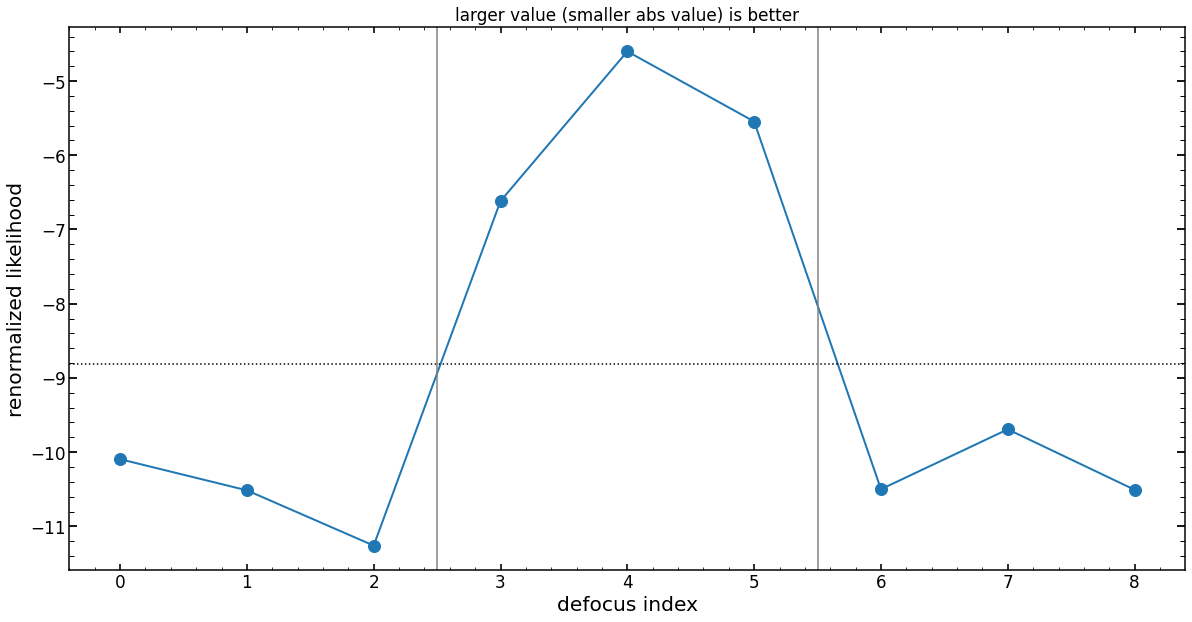

In [1034]:
# shows the reported likelihood for each image, after division by the renormalization factor
# smaller absolute values is better
# dotted lien shows the mean reported value

plt.figure(figsize=(20,10))
array_of_single_res=np.array(list_of_single_res)


renormalization_of_var_sum=np.array([1,1,1,1,1,1,1,1,1])


mean_res_of_multi_same_spot=np.mean(array_of_single_res/renormalization_of_var_sum)
print('mean reported value:'+str(mean_res_of_multi_same_spot))
print('array_of_single_res: '+str(array_of_single_res))
print('renormalization factors: '+str(renormalization_of_var_sum))
print('array_of_single_res renormalized: '+str(array_of_single_res/renormalization_of_var_sum))
plt.plot(array_of_single_res/renormalization_of_var_sum,marker='o',lw=2,ms=12)
plt.xlabel('defocus index')
plt.ylabel('renormalized likelihood')
plt.axhline(mean_res_of_multi_same_spot,color='black',ls=":")
plt.axvline(2.5,color='gray')
plt.title('larger value (smaller abs value) is better')
plt.axvline(5.5,color='gray')

In [1035]:
minchain=list_of_minchain[4]

print('minchain.shape '+str(minchain.shape))

    
dfz11 = pd.DataFrame(np.array([np.array([minchain])[0][0:8]]),columns=columns22[0:8])
print(dfz11)
print('##############################################')
dfz22 = pd.DataFrame(np.array([np.array([minchain])[0][8:19]]),columns=columns22[8:19])
print(dfz22)

print('')
#dfglobal = pd.DataFrame(np.array([np.array([minchain])[0][19:len(columns)]]),columns=columns[19:])
print('##############################################')
dfglobal1 = pd.DataFrame(np.array([np.array([minchain])[0][19:19+6]]),columns=columns22[19:19+6])
print(dfglobal1)
print('##############################################')
dfglobal2 = pd.DataFrame(np.array([np.array([minchain])[0][25:25+4]]),columns=columns22[25:25+4])
print(dfglobal2)
print('##############################################')
dfglobal3 = pd.DataFrame(np.array([np.array([minchain])[0][29:29+5]]),columns=columns22[29:29+5])
print(dfglobal3)
print('##############################################')
dfglobal4 = pd.DataFrame(np.array([np.array([minchain])[0][34:41]]),columns=columns22[34:41])
print(dfglobal4)

minchain.shape (76,)
        z4        z5       z6        z7       z8        z9       z10       z11
0  0.26172 -0.940392 -0.59193 -0.629102  0.77425 -0.722662 -0.929907  0.833307
##############################################
        z12       z13      z14       z15       z16       z17       z18  \
0  0.038639  0.229544 -0.04949  0.032813  0.058743  0.050954  0.027565   

        z19       z20       z21       z22  
0 -0.032036 -0.032949  0.025171  0.044986  

##############################################
    hscFrac  strutFrac   dxFocal   dyFocal  slitFrac  slitFrac_dy
0  0.698293   0.100994 -0.228687  0.271148   0.06267     0.100905
##############################################
     wide_0   wide_23   wide_43  misalign
0  0.207808  0.318535  0.311053  1.285643
##############################################
    x_fiber   y_fiber  effective_radius_illumination  frd_sigma  \
0 -0.050981 -0.018355                       0.878799   0.031031   

   frd_lorentz_factor  
0            0.72124

(-1.8, -0.8)

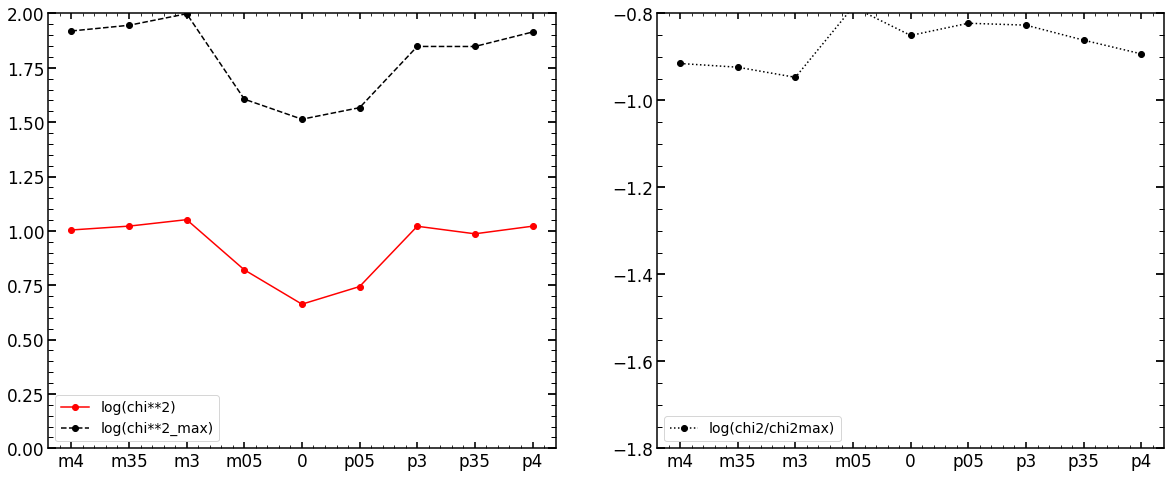

In [1036]:
chi_results_array=np.array(res_multi[4])

plt.figure(figsize=(20,8))

plt.subplot(121)

plt.plot(np.log10(chi_results_array[:,2]),color='red',label='log(chi**2)',marker='o')
#plt.plot(np.log10(chi_results_array[:,3])-2.3,color='black',label='log(chi**2_max)-2.3',marker='o')
plt.plot(np.log10(chi_results_array[:,3]),color='black',label='log(chi**2_max)',marker='o',ls='--')
plt.ylim(0,2)
plt.xticks(np.arange(0,len(list_of_defocuses_input_long),1),list_of_defocuses_input_long)
plt.legend()
plt.subplot(122)

plt.plot(np.log10(chi_results_array[:,2]/chi_results_array[:,3]),color='black',label='log(chi2/chi2max)',marker='o',ls=':')
plt.legend()
plt.xticks(np.arange(0,len(list_of_defocuses_input_long),1),list_of_defocuses_input_long)
#plt.ylim(-2.8,-1.5)
plt.ylim(-1.8,-0.8)

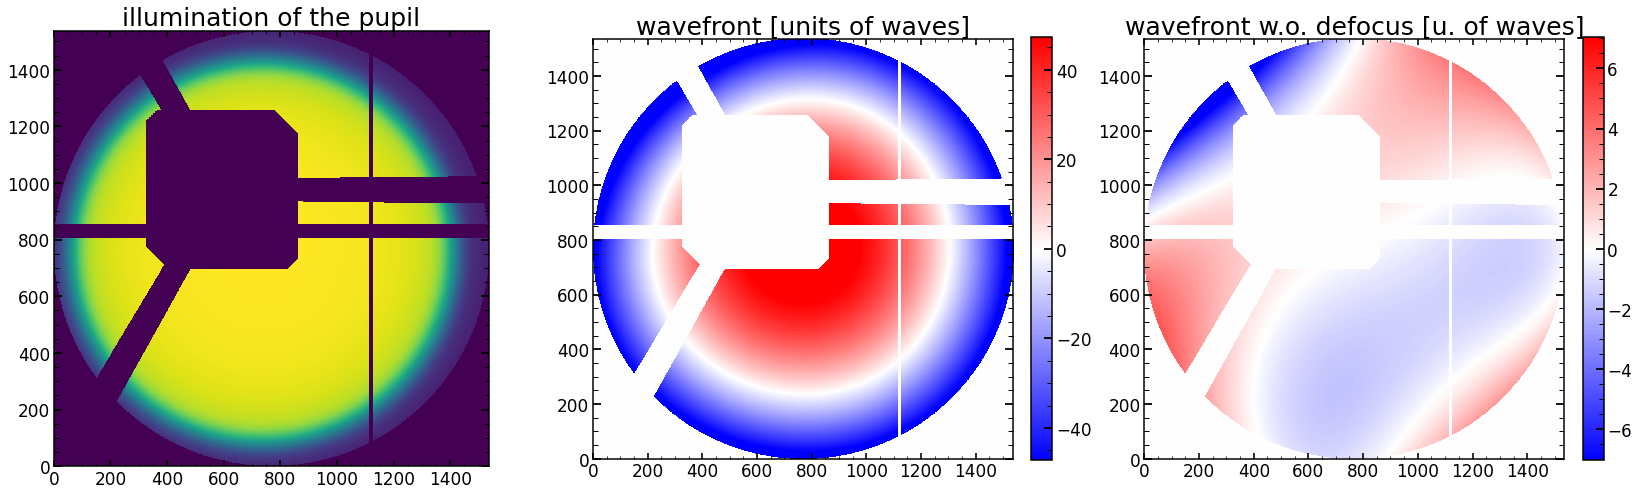

In [1037]:
single_analysis.illumination_wavefront_plot()

Science image shape is: (60, 60)
Top left pixel value of the science image is: 6.0081577
Variance image shape is: (60, 60)
Top left pixel value of the variance image is: 5.331963
Mask image shape is: (60, 60)
Sum of mask image is: 0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
np.__version__1.18.5
skimage.__version__0.17.2
scipy.__version__1.5.0
Zernike_Module.__version__0.45c
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 56
3x mean_value_of_background via sci is estimated to be: 28.184846878051758
---------------------
chi**2 max reduced is: 5996.051
chi**2 reduced is: 130.78262 for log improvment: -1.6613152
chi max reduced is: 52.091442
chi reduced is: 7.447988 for log improvment: -0.8447274
---------------------
chi**2 reduced within custom mask area is: 130.78262
---------------------
chi**2 max reduced within flux mask area is: 9517.021
chi**2 reduced within flux mask area is: 203.8669 for log impr

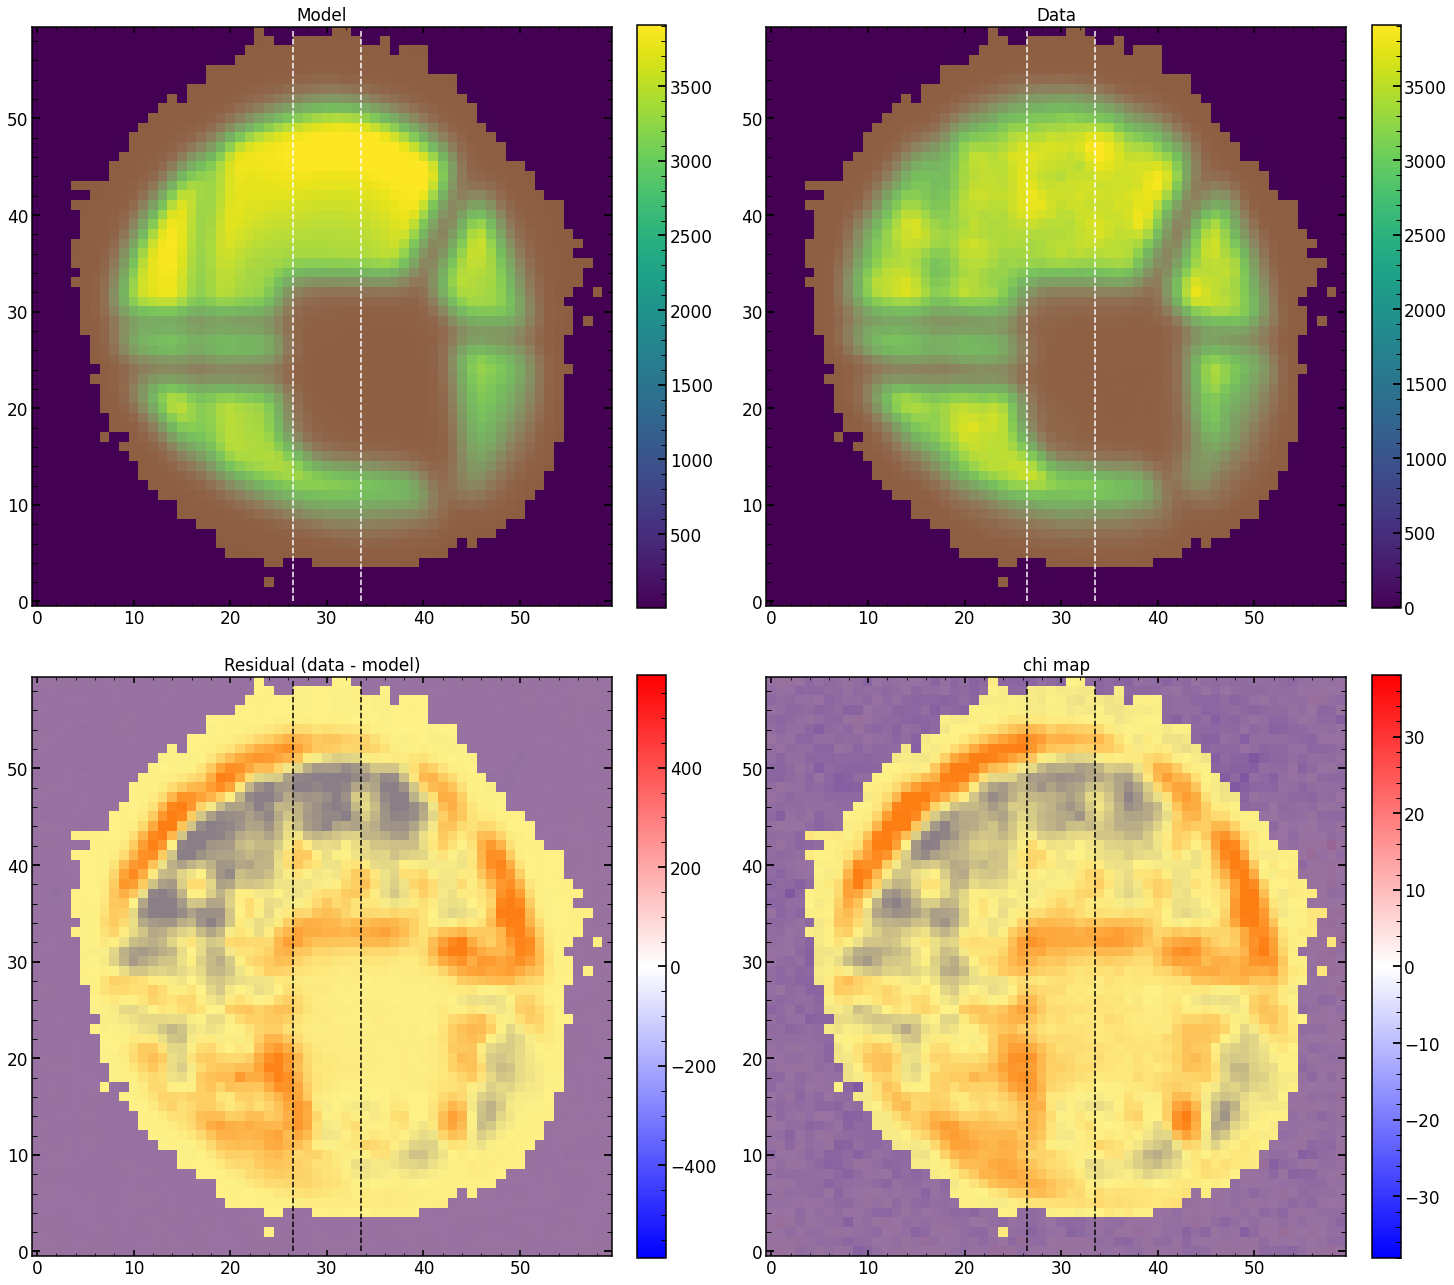

In [1042]:
index_of_single_image=8

#
model_single_image = LN_PFS_single(list_of_sci_images[index_of_single_image],list_of_var_images[index_of_single_image],mask_image=list_of_mask_images[index_of_single_image],\
                                   dithering=1,save=0,zmax=56,verbosity=1,\
                                   double_sources=double_sources,double_sources_positions_ratios=double_sources_positions_ratios,fit_for_flux=True,npix=1536)

custom_var=model_single_image.create_custom_var(modelImg=list_of_single_model_image[index_of_single_image],sci_image=list_of_sci_images[index_of_single_image],
                                    var_image=list_of_var_images[index_of_single_image],mask_image=list_of_mask_images[index_of_single_image])

matplotlib.rcParams.update({'font.size': 14})
single_analysis.create_basic_comparison_plot(custom_model_image=list_of_single_model_image[index_of_single_image],custom_mask=list_of_mask_images[index_of_single_image],\
                                             custom_sci_image=list_of_sci_images[index_of_single_image],custom_var_image=list_of_var_images[index_of_single_image],\
                                             show_flux_mask=True,use_max_chi_scaling=True,use_max_flux_scaling=True,show_impact_pixels_mask=False)

# I can move to use custom_var within the analysis
#single_analysis.create_basic_comparison_plot(custom_model_image=list_of_single_model_image[index_of_single_image],custom_mask=list_of_mask_images[index_of_single_image],\
#                                             custom_sci_image=list_of_sci_images[index_of_single_image],custom_var_image=custom_var,\
#                                             show_flux_mask=False,use_max_chi_scaling=True,use_max_flux_scaling=False)

array_of_sci_image=np.array(list_of_sci_images)
array_of_single_model_image=np.array(list_of_single_model_image)
array_of_var_images=np.array(list_of_var_images)
array_of_mask_images=np.array(list_of_mask_images)

np.save('/Users/nevencaplar/Documents/PFS/Testing/Data/'+'array_of_sci_image'+'_'+str(single_number),array_of_sci_image)
np.save('/Users/nevencaplar/Documents/PFS/Testing/Data/'+'array_of_single_model_image'+'_'+str(single_number),array_of_single_model_image)
np.save('/Users/nevencaplar/Documents/PFS/Testing/Data/'+'array_of_var_images'+'_'+str(single_number),array_of_var_images)
np.save('/Users/nevencaplar/Documents/PFS/Testing/Data/'+'array_of_mask_images'+'_'+str(single_number),array_of_mask_images)

Science image shape is: (60, 60)
Top left pixel value of the science image is: 6.0081577
Variance image shape is: (60, 60)
Top left pixel value of the variance image is: 5.331963
Mask image shape is: (60, 60)
Sum of mask image is: 0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
np.__version__1.18.5
skimage.__version__0.17.2
scipy.__version__1.5.0
Zernike_Module.__version__0.45c
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 56
3x mean_value_of_background via sci is estimated to be: 28.184846878051758
fraction of chi2 due to 1% of pixels: 0.09368333
---------------------
chi**2 max reduced is: 5996.051
chi**2 reduced is: 130.78262 for log improvment: -1.6613152
chi max reduced is: 52.091442
chi reduced is: 7.447988 for log improvment: -0.8447274
---------------------
chi**2 reduced within custom mask area is: 130.78262
---------------------
chi**2 max reduced within flux mask area is: 9517.021
chi**2 reduce

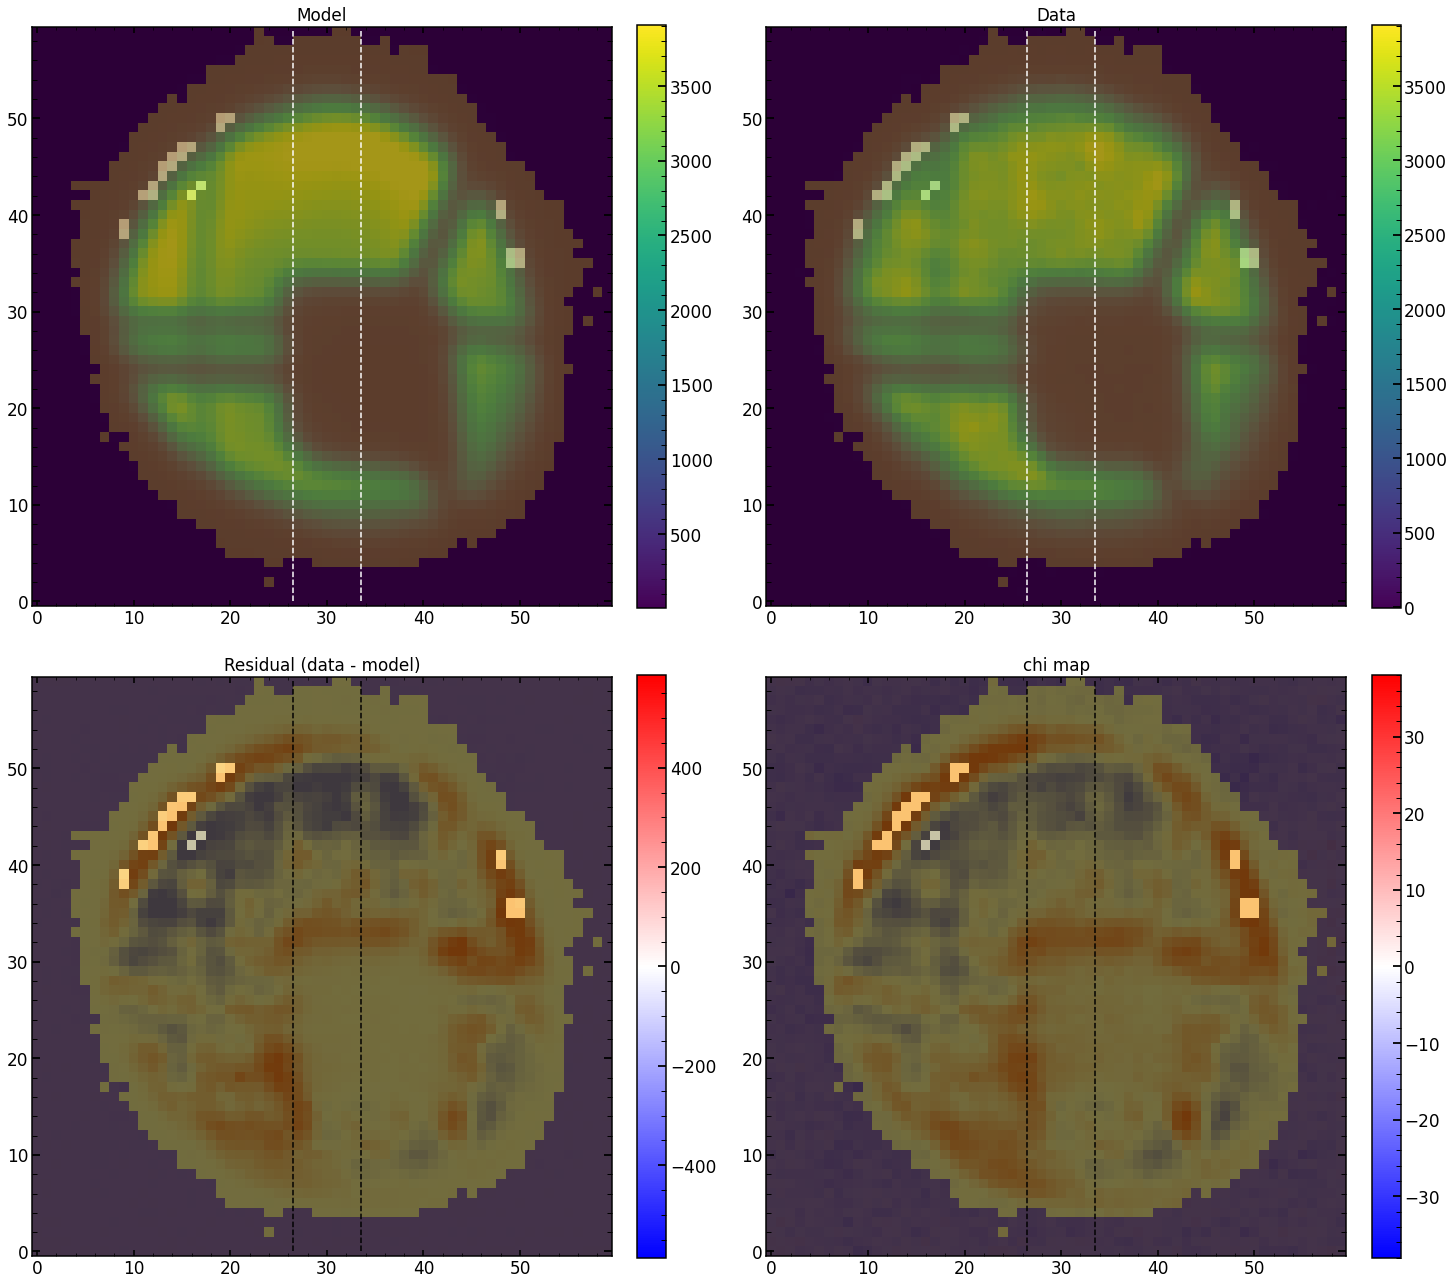

In [1043]:

model_single_image = LN_PFS_single(list_of_sci_images[index_of_single_image],list_of_var_images[index_of_single_image],mask_image=list_of_mask_images[index_of_single_image],\
                                   dithering=1,save=0,zmax=56,verbosity=1,\
                                   double_sources=double_sources,double_sources_positions_ratios=double_sources_positions_ratios,fit_for_flux=True,npix=1536)

custom_var=model_single_image.create_custom_var(modelImg=list_of_single_model_image[index_of_single_image],sci_image=list_of_sci_images[index_of_single_image],
                                    var_image=list_of_var_images[index_of_single_image],mask_image=list_of_mask_images[index_of_single_image])

matplotlib.rcParams.update({'font.size': 14})
single_analysis.create_basic_comparison_plot(custom_model_image=list_of_single_model_image[index_of_single_image],custom_mask=list_of_mask_images[index_of_single_image],\
                                             custom_sci_image=list_of_sci_images[index_of_single_image],custom_var_image=list_of_var_images[index_of_single_image],\
                                             show_flux_mask=True,use_max_chi_scaling=True,use_max_flux_scaling=True,show_impact_pixels_mask=True)

Science image shape is: (60, 60)
Top left pixel value of the science image is: 6.0081577
Variance image shape is: (60, 60)
Top left pixel value of the variance image is: 5.331963
Mask image shape is: (60, 60)
Sum of mask image is: 0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
np.__version__1.18.5
skimage.__version__0.17.2
scipy.__version__1.5.0
Zernike_Module.__version__0.45c
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 56
3x mean_value_of_background via sci is estimated to be: 28.184846878051758
---------------------
chi**2 max reduced is: 5996.051
chi**2 reduced is: 130.78262 for log improvment: -1.6613152
chi max reduced is: 52.091442
chi reduced is: 7.447988 for log improvment: -0.8447274
---------------------
chi**2 reduced within custom mask area is: 130.78262
---------------------
chi**2 max reduced within flux mask area is: 9517.021
chi**2 reduced within flux mask area is: 203.8669 for log impr

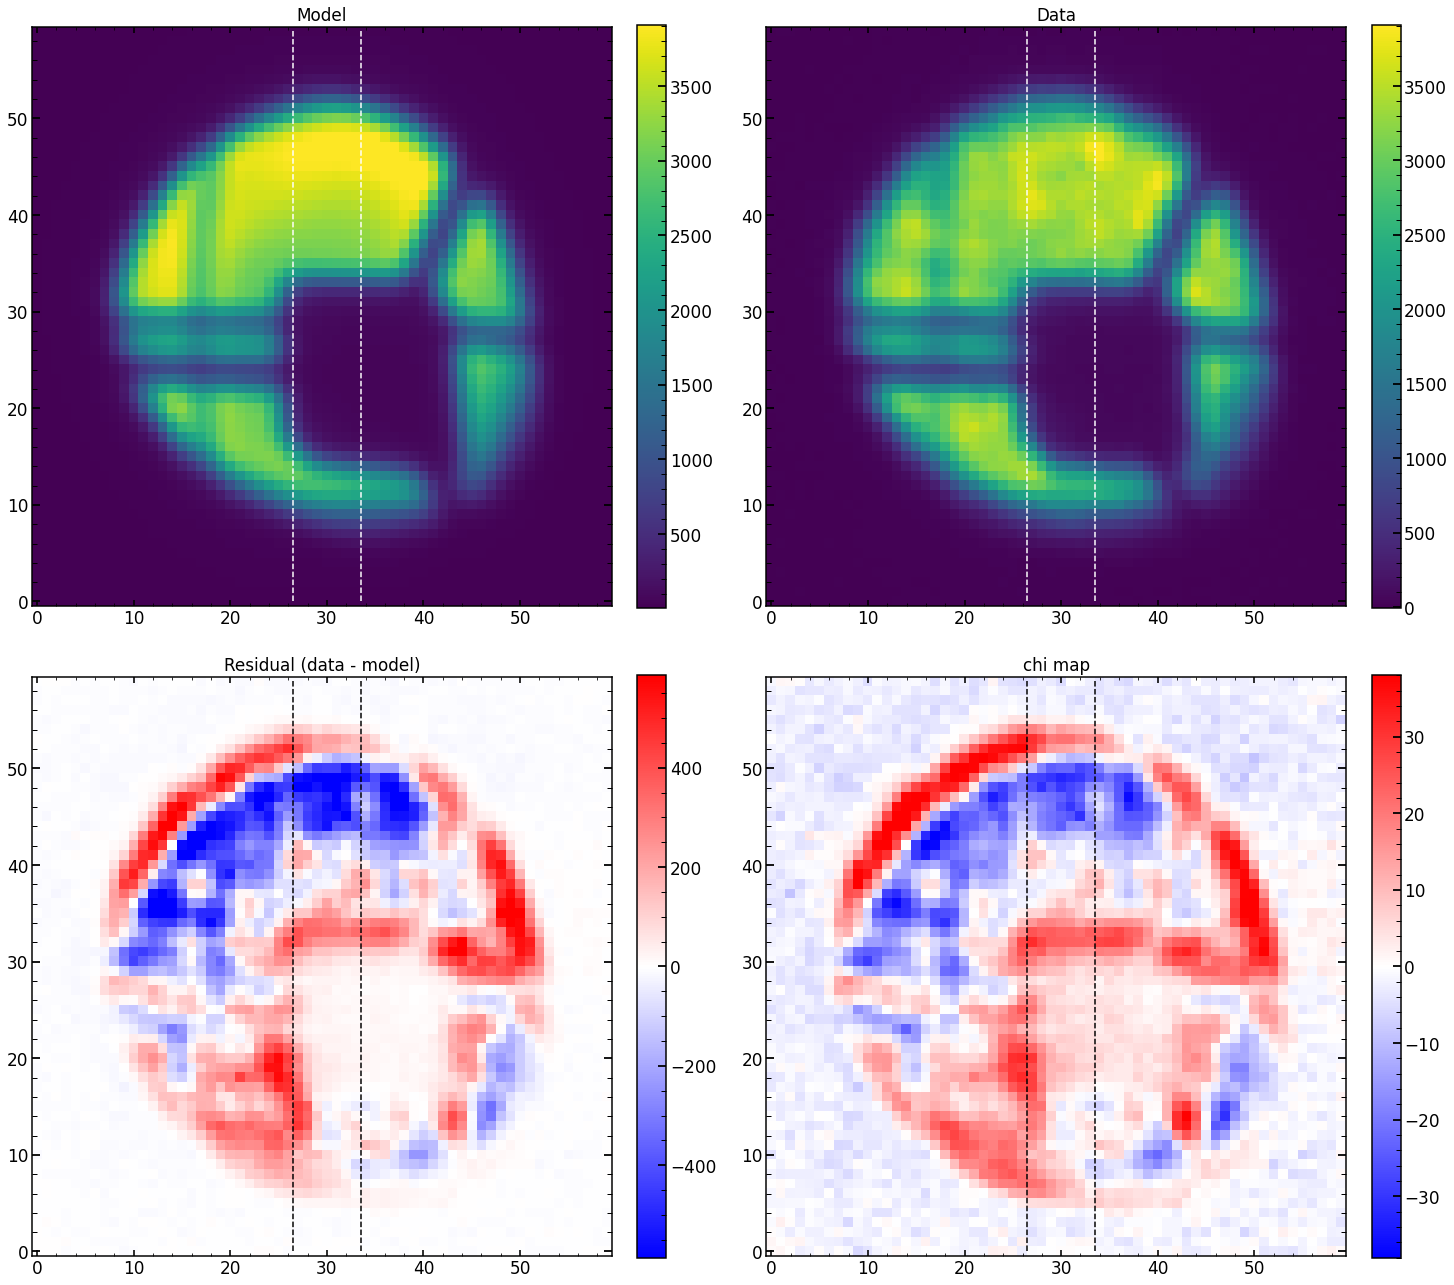

In [1044]:
#
model_single_image = LN_PFS_single(list_of_sci_images[index_of_single_image],list_of_var_images[index_of_single_image],mask_image=list_of_mask_images[index_of_single_image],\
                                   dithering=1,save=0,zmax=56,verbosity=1,\
                                   double_sources=double_sources,double_sources_positions_ratios=double_sources_positions_ratios,fit_for_flux=True,npix=1536)

custom_var=model_single_image.create_custom_var(modelImg=list_of_single_model_image[index_of_single_image],sci_image=list_of_sci_images[index_of_single_image],
                                    var_image=list_of_var_images[index_of_single_image],mask_image=list_of_mask_images[index_of_single_image])

matplotlib.rcParams.update({'font.size': 14})
single_analysis.create_basic_comparison_plot(custom_model_image=list_of_single_model_image[index_of_single_image],custom_mask=list_of_mask_images[index_of_single_image],\
                                             custom_sci_image=list_of_sci_images[index_of_single_image],custom_var_image=list_of_var_images[index_of_single_image],\
                                             show_flux_mask=False,use_max_chi_scaling=True,use_max_flux_scaling=True,show_impact_pixels_mask=False)

Science image shape is: (20, 20)
Top left pixel value of the science image is: -1.7947999
Variance image shape is: (20, 20)
Top left pixel value of the variance image is: 3.0357723
Mask image shape is: (20, 20)
Sum of mask image is: 0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
np.__version__1.18.5
skimage.__version__0.17.2
scipy.__version__1.5.0
Zernike_Module.__version__0.45c
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 56
3x mean_value_of_background via sci is estimated to be: 10.439679622650146
---------------------
chi**2 max reduced is: 632.0066
chi**2 reduced is: 11.924082 for log improvment: -1.7242967
chi max reduced is: 10.1755295
chi reduced is: 2.1612606 for log improvment: -0.6728499
---------------------
chi**2 reduced within custom mask area is: 11.924082
---------------------
chi**2 max reduced within flux mask area is: 2394.6223
chi**2 reduced within flux mask area is: 38.015385 for lo

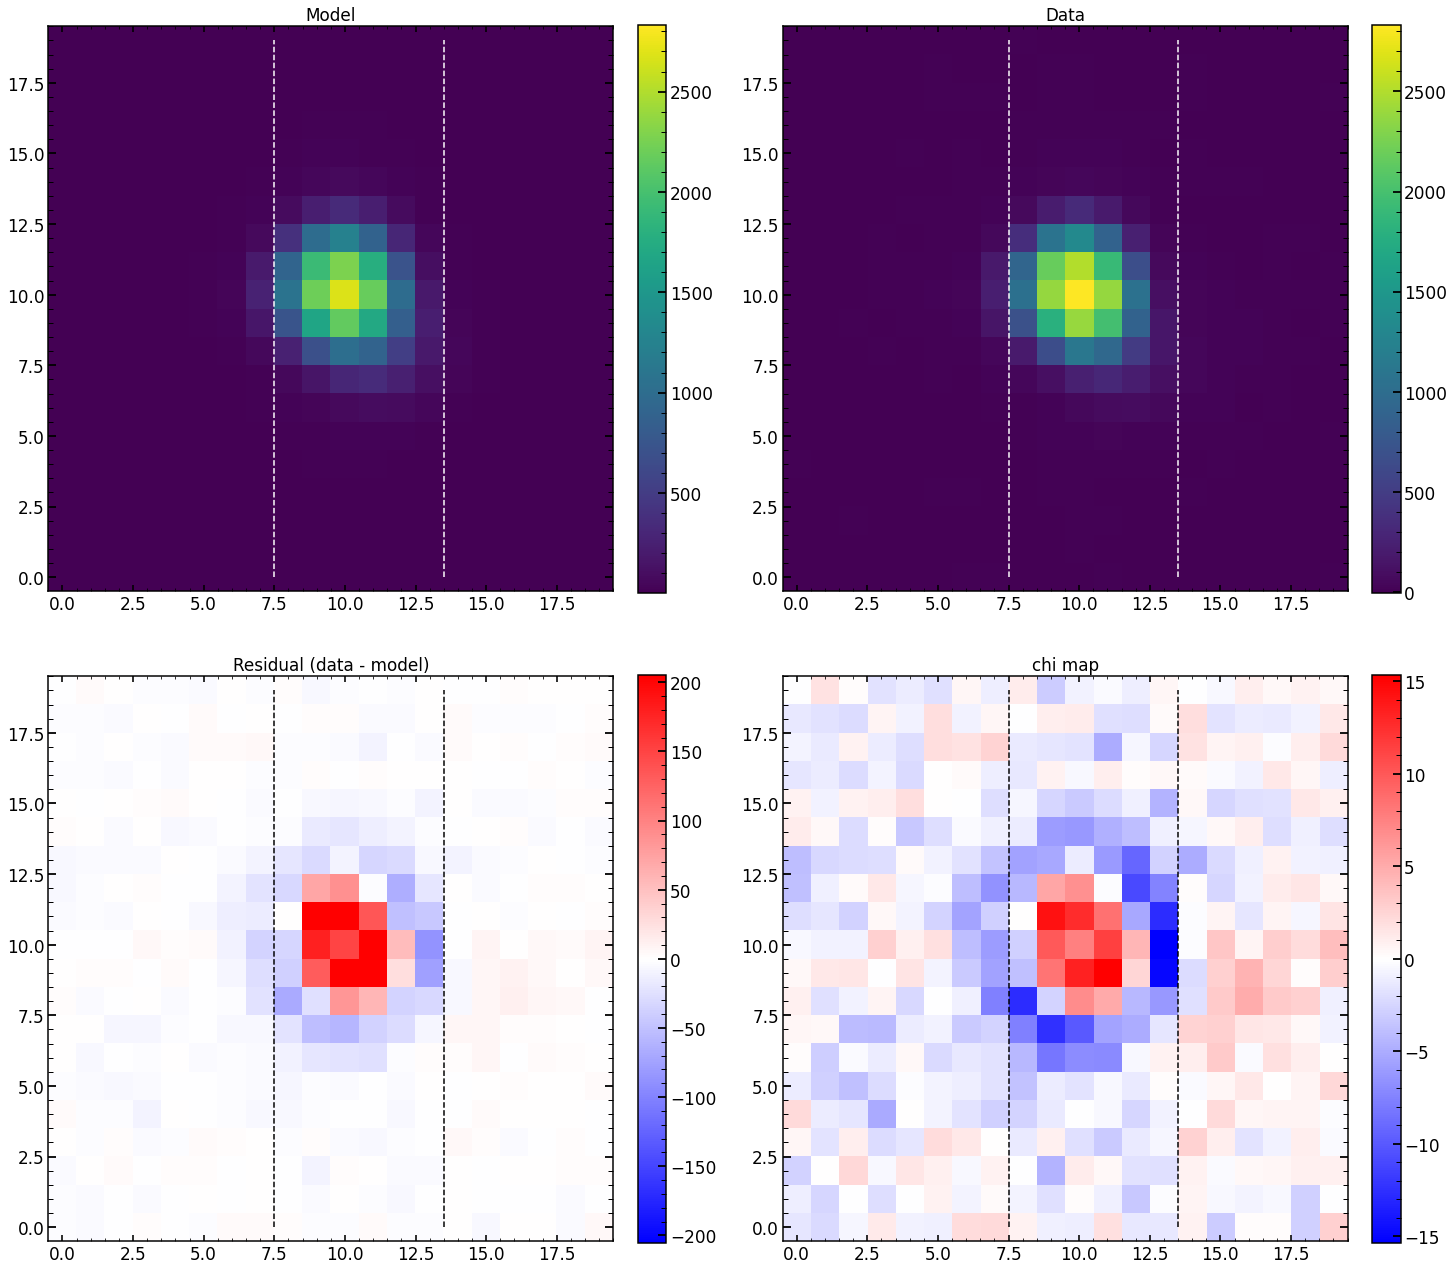

In [1045]:
index_of_single_image=4
model_single_image = LN_PFS_single(list_of_sci_images[index_of_single_image],list_of_var_images[index_of_single_image],mask_image=list_of_mask_images[index_of_single_image],\
                                   dithering=1,save=0,zmax=56,verbosity=1,\
                                   double_sources=double_sources,double_sources_positions_ratios=double_sources_positions_ratios,fit_for_flux=True,npix=1536)

custom_var=model_single_image.create_custom_var(modelImg=list_of_single_model_image[index_of_single_image],sci_image=list_of_sci_images[index_of_single_image],
                                    var_image=list_of_var_images[index_of_single_image],mask_image=list_of_mask_images[index_of_single_image])

matplotlib.rcParams.update({'font.size': 14})
single_analysis.create_basic_comparison_plot(custom_model_image=list_of_single_model_image[index_of_single_image],custom_mask=list_of_mask_images[index_of_single_image],\
                                             custom_sci_image=list_of_sci_images[index_of_single_image],custom_var_image=list_of_var_images[index_of_single_image],\
                                             show_flux_mask=False,use_max_chi_scaling=True,use_max_flux_scaling=True,show_impact_pixels_mask=False)

chi**2 max reduced is: 632.0066
chi**2 reduced is: 11.924082
Abs of residual divided by total flux is: 0.11547146
Abs of residual divided by largest value of a flux in the image is: 0.10212195


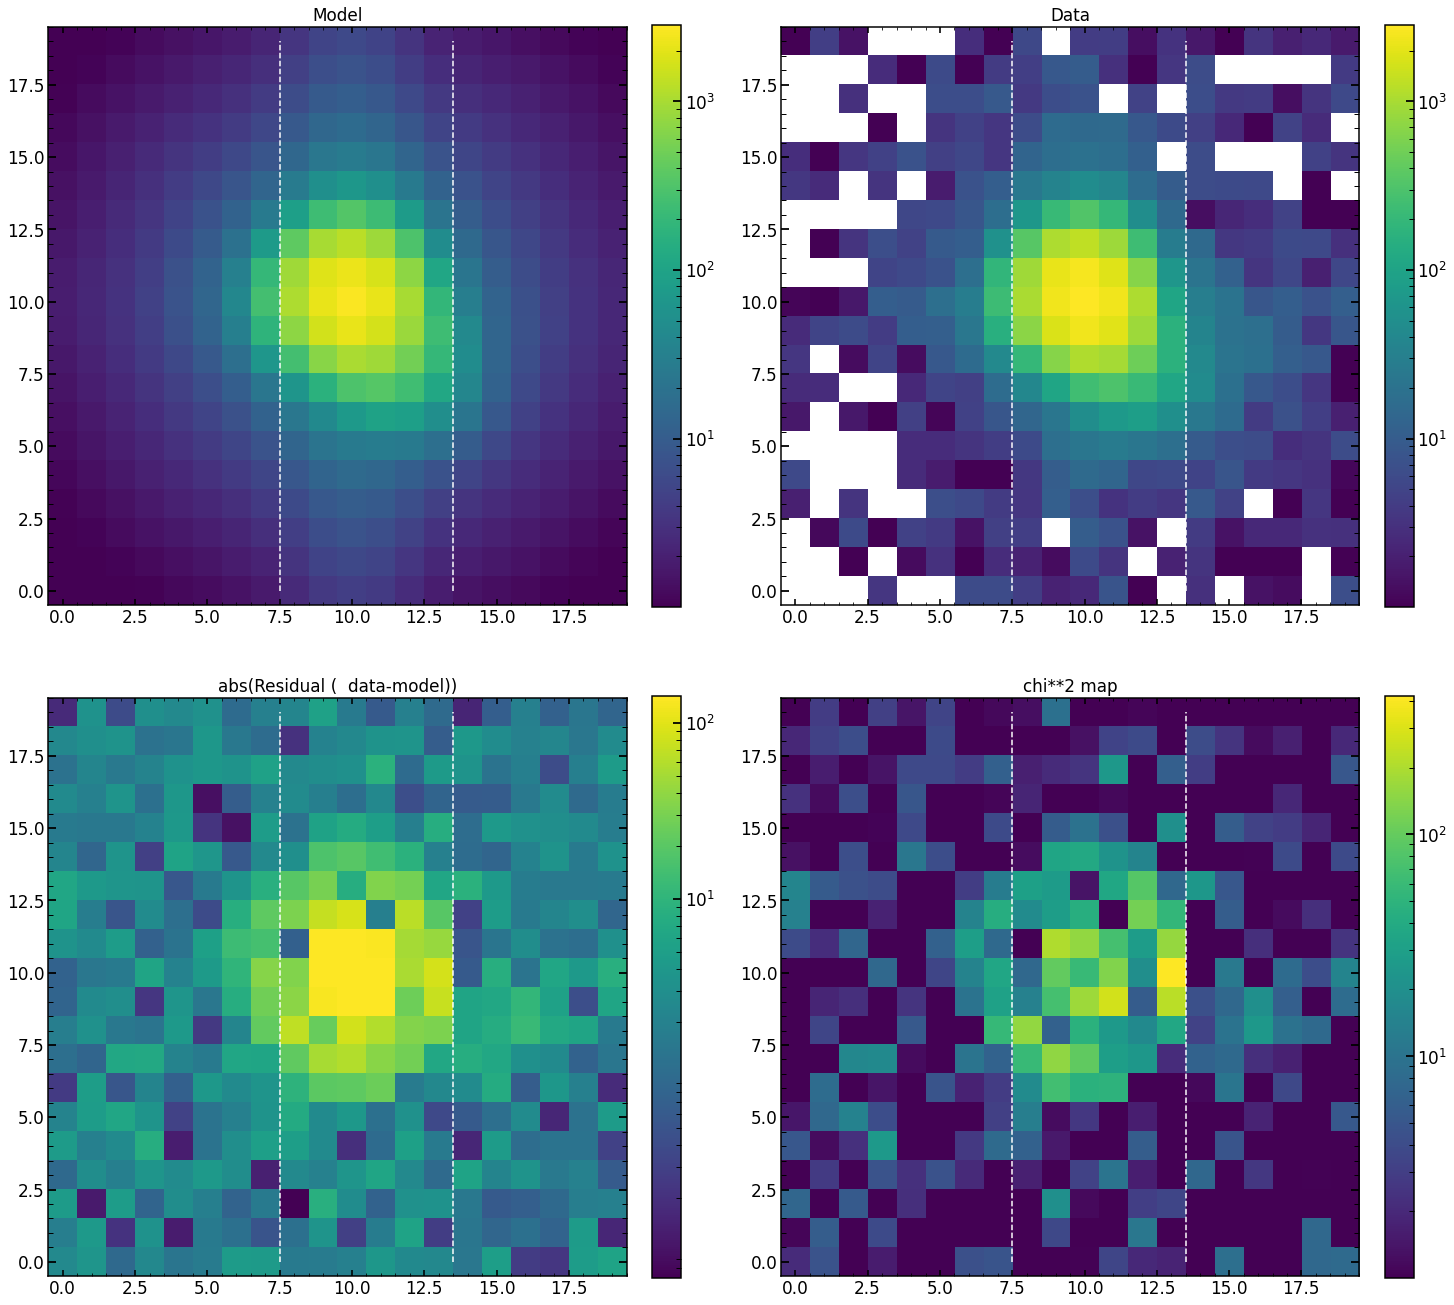

In [1031]:
single_analysis.create_basic_comparison_plot_log(custom_model_image=list_of_single_model_image[index_of_single_image],\
                                             custom_sci_image=list_of_sci_images[index_of_single_image],custom_var_image=list_of_var_images[index_of_single_image],\
                                                show_flux_mask=False)

11.124414
chi**2 reduced is: 11.124414
Abs of residual divided by total flux is: 0.093797065
Abs of residual divided by largest value of a flux in the image is: 0.046766695


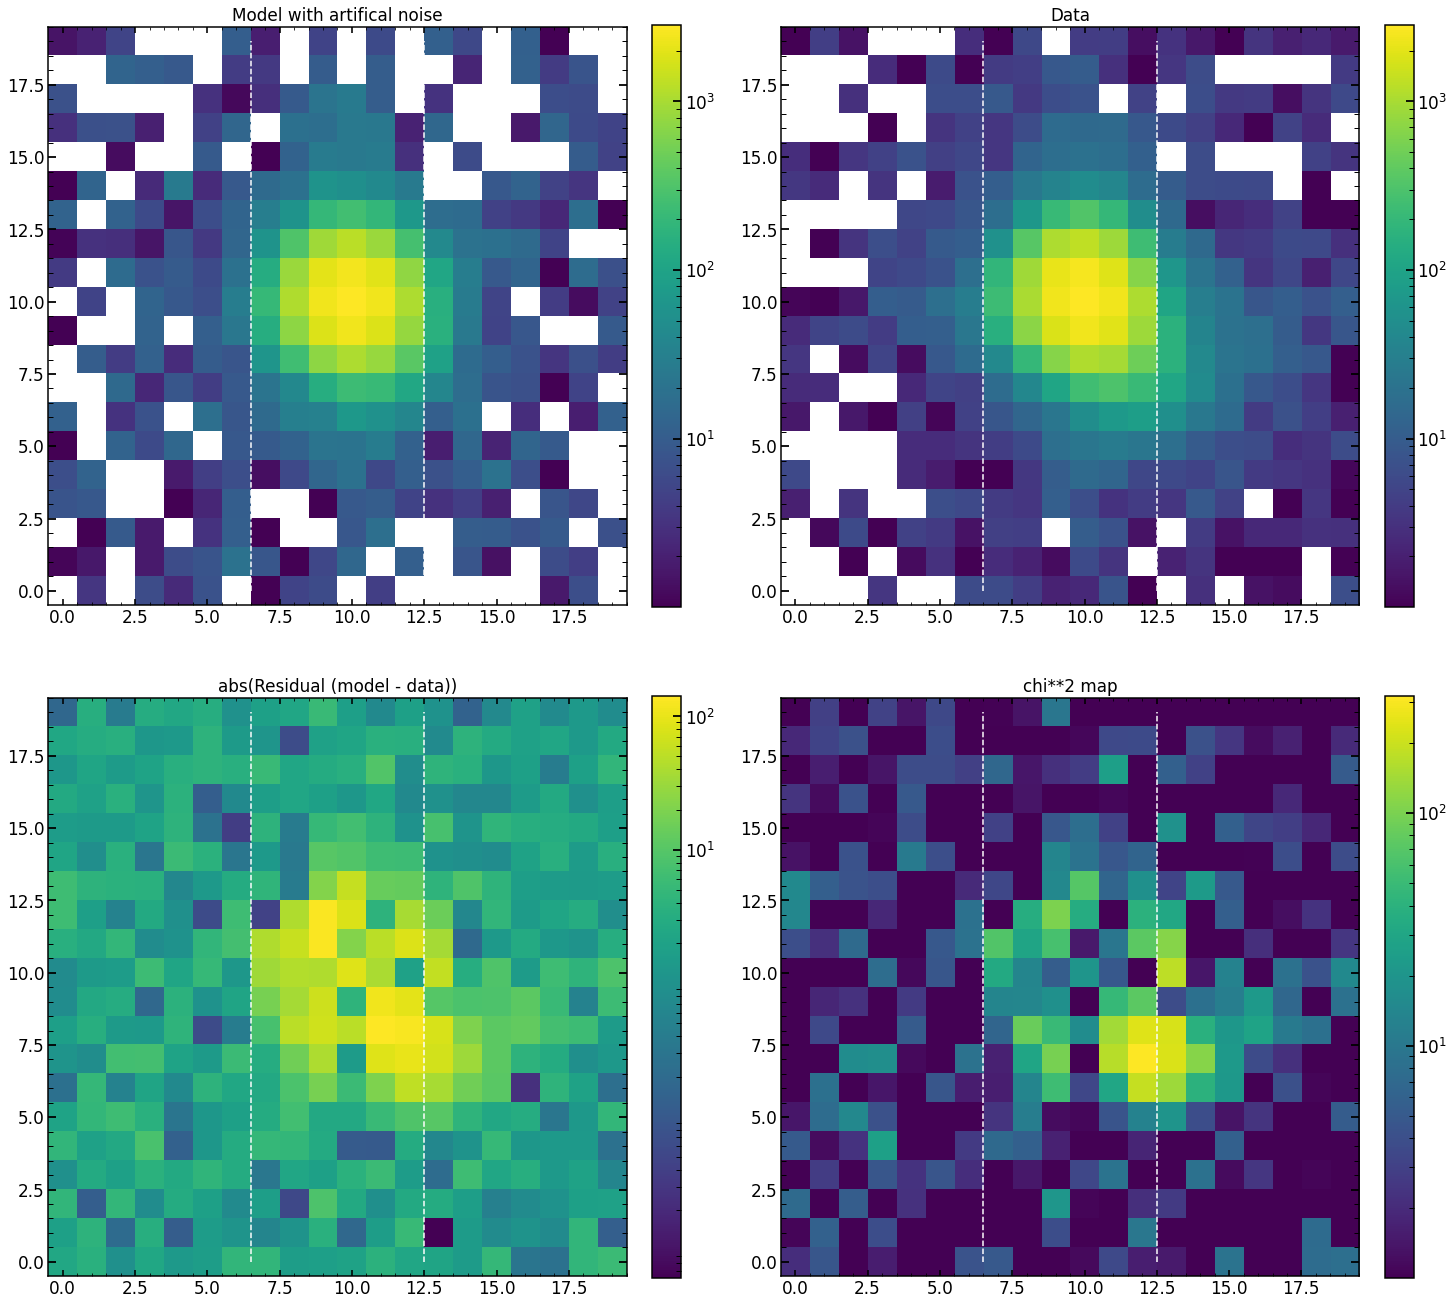

In [950]:
single_analysis.create_basic_comparison_plot_log_artifical(custom_model_image=list_of_single_model_image[index_of_single_image],\
                                             custom_sci_image=list_of_sci_images[index_of_single_image],\
                                                           custom_var_image=list_of_var_images[index_of_single_image])

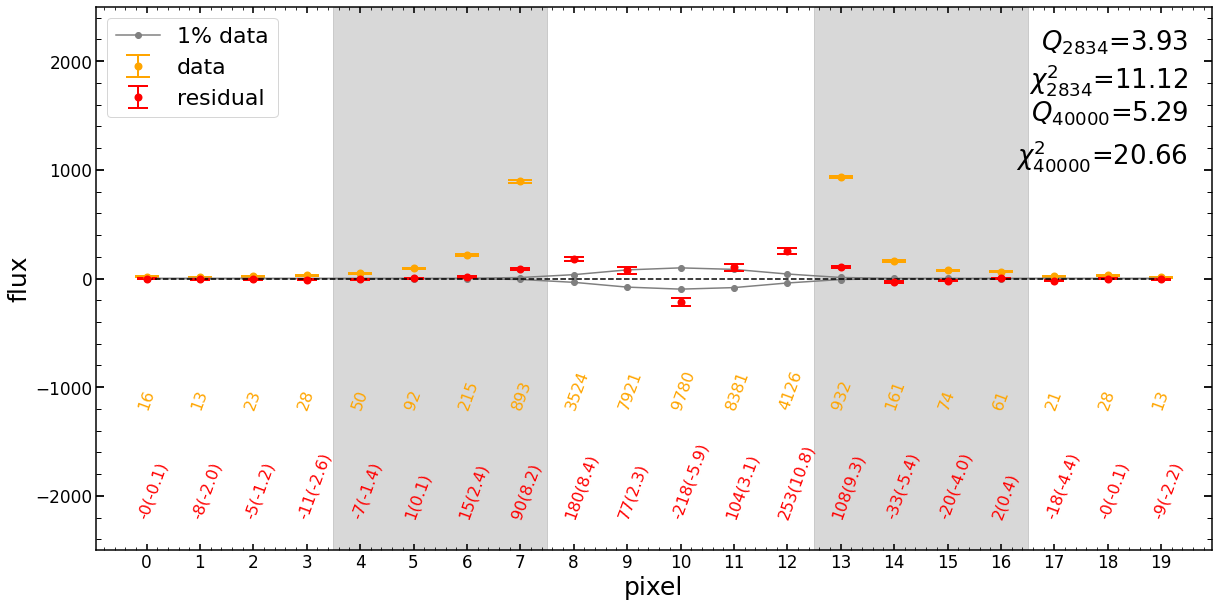

In [299]:
index_of_single_image=4
plot_1D_residual(sci_image=list_of_sci_images[index_of_single_image],var_image=list_of_var_images[index_of_single_image],model_image=list_of_single_model_image[index_of_single_image])

## testing the block 

In [ ]:
    """
    initial_model_result,final_model_result,\
    list_of_initial_model_result,list_of_final_model_result,\
    out_images, pre_images, list_of_image_final,\
    allparameters_parametrization_proposal, allparameters_parametrization_proposal_after_iteration,\
    list_of_initial_input_parameters, list_of_finalinput_parameters,\
    list_of_pre_chi2,list_of_after_chi2,\
    list_of_psf_positions,list_of_final_psf_positions,\
    [uber_images_normalized,uber_M0_std,H_std,array_of_delta_z_parametrizations_None,list_of_final_psf_positions] 
    
    0. likelihood averaged over all images (before the function)    
    1. likelihood averaged over all images (after the function)
    2. likelihood per image (output from model_multi) (before the function)
    3. likelihood per image (output from model_multi) (after the function)
    4. out_images
    5. list of initial model images
    6. list of final model images 
    7. parametrization before the function
    8. parametrization after the function
    9. list of parameters per image (before the function)
    10. list of parameters per image (after the function)
    11. list of chi2 per image (before the function)
    12. list of chi2 per image (after the function)
    13. list of psf position of image (function the function)
    14. list of psf position of image (after the function)
    """

In [332]:
# non-dedicated
best_result0=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/best_result0.npy',allow_pickle=True)
array_of_particle_position_proposal=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/array_of_particle_position_proposal0.npy',allow_pickle=True)
out20=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/out20.npy',allow_pickle=True)

In [283]:
# dedicated
best_result_from_Tokovinin_5=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/best_result_from_Tokovinin_5.npy',allow_pickle=True)
best_result0_global=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/best_result0_global.npy',allow_pickle=True)
out20_global=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/out20_global.npy',allow_pickle=True)


In [284]:
multi_background_factor=80
verbosity=2

list_of_mean_value_of_background=[]
list_of_flux_mask=[]
list_of_sci_image_std=[]
for i in range(len(list_of_sci_images)):
    sci_image=list_of_sci_images[i]
    var_image=list_of_var_images[i]

    mean_value_of_background_via_var=np.mean([np.median(var_image[0]),np.median(var_image[-1]),\
                                          np.median(var_image[:,0]),np.median(var_image[:,-1])])*multi_background_factor

    mean_value_of_background_via_sci=np.mean([np.median(sci_image[0]),np.median(sci_image[-1]),\
                                          np.median(sci_image[:,0]),np.median(sci_image[:,-1])])*multi_background_factor

    mean_value_of_background=np.max([mean_value_of_background_via_var,mean_value_of_background_via_sci])
    if verbosity>1:
        print(str(multi_background_factor)+'x mean_value_of_background in image with index'+str(i)+' is estimated to be: '+str(mean_value_of_background))


    list_of_mean_value_of_background.append(mean_value_of_background)
    flux_mask=sci_image>(mean_value_of_background)


    # normalized science image
    var_image=list_of_var_images[i]
    sci_image_std=sci_image/np.sqrt(var_image)
    list_of_sci_image_std.append(sci_image_std)
    list_of_flux_mask.append(flux_mask)

80x mean_value_of_background in image with index0 is estimated to be: 1206.4288330078125
80x mean_value_of_background in image with index1 is estimated to be: 1828.70361328125
80x mean_value_of_background in image with index2 is estimated to be: 3751.1190795898438
80x mean_value_of_background in image with index3 is estimated to be: 337.32757568359375
80x mean_value_of_background in image with index4 is estimated to be: 278.3914566040039
80x mean_value_of_background in image with index5 is estimated to be: 284.07543182373047
80x mean_value_of_background in image with index6 is estimated to be: 512.4932861328125
80x mean_value_of_background in image with index7 is estimated to be: 463.8100814819336
80x mean_value_of_background in image with index8 is estimated to be: 751.5959167480469


In [285]:
previous_best_result=best_result0    

main_body_of_best_result=previous_best_result[:-1]
previous_best_result=previous_best_result[-1]


# we need actual final model images from the previous best result
#list_of_image_0_from_previous_best_result=main_body_of_best_result[6]
#list_of_image_0=list_of_image_0_from_previous_best_result

# we need actual initial model images from the previous best result
# this will be used to evalute change of model due to changes in singel wavefront parameters
# i.e., to estimate matrix H
list_of_image_0_from_previous_best_result=main_body_of_best_result[5]
list_of_image_0=list_of_image_0_from_previous_best_result


list_of_flux_mask=list_of_flux_mask 
list_of_sci_image_std=list_of_sci_image_std

list_of_image_0_std=[]
for i in range(len(list_of_image_0)):
    # normalizing by standard deviation image
    STD=np.sqrt(list_of_var_images[i])    
    image_0=list_of_image_0[i]
    list_of_image_0_std.append(image_0/STD)  
    
    
list_of_M0=[]
list_of_M0_std=[]
for i in range(len(list_of_image_0_std)):

    image_0=list_of_image_0[i]
    image_0_std=list_of_image_0_std[i]
    flux_mask=list_of_flux_mask[i]


    M0=image_0[flux_mask].ravel()            
    #M0=((image_0[flux_mask])/np.sum(image_0[flux_mask])).ravel()
    M0_std=((image_0_std[flux_mask])/1).ravel()
    #M0_std=((image_0_std[flux_mask])/np.sum(image_0_std[flux_mask])).ravel()

    list_of_M0.append(M0)
    list_of_M0_std.append(M0_std)

# join all M0,M0_std from invidiual images into one uber M0,M0_std
uber_M0_previous_best=[item for sublist in list_of_M0 for item in sublist]
uber_M0_previous_best_std=[item for sublist in list_of_M0_std for item in sublist]    

uber_M0_previous_best=np.array(uber_M0_previous_best)
uber_M0_previous_best_std=np.array(uber_M0_previous_best_std)

out_images=main_body_of_best_result[4]   

# join all images together
list_of_images_normalized_uber=[]
list_of_images_normalized_std_uber=[]
# go over (zmax-3)*2 images
for j in range(len(out_images)):
    # two steps for what could have been achived in one, but to ease up transition from previous code 
    out_images_single_parameter_change=out_images[j]
    optpsf_list=out_images_single_parameter_change

    # flux image has to correct per image
    #  mask images that have been created in the fitting procedure with the appropriate flux mask
    images_normalized=[]
    for i in range(len(optpsf_list)):

        flux_mask=list_of_flux_mask[i]
        if j==0:

            #print('sum_flux_in images'+str([i,np.sum(flux_mask)]))
            pass
        images_normalized.append((optpsf_list[i][flux_mask]).ravel())                
        # !old double-normalizing code
        # !images_normalized.append((optpsf_list[i][flux_mask]/np.sum(optpsf_list[i][flux_mask])).ravel())



    images_normalized_flat=[item for sublist in images_normalized for item in sublist]  
    images_normalized_flat=np.array(images_normalized_flat)
    #images_normalized_flat=np.array(images_normalized_flat)/len(optpsf_list)        

    # list of (zmax-3)*2 raveled images
    list_of_images_normalized_uber.append(images_normalized_flat)

    # same but divided by STD
    images_normalized_std=[]
    for i in range(len(optpsf_list)):   
        # seems that I am a bit more verbose here with my definitions
        optpsf_list_i=optpsf_list[i]


        # do I want to generate new STD images, from each image?
        STD=list_of_sci_image_std[i]
        optpsf_list_i_STD=optpsf_list_i/STD    
        flux_mask=list_of_flux_mask[i]
        #images_normalized_std.append((optpsf_list_i_STD[flux_mask]/np.sum(optpsf_list_i_STD[flux_mask])).ravel())

    # join all images together
    #images_normalized_std_flat=[item for sublist in images_normalized_std for item in sublist]  
    # normalize so that the sum is still one
    #images_normalized_std_flat=np.array(images_normalized_std_flat)/len(optpsf_list)

    #list_of_images_normalized_std_uber.append(images_normalized_std_flat)

# create uber images_normalized,images_normalized_std    
# images that have zmax*2 rows and very large number of columns (number of non-masked pixels from all N images)
uber_images_normalized_previous_best=np.array(list_of_images_normalized_uber)   


number_of_extra_zernike=56-22
list_of_delta_z_parametrizations=[]
for z_par in range(0,19*2+2*number_of_extra_zernike):
    z_par_i=z_par+4
    # if this is the parameter that change
    if np.mod(z_par_i,2)==0:
        list_of_delta_z_parametrizations.append(0.1*0.05/np.sqrt(z_par_i))
    if np.mod(z_par_i,2)==1:
        list_of_delta_z_parametrizations.append(0.05/np.sqrt(z_par_i))
                    
array_of_delta_z_parametrizations=np.array(list_of_delta_z_parametrizations)*(1)
array_of_delta_parametrizations=array_of_delta_z_parametrizations



array_of_delta_parametrizations_None_previous_best=previous_best_result[3]

# ratio between current parametrization and the previous (provided) changed parametrization
ratio_of_parametrizations=(array_of_delta_parametrizations[:,None]/array_of_delta_parametrizations_None_previous_best)

# create the array of how wavefront changes the uber_model by multiply the changes with new ratios
array_of_wavefront_changes=np.transpose(ratio_of_parametrizations*\
                                        np.array(uber_images_normalized_previous_best-uber_M0_previous_best)/(array_of_delta_parametrizations_None_previous_best))  
        

In [286]:
# dedicated


previous_best_result=best_result_from_Tokovinin_5    
    

main_body_of_best_result=previous_best_result[:-1]
previous_best_result=previous_best_result[-1]


# we need actual final model images from the previous best result
#list_of_image_0_from_previous_best_result=main_body_of_best_result[6]
#list_of_image_0=list_of_image_0_from_previous_best_result

# we need actual initial model images from the previous best result
# this will be used to evalute change of model due to changes in singel wavefront parameters
# i.e., to estimate matrix H
list_of_image_0_from_previous_best_result=main_body_of_best_result[5]
list_of_image_0=list_of_image_0_from_previous_best_result


list_of_flux_mask=list_of_flux_mask 
list_of_sci_image_std=list_of_sci_image_std

list_of_image_0_std=[]
for i in range(len(list_of_image_0)):
    # normalizing by standard deviation image
    STD=np.sqrt(list_of_var_images[i])    
    image_0=list_of_image_0[i]
    list_of_image_0_std.append(image_0/STD)  
    
    
list_of_M0=[]
list_of_M0_std=[]
for i in range(len(list_of_image_0_std)):

    image_0=list_of_image_0[i]
    image_0_std=list_of_image_0_std[i]
    flux_mask=list_of_flux_mask[i]


    M0=image_0[flux_mask].ravel()            
    #M0=((image_0[flux_mask])/np.sum(image_0[flux_mask])).ravel()
    M0_std=((image_0_std[flux_mask])/1).ravel()
    #M0_std=((image_0_std[flux_mask])/np.sum(image_0_std[flux_mask])).ravel()

    list_of_M0.append(M0)
    list_of_M0_std.append(M0_std)

# join all M0,M0_std from invidiual images into one uber M0,M0_std
uber_M0_previous_best_dedicated=[item for sublist in list_of_M0 for item in sublist]
uber_M0_previous_best_std_dedicated=[item for sublist in list_of_M0_std for item in sublist]    

uber_M0_previous_best_dedicated=np.array(uber_M0_previous_best_dedicated)
uber_M0_previous_best_std_dedicated=np.array(uber_M0_previous_best_std_dedicated)

out_images=main_body_of_best_result[4]   

# join all images together
list_of_images_normalized_uber=[]
list_of_images_normalized_std_uber=[]
# go over (zmax-3)*2 images
for j in range(len(out_images)):
    # two steps for what could have been achived in one, but to ease up transition from previous code 
    out_images_single_parameter_change=out_images[j]
    optpsf_list=out_images_single_parameter_change

    # flux image has to correct per image
    #  mask images that have been created in the fitting procedure with the appropriate flux mask
    images_normalized=[]
    for i in range(len(optpsf_list)):

        flux_mask=list_of_flux_mask[i]
        if j==0:

            #print('sum_flux_in images'+str([i,np.sum(flux_mask)]))
            pass
        images_normalized.append((optpsf_list[i][flux_mask]).ravel())                
        # !old double-normalizing code
        # !images_normalized.append((optpsf_list[i][flux_mask]/np.sum(optpsf_list[i][flux_mask])).ravel())



    images_normalized_flat=[item for sublist in images_normalized for item in sublist]  
    images_normalized_flat=np.array(images_normalized_flat)
    #images_normalized_flat=np.array(images_normalized_flat)/len(optpsf_list)        

    # list of (zmax-3)*2 raveled images
    list_of_images_normalized_uber.append(images_normalized_flat)

    # same but divided by STD
    images_normalized_std=[]
    for i in range(len(optpsf_list)):   
        # seems that I am a bit more verbose here with my definitions
        optpsf_list_i=optpsf_list[i]


        # do I want to generate new STD images, from each image?
        STD=list_of_sci_image_std[i]
        optpsf_list_i_STD=optpsf_list_i/STD    
        flux_mask=list_of_flux_mask[i]
        #images_normalized_std.append((optpsf_list_i_STD[flux_mask]/np.sum(optpsf_list_i_STD[flux_mask])).ravel())

    # join all images together
    #images_normalized_std_flat=[item for sublist in images_normalized_std for item in sublist]  
    # normalize so that the sum is still one
    #images_normalized_std_flat=np.array(images_normalized_std_flat)/len(optpsf_list)

    #list_of_images_normalized_std_uber.append(images_normalized_std_flat)

# create uber images_normalized,images_normalized_std    
# images that have zmax*2 rows and very large number of columns (number of non-masked pixels from all N images)
uber_images_normalized_previous_best_dedicated=np.array(list_of_images_normalized_uber)   

number_of_extra_zernike=56-22
list_of_delta_z_parametrizations=[]
for z_par in range(0,19*2+2*number_of_extra_zernike):
    z_par_i=z_par+4
    # if this is the parameter that change
    if np.mod(z_par_i,2)==0:
        list_of_delta_z_parametrizations.append(0.1*0.05/np.sqrt(z_par_i))
    if np.mod(z_par_i,2)==1:
        list_of_delta_z_parametrizations.append(0.05/np.sqrt(z_par_i))
                    
array_of_delta_z_parametrizations=np.array(list_of_delta_z_parametrizations)*(1)
array_of_delta_parametrizations=array_of_delta_z_parametrizations



array_of_delta_parametrizations_None_previous_best=previous_best_result[3]

# ratio between current parametrization and the previous (provided) changed parametrization
ratio_of_parametrizations=(array_of_delta_parametrizations[:,None]/array_of_delta_parametrizations_None_previous_best)

# create the array of how wavefront changes the uber_model by multiply the changes with new ratios
array_of_wavefront_changes_dedicated=np.transpose(ratio_of_parametrizations*\
                                        np.array(uber_images_normalized_previous_best_dedicated-uber_M0_previous_best_dedicated)/(array_of_delta_parametrizations_None_previous_best))  

In [287]:
number_of_extra_zernike=56-22
list_of_delta_z_parametrizations=[]
for z_par in range(0,19*2+2*number_of_extra_zernike):
    z_par_i=z_par+4
    # if this is the parameter that change
    if np.mod(z_par_i,2)==0:
        list_of_delta_z_parametrizations.append(0.1*0.05/np.sqrt(z_par_i))
    if np.mod(z_par_i,2)==1:
        list_of_delta_z_parametrizations.append(0.05/np.sqrt(z_par_i))
                    
array_of_delta_z_parametrizations=np.array(list_of_delta_z_parametrizations)*(1)
array_of_delta_parametrizations=array_of_delta_z_parametrizations

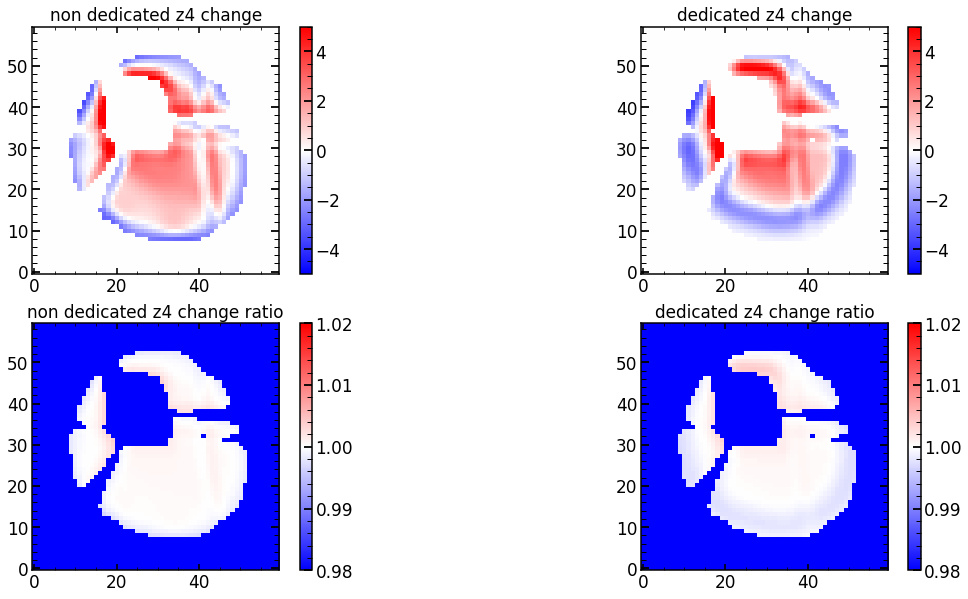

In [288]:
change_single=np.zeros((60,60))
change_single[list_of_flux_mask[0]]=np.array(uber_images_normalized_previous_best[0]-uber_M0_previous_best)[:1143]
change_single_ratio=np.zeros((60,60))
change_single_ratio[list_of_flux_mask[0]]=np.array(uber_images_normalized_previous_best[0]/uber_M0_previous_best)[:1143]

change_single_dedicated=np.zeros((60,60))
change_single_dedicated[list_of_flux_mask[0]]=np.array(uber_images_normalized_previous_best_dedicated[0]-uber_M0_previous_best_dedicated)[:1143]
change_single_dedicated_ratio=np.zeros((60,60))
change_single_dedicated_ratio[list_of_flux_mask[0]]=np.array(uber_images_normalized_previous_best_dedicated[0]/uber_M0_previous_best_dedicated)[:1143]

plt.figure(figsize=(20,10))
plt.subplot(221)
plt.title('non dedicated z4 change')
plt.imshow(change_single,cmap='bwr',vmin=-5,vmax=5)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(222)
plt.title('dedicated z4 change')
plt.imshow(change_single_dedicated,cmap='bwr',vmin=-5,vmax=5)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(223)
plt.title('non dedicated z4 change ratio')
plt.imshow(change_single_ratio,cmap='bwr',vmin=0.98,vmax=1.02)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(224)
plt.title('dedicated z4 change ratio')
plt.imshow(change_single_dedicated_ratio,cmap='bwr',vmin=0.98,vmax=1.02)
plt.colorbar(fraction=0.046, pad=0.04)

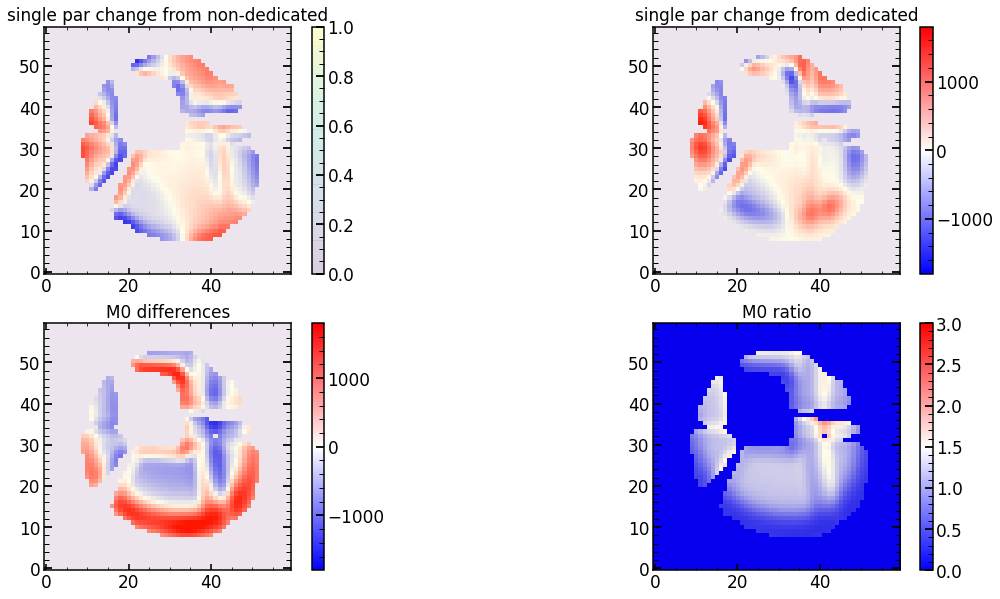

In [289]:
change_single=np.zeros((60,60))
change_single[list_of_flux_mask[0]]=array_of_wavefront_changes[:,12][:1143]

change_single_dedicated=np.zeros((60,60))
change_single_dedicated[list_of_flux_mask[0]]=array_of_wavefront_changes_dedicated[:,12][:1143]


difference_M=np.zeros((60,60))
difference_M[list_of_flux_mask[0]]=(uber_M0_previous_best-uber_M0_previous_best_dedicated)[:1143]

ratio_M=np.zeros((60,60))
ratio_M[list_of_flux_mask[0]]=(uber_M0_previous_best/uber_M0_previous_best_dedicated)[:1143]

ratio_M=np.zeros((60,60))
ratio_M[list_of_flux_mask[0]]=(uber_M0_previous_best_dedicated/uber_M0_previous_best)[:1143]

plt.figure(figsize=(20,10))
plt.subplot(221)
plt.title('single par change from non-dedicated')
plt.imshow(change_single,cmap='bwr',vmax=1800,vmin=-1800)
plt.imshow(list_of_flux_mask[0],alpha=0.1)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(222)
plt.title('single par change from dedicated')
plt.imshow(change_single_dedicated,cmap='bwr',vmax=1800,vmin=-1800)
plt.colorbar(fraction=0.046, pad=0.04)
plt.imshow(list_of_flux_mask[0],alpha=0.1)

plt.subplot(223)
plt.title('M0 differences')
plt.imshow(difference_M,cmap='bwr',vmax=1800,vmin=-1800)
plt.colorbar(fraction=0.046, pad=0.04)
plt.imshow(list_of_flux_mask[0],alpha=0.1)

plt.subplot(224)
plt.title('M0 ratio')
plt.imshow(ratio_M,cmap='bwr',vmax=3,vmin=0)
plt.colorbar(fraction=0.046, pad=0.04)
plt.imshow(list_of_flux_mask[0],alpha=0.1)

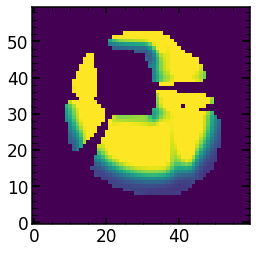

In [290]:
ratio_M_1=np.copy(ratio_M)
ratio_M_1[ratio_M>1]=1

ratio_M_2=np.copy(ratio_M)
ratio_M_2[ratio_M>2]=2

plt.imshow(ratio_M_1)

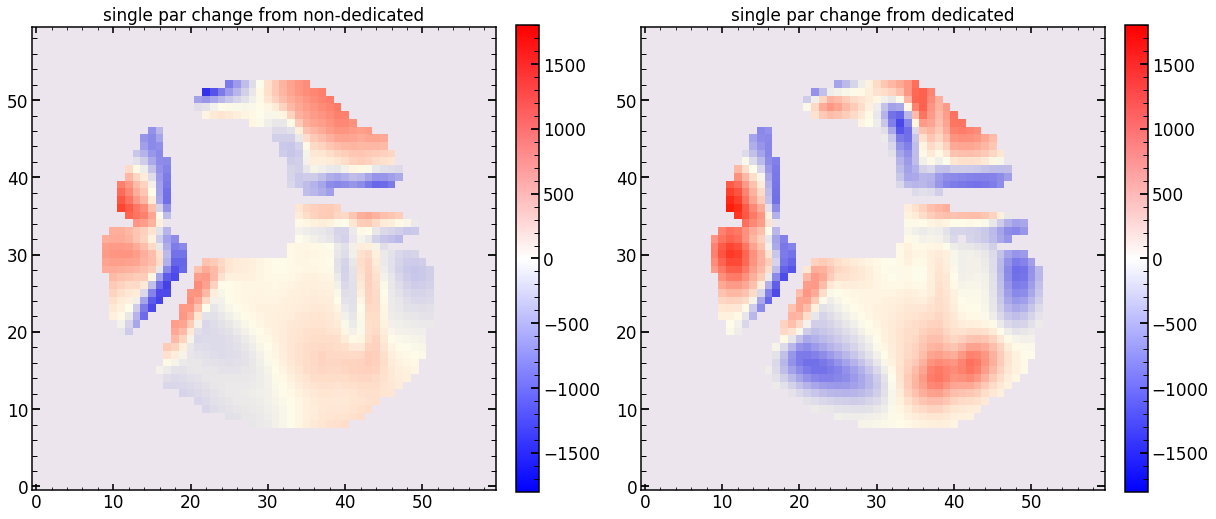

In [291]:

change_single=np.zeros((60,60))
change_single[list_of_flux_mask[0]]=(array_of_wavefront_changes[:,12])[:1143]*ratio_M_1[list_of_flux_mask[0]]

change_single_dedicated=np.zeros((60,60))
change_single_dedicated[list_of_flux_mask[0]]=array_of_wavefront_changes_dedicated[:,12][:1143]


plt.figure(figsize=(20,10))
plt.subplot(121)

plt.title('single par change from non-dedicated')
plt.imshow(change_single,cmap='bwr',vmax=1800,vmin=-1800)
plt.colorbar(fraction=0.046, pad=0.04)
plt.imshow(list_of_flux_mask[0],alpha=0.1)


plt.subplot(122)
plt.title('single par change from dedicated')
plt.imshow(change_single_dedicated,cmap='bwr',vmax=1800,vmin=-1800)
plt.colorbar(fraction=0.046, pad=0.04)
plt.imshow(list_of_flux_mask[0],alpha=0.1)

In [293]:
delta_single_change_0=(((uber_images_normalized_previous_best[12]/uber_M0_previous_best)-1)[:1143])
delta_single_change=np.zeros((60,60))
delta_single_change[list_of_flux_mask[0]]=delta_single_change_0

print(array_of_delta_parametrizations_None_previous_best[12])



delta_single_change_0_dedicated=(((uber_images_normalized_previous_best_dedicated[12]/uber_M0_previous_best_dedicated)-1)[:1143])
delta_single_change_dedicated=np.zeros((60,60))
delta_single_change_dedicated[list_of_flux_mask[0]]=delta_single_change_0_dedicated

print(array_of_delta_parametrizations_None_previous_best[12])

[0.00125]
[0.00125]


In [294]:
np.sum(delta_single_change)

0.001580953598022461

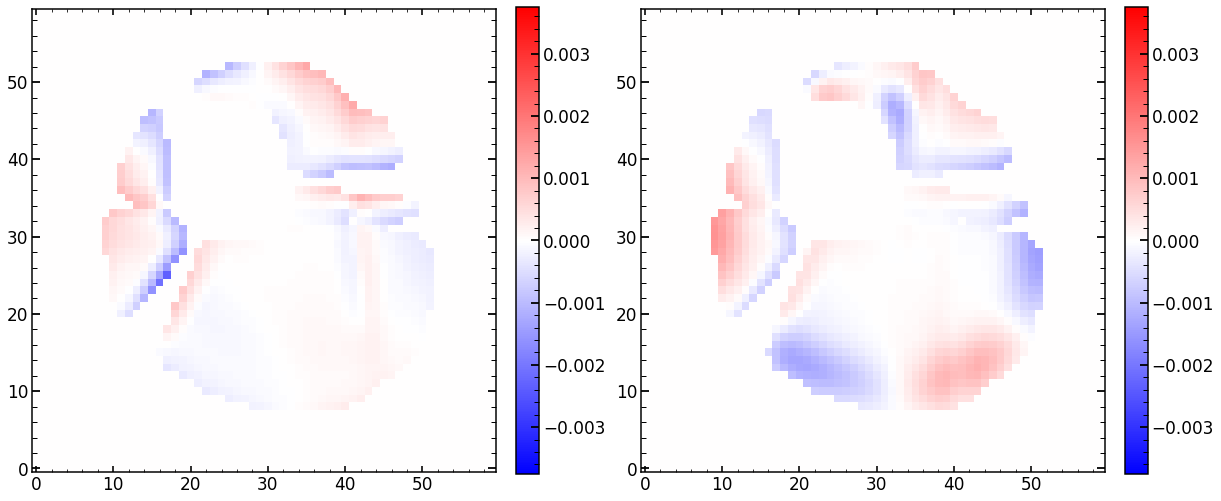

In [295]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(delta_single_change*ratio_M,cmap='bwr',vmax=3*0.00125,vmin=-3*0.00125)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(122)
plt.imshow(delta_single_change_dedicated,cmap='bwr',vmax=3*0.00125,vmin=-3*0.00125)
plt.colorbar(fraction=0.046, pad=0.04)

-5.9554865095350475
-5.723304430643718


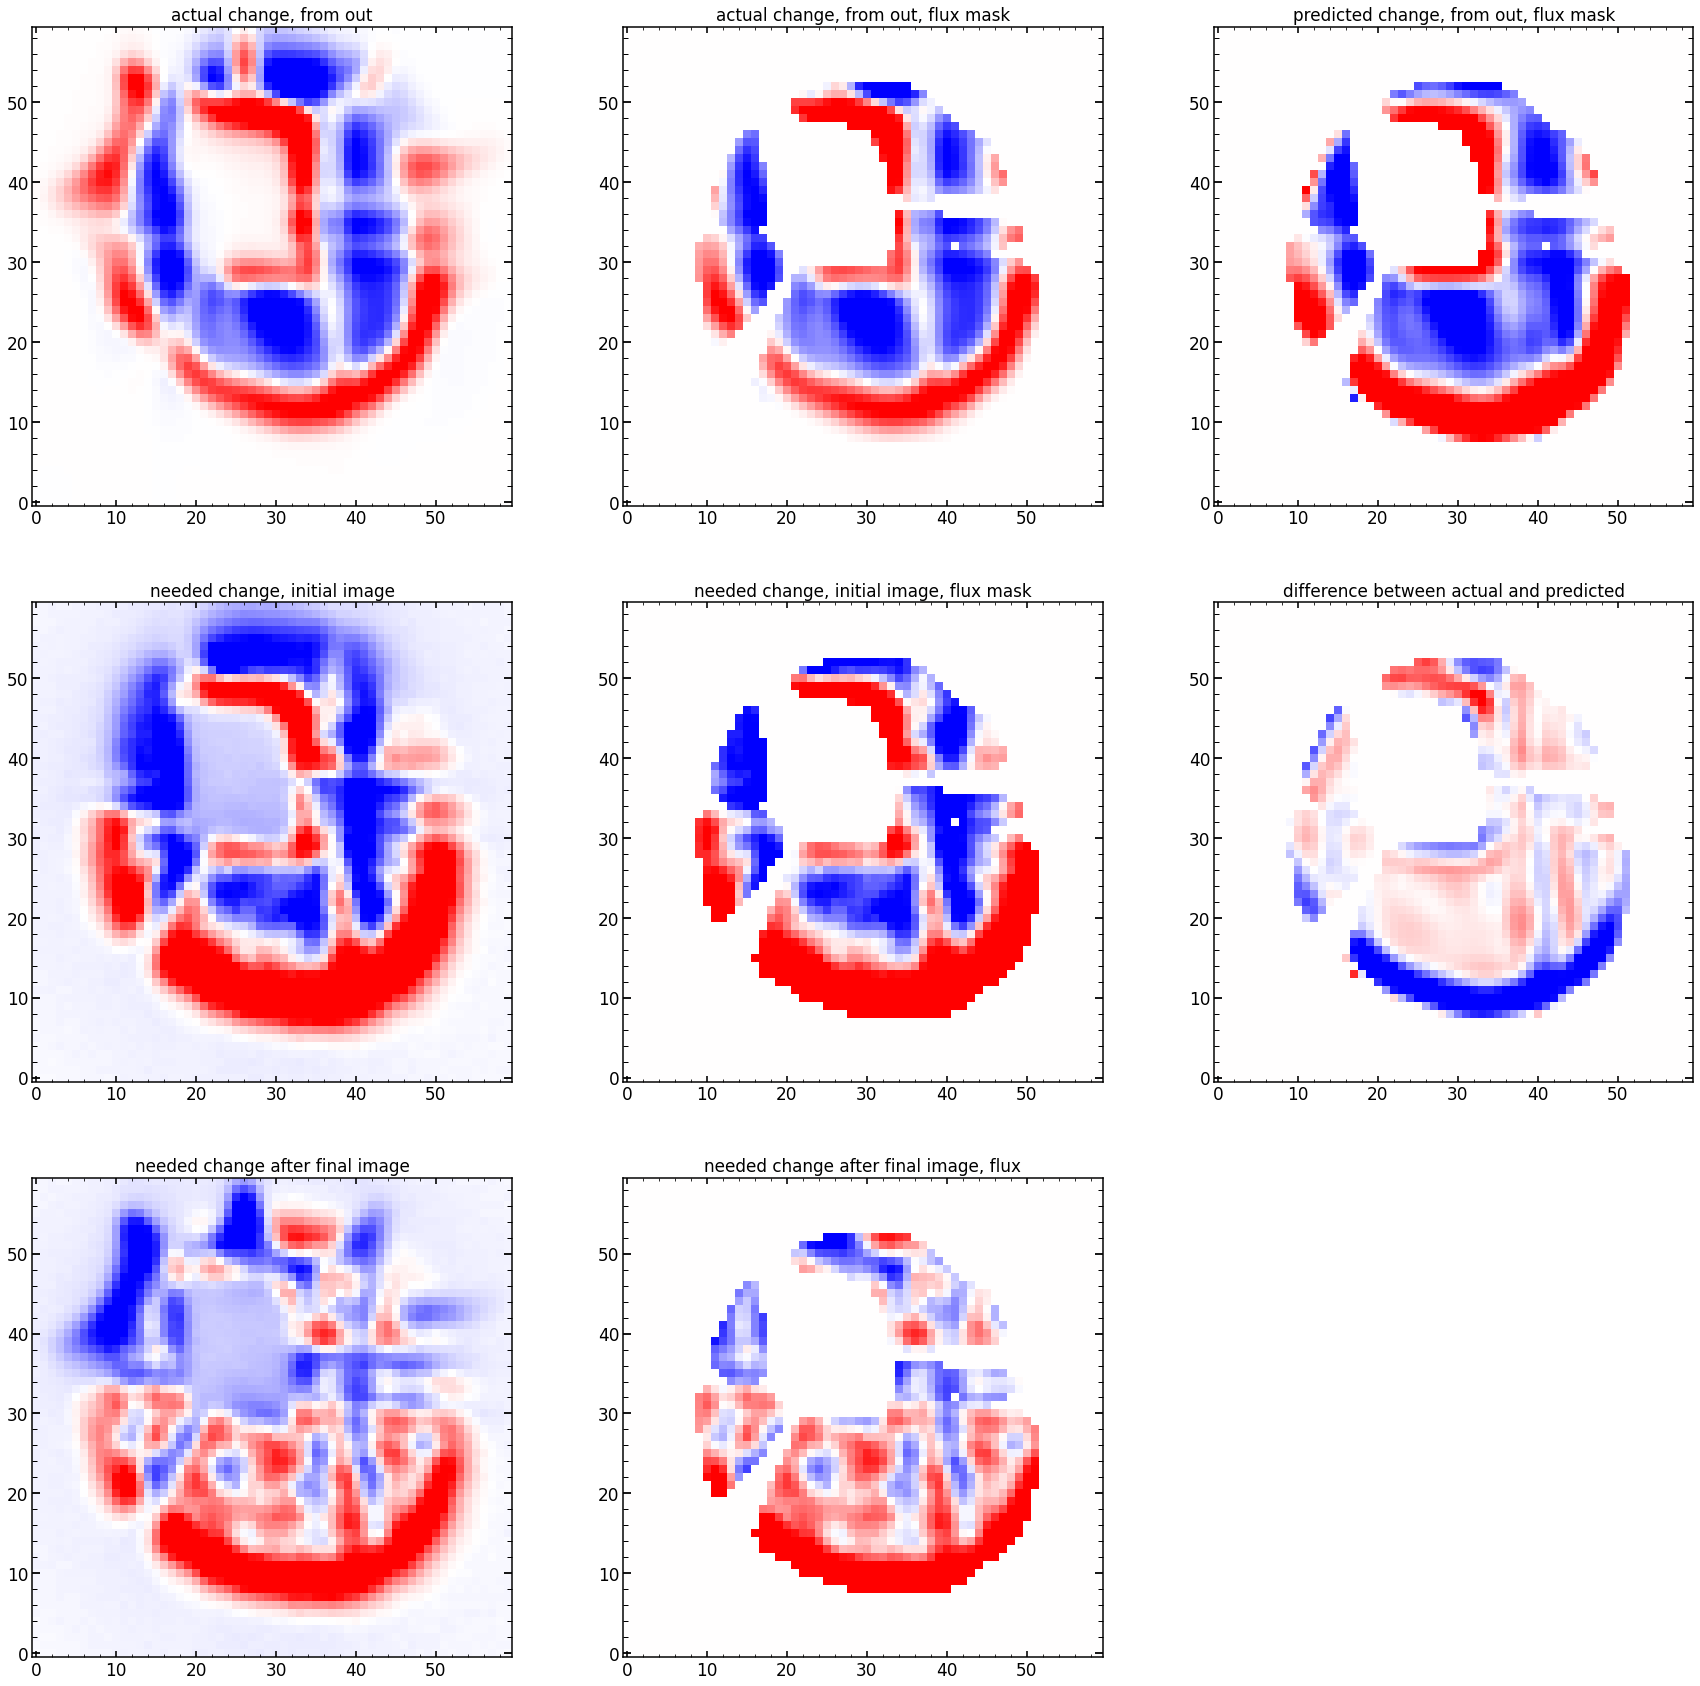

In [308]:
#which image
i=1

# how much did parameters change
actual_wavefront_change=np.concatenate(((out20[i][8]-out20[i][7])[:19*2],(out20[i][8]-out20[i][7])[19*2+23:]))

# change I expect from the changes of singular parameters
predicted_change=np.dot(array_of_wavefront_changes,actual_wavefront_change[:,None]).ravel()
predicted_change_0=np.zeros((60,60))
predicted_change_0[list_of_flux_mask[0]]=predicted_change[:1143]

# change I expect from the changes of singular parameters, from the dedicated effort 
predicted_change_dedicated=np.dot(array_of_wavefront_changes_dedicated,actual_wavefront_change[:,None]).ravel()
predicted_change_0_dedicated=np.zeros((60,60))
predicted_change_0_dedicated[list_of_flux_mask[0]]=predicted_change_dedicated[:1143]


# difference between final and initial image


actual_change_full=out20[i][6][0]-out20[i][5][0]

actual_change_flux_mask=np.zeros((60,60))
actual_change_flux_mask[list_of_flux_mask[0]]=actual_change_full[list_of_flux_mask[0]]

##############
initial_figure=out20[i][5][0]
needed_change=list_of_sci_images[0]-initial_figure

needed_change_flux_mask=np.zeros((60,60))
needed_change_flux_mask[list_of_flux_mask[0]]=needed_change[list_of_flux_mask[0]]


#################
final_figure=out20[i][6][0]
final_difference=list_of_sci_images[0]-final_figure
final_needed_change_flux_mask=np.zeros((60,60))
final_needed_change_flux_mask[list_of_flux_mask[0]]=final_difference[list_of_flux_mask[0]]


print(best_result0[0])
print(best_result0[1])

plt.figure(figsize=(30,30))

plt.subplot(331)
# actual change in particle 0
plt.title('actual change, from out')
plt.imshow(actual_change_full,cmap='bwr',vmax=800,vmin=-800)

plt.subplot(332)
# predicted change in particle 0
plt.title('actual change, from out, flux mask')
plt.imshow(actual_change_flux_mask,cmap='bwr',vmax=800,vmin=-800)

plt.subplot(333)
plt.title('predicted change, from out, flux mask')
plt.imshow(predicted_change_0,cmap='bwr',vmax=800,vmin=-800)


plt.subplot(334)
# needed change
plt.title('needed change, initial image')
plt.imshow(list_of_sci_images[0]-initial_figure,cmap='bwr',vmax=800,vmin=-800)



plt.subplot(335)
# needed change flux
plt.title('needed change, initial image, flux mask')
plt.imshow(needed_change_flux_mask,cmap='bwr',vmax=800,vmin=-800)

#difference between actual and predicted image
plt.subplot(336)
plt.title('difference between actual and predicted')
plt.imshow(actual_change_flux_mask-predicted_change_0,cmap='bwr',vmax=800,vmin=-800)

# needed change after final image
plt.subplot(337)
plt.title('needed change after final image')
plt.imshow(list_of_sci_images[0]-final_figure,cmap='bwr',vmax=800,vmin=-800)


# needed change flux after final image
plt.subplot(338)
plt.title('needed change after final image, flux')
plt.imshow(final_needed_change_flux_mask,cmap='bwr',vmax=800,vmin=-800)


[-7.8825157   0.03305758  0.49241792 -0.91129426  0.2342229 ]
[-7.8825157   0.03305758  0.49241792 -0.91129426  0.2342229 ]


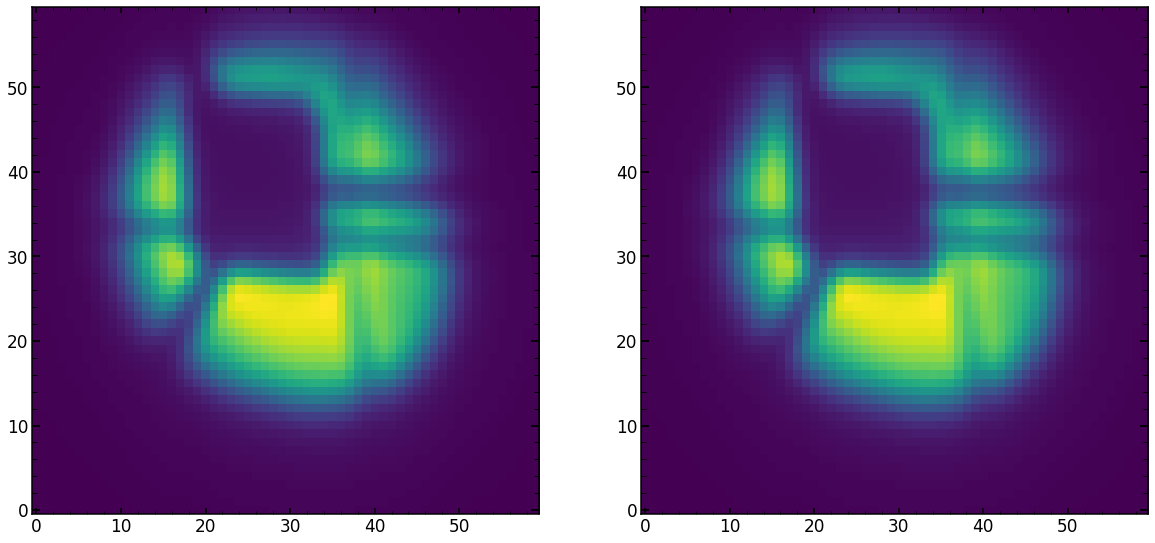

In [297]:
i=1
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.imshow(out20[i][5][0])

plt.subplot(122)
plt.imshow(best_result_from_Tokovinin_5[5][0])


print(out20[i][7][0:5])
print(best_result_from_Tokovinin_5[7][0:5])

In [281]:
out20[i][-1]

array([[-10.55950444,  -9.67599059],
       [ -6.41199078,  -2.2058663 ],
       [ -2.52495983, -12.74554173],
       [  1.00000738,  -2.99984033],
       [ -3.52851925,  -4.80982311],
       [  0.66881061,   2.85761783],
       [  4.0595144 ,  -3.7706548 ],
       [  8.39258311,   3.90861787],
       [  3.65336405,  -6.82852696]])

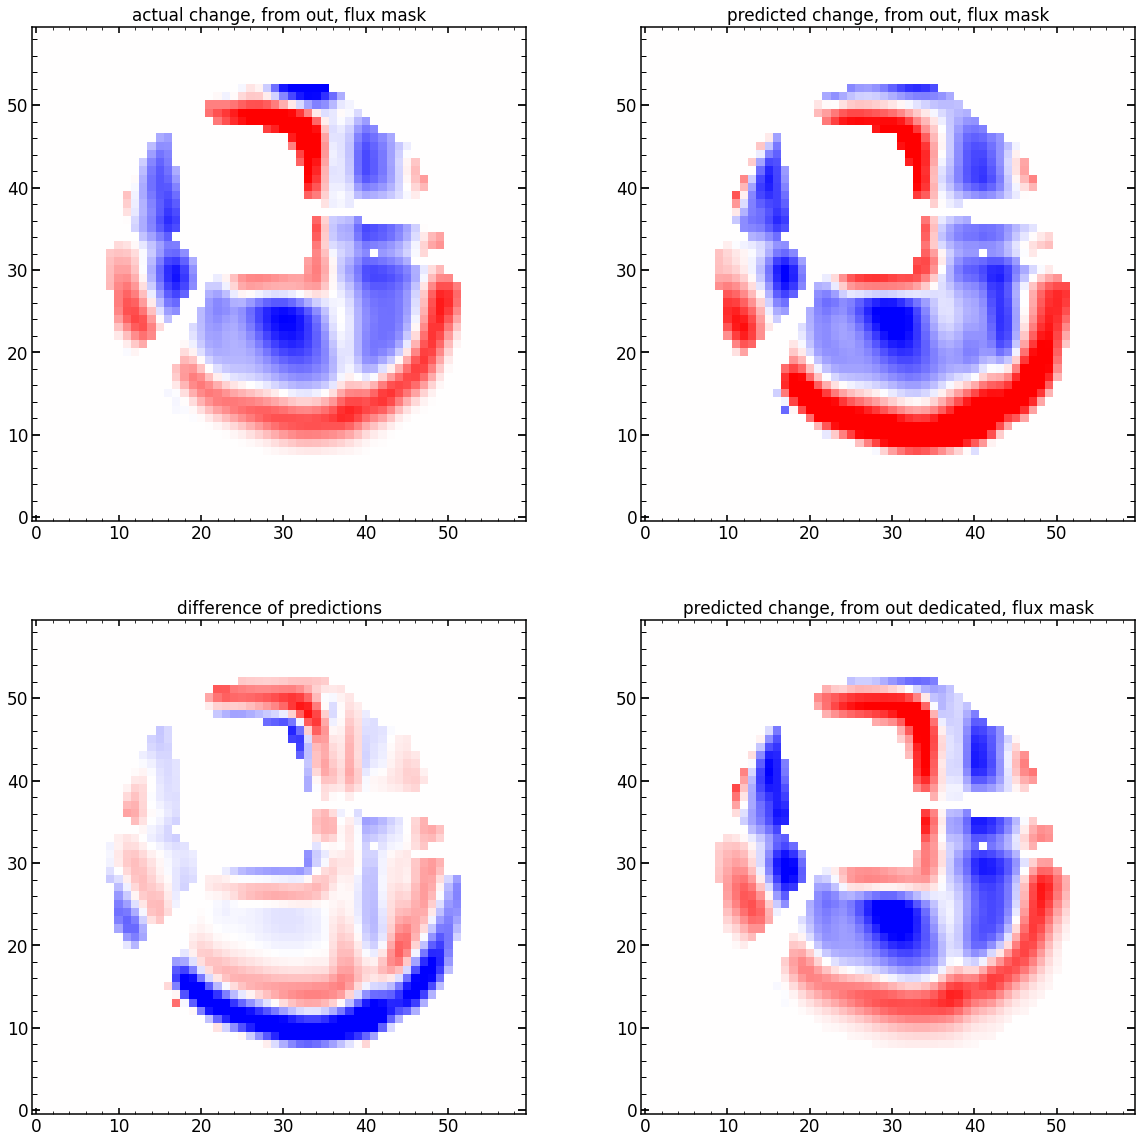

In [298]:
plt.figure(figsize=(20,20))
plt.subplot(221)
# predicted change in particle 0
plt.title('actual change, from out, flux mask')
plt.imshow(actual_change_flux_mask,cmap='bwr',vmax=1200,vmin=-1200)

plt.subplot(222)
plt.title('predicted change, from out, flux mask')
plt.imshow(predicted_change_0,cmap='bwr',vmax=1200,vmin=-1200)

plt.subplot(223)
plt.title('difference of predictions')
plt.imshow(predicted_change_0_dedicated-predicted_change_0,cmap='bwr',vmax=1200,vmin=-1200)

plt.subplot(224)
plt.title('predicted change, from out dedicated, flux mask')
plt.imshow(predicted_change_0_dedicated,cmap='bwr',vmax=1200,vmin=-1200)

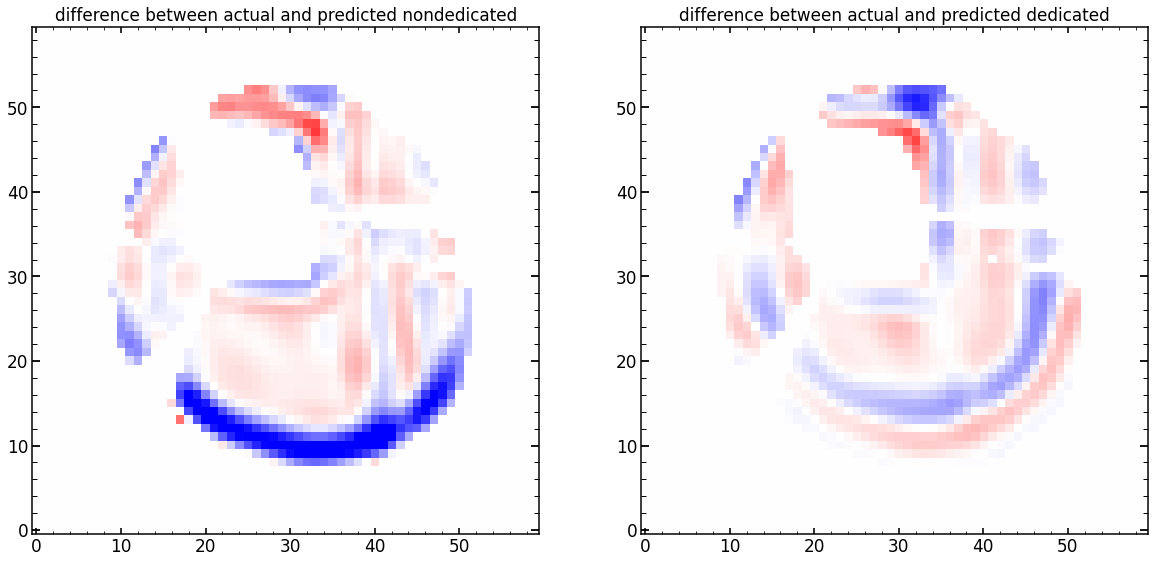

In [309]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.title('difference between actual and predicted nondedicated')
plt.imshow(actual_change_flux_mask-predicted_change_0,cmap='bwr',vmax=1200,vmin=-1200)
plt.subplot(122)

plt.title('difference between actual and predicted dedicated')
plt.imshow(actual_change_flux_mask-predicted_change_0_dedicated,cmap='bwr',vmax=1200,vmin=-1200)

-7.979043624752941

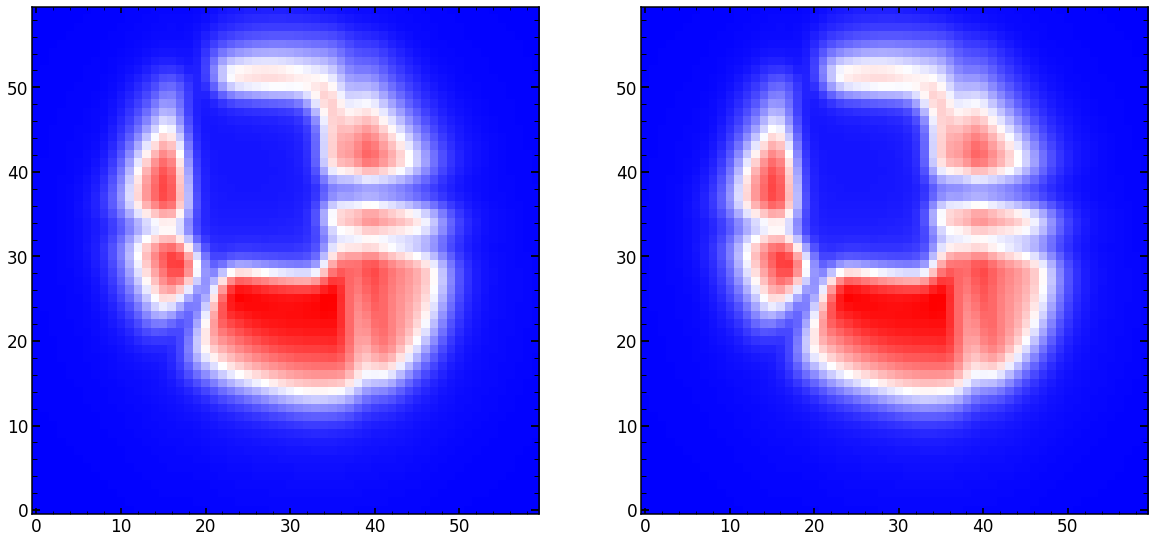

In [300]:
i=1
plt.figure(figsize=(20,10))
plt.subplot(121)

plt.imshow(initial_figure,cmap='bwr')

plt.subplot(122)
plt.imshow(out20[i][5][0],cmap='bwr')

out20[i][8][0]

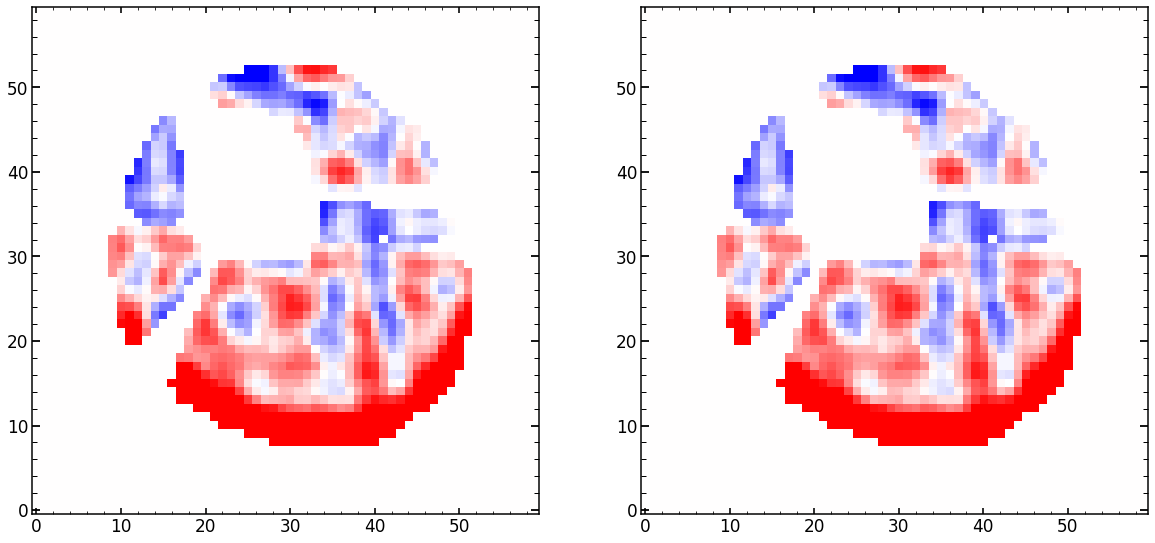

In [301]:
plt.figure(figsize=(20,10))
plt.subplot(121)

plt.imshow(needed_change_flux_mask-actual_change_flux_mask,cmap='bwr',vmax=800,vmin=-800)

plt.subplot(122)
plt.imshow(final_needed_change_flux_mask,cmap='bwr',vmax=800,vmin=-800)

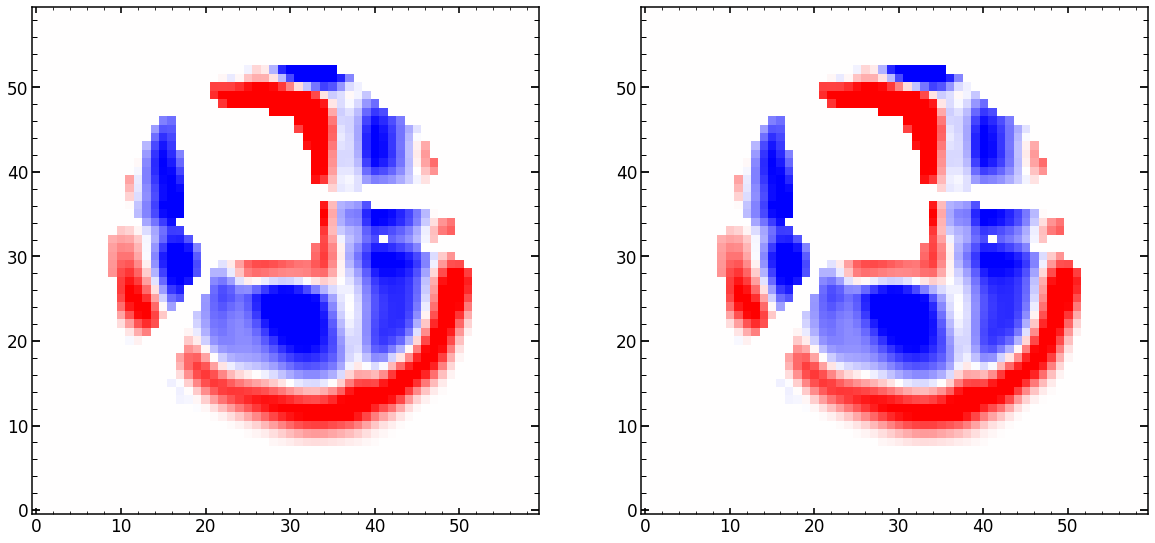

In [302]:
plt.figure(figsize=(20,10))
plt.subplot(121)

plt.imshow(actual_change_flux_mask,cmap='bwr',vmax=800,vmin=-800)

plt.subplot(122)
plt.imshow(needed_change_flux_mask-final_needed_change_flux_mask,cmap='bwr',vmax=800,vmin=-800)

In [303]:
initial_figure_from_1st_image=main_body_of_best_result[5][0]
final_figure_from_1st_image=main_body_of_best_result[6][0]
initial_figure

array([[23.765503, 25.153244, 26.543234, ..., 30.718159, 29.116806,
        27.6076  ],
       [24.915411, 26.395117, 27.879974, ..., 32.404182, 30.667175,
        29.035728],
       [26.07504 , 27.65013 , 29.233816, ..., 34.142864, 32.261143,
        30.49983 ],
       ...,
       [32.732533, 34.869408, 37.054974, ..., 38.78799 , 36.38057 ,
        34.17682 ],
       [31.214085, 33.210823, 35.24346 , ..., 36.873108, 34.61815 ,
        32.55023 ],
       [29.67929 , 31.541986, 33.430534, ..., 34.936813, 32.825676,
        30.887005]], dtype=float32)

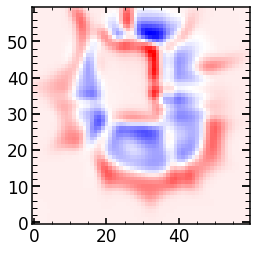

In [304]:
plt.imshow(final_figure_from_1st_image-initial_figure,cmap='bwr')

In [311]:
paramCount=100
(0.5 + np.random.uniform(0,1,size=paramCount))/2*1.193

array([0.75492696, 0.72993067, 0.44827592, 0.65510329, 0.48367866,
       0.49027198, 0.42072113, 0.60425065, 0.49547633, 0.40489607,
       0.37950663, 0.82102061, 0.45599879, 0.68128806, 0.37685579,
       0.81918501, 0.31402685, 0.41682285, 0.42726273, 0.73658775,
       0.41387967, 0.53855422, 0.72561773, 0.81357645, 0.60613749,
       0.81771917, 0.34570418, 0.64890457, 0.45260618, 0.36290402,
       0.47420701, 0.86682843, 0.50192515, 0.81695989, 0.50004566,
       0.76078837, 0.80337951, 0.31647546, 0.4817443 , 0.310799  ,
       0.6712762 , 0.44085   , 0.77803725, 0.41438422, 0.71088243,
       0.48922662, 0.37263804, 0.82388429, 0.75249577, 0.78968033,
       0.54334296, 0.49243878, 0.68331314, 0.42995771, 0.70613697,
       0.82396036, 0.41970463, 0.74398338, 0.66519033, 0.89218918,
       0.78950556, 0.86933166, 0.66209829, 0.53967383, 0.38777291,
       0.42001929, 0.44029856, 0.66621048, 0.54588407, 0.30371727,
       0.74964047, 0.86083626, 0.41534744, 0.86262305, 0.64933

In [306]:
array([   -7.8825157 ,     0.03305758,     0.49241792,    -0.91129426,
           0.2342229 ,    -0.54302017,    -0.01364976,    -0.34325149,
          -0.06352654,     0.40795935,     0.01064555,    -0.44396466,
           0.00450309,    -0.57982209,    -0.06671459,     0.54374951,
          -0.00864246,     0.01886295,     0.00089042,     0.20247791,
           0.01402033,    -0.04694434,     0.01045948,     0.01222624,
           0.00874718,     0.03680648,    -0.00906852,     0.03962365,
          -0.01035716,     0.0319801 ,     0.00243948,    -0.03244641,
           0.01081932,    -0.03921772,     0.00747744,     0.01216259,
          -0.0274368 ,     0.03708531,     0.74462689,     0.0812034 ,
          -0.0868288 ,     0.03834348,     0.06469483,     0.08329746,
           0.09677616,     0.00237369,     0.65310164,     3.48658281,
          -0.17607945,     0.13462112,     0.76565118,     0.02480677,
           0.5659987 ,     1.09607081,     0.75689404, 72801.39262911,
           2.35753197,     0.00341322,     0.46153212,     1.88657571,
           0.98350389,     0.00174632,    -0.01511988,     0.00168603,
          -0.01584725,     0.00229983,    -0.00785104,    -0.00124334,
           0.00851931,     0.00143488,     0.0022975 ,     0.00128037,
          -0.000155  ,     0.00072586,    -0.01416621,    -0.00198463,
           0.00245813,     0.00959034,    -0.01031893,     0.00038837,
           0.01306438,     0.0030908 ,     0.00319384,     0.00305834,
          -0.02084817,     0.00048789,     0.00160031,    -0.00283995,
           0.01114524,    -0.00086007,     0.00307501,     0.00170246,
          -0.00239154,     0.00263968,    -0.00073899,     0.00002547,
           0.00217737,    -0.00343051,     0.01019274,     0.00481108,
          -0.00834874,    -0.00196319,     0.00685014,    -0.00490918,
          -0.01084985,     0.00127341,    -0.00627397,    -0.00052602,
          -0.01719912,    -0.00058612,    -0.00185252,    -0.000253  ,
           0.00176255,    -0.00248642,    -0.0016823 ,     0.00042267,
          -0.00583862,     0.00281019,    -0.01018753,    -0.00236892,
           0.00407194,    -0.00156917,     0.00138039,    -0.0028367 ,
           0.00124819,     0.00222119,     0.00080149,    -0.005737  ,
          -0.00105242])

NameError: name 'array' is not defined

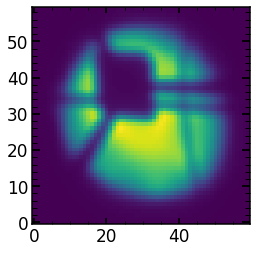

In [307]:
plt.imshow(best_result0[5][0])

## initial model, is it better via change or ratio - it is mostly the same

### initial model 

In [87]:
par_change_all=best_result0[8]-best_result0[7]
actual_wavefront_change=np.concatenate((par_change_all[:19*2],par_change_all[19*2+23:]))

In [91]:
# change I expect from the changes of singular parameters
predicted_change_dedicated=np.dot(array_of_wavefront_changes,actual_wavefront_change[:,None]).ravel()
predicted_change_0=np.zeros((60,60))
predicted_change_0[list_of_flux_mask[0]]=predicted_change_dedicated[:1143]

actual_change_0_flux=np.zeros((60,60))
actual_change_0=best_result0[6][0]-best_result0[5][0]
actual_change_0_flux[list_of_flux_mask[0]]=actual_change_0[list_of_flux_mask[0]]


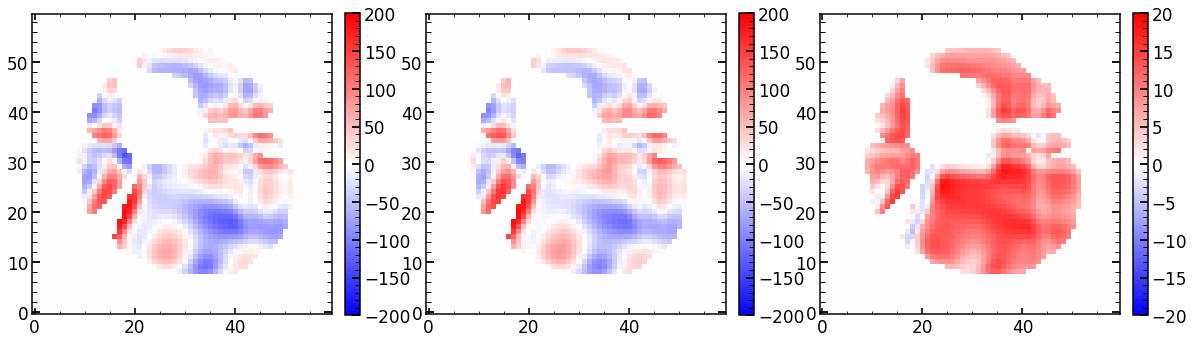

In [100]:
plt.figure(figsize=(20,10))
plt.subplot(131)

plt.imshow(predicted_change_0,cmap='bwr',vmax=200,vmin=-200)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.imshow(actual_change_0_flux,cmap='bwr',vmax=200,vmin=-200)
plt.colorbar(fraction=0.046, pad=0.04)


plt.subplot(133)
plt.imshow(actual_change_0_flux-predicted_change_0,cmap='bwr',vmax=20,vmin=-20)
plt.colorbar(fraction=0.046, pad=0.04)

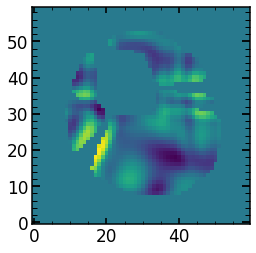

In [92]:
plt.imshow(predicted_change_0)

In [113]:
# ratio of the change change 
array_of_wavefront_changes[:,0][:1153]/uber_M0_previous_best[:1153]

array([-0.94527266, -0.87870797, -0.81805999, ..., -0.28574231,
       -0.34801374, -0.3151439 ])

In [118]:
array_of_wavefront_changes[:,1][:1153]/uber_M0_previous_best[:1153]

array([0.23603402, 0.21925272, 0.20395584, ..., 0.08079256, 0.09861076,
       0.08932824])

In [120]:
array_of_wavefront_changes_ratio=np.transpose(array_of_wavefront_changes[:1153]/uber_M0_previous_best[:1153][:,None])

In [124]:
array_of_wavefront_changes_ratio.shape

(106, 1153)

In [126]:
actual_wavefront_change

array([-0.00367245,  0.02183245, -0.04386204,  0.03516775, -0.03423949,
        0.0314706 ,  0.00231845,  0.00626276, -0.00070134,  0.01221791,
        0.00391214,  0.01077113, -0.01503768,  0.01929032, -0.00051054,
        0.00493127,  0.01011809,  0.00645242,  0.01128888,  0.00584072,
        0.00577654,  0.00398069, -0.01143672,  0.02233373, -0.00368618,
        0.01144915, -0.00247151,  0.00194253,  0.00246247, -0.00011388,
       -0.00034826,  0.00123794, -0.00608317,  0.01131962, -0.00265433,
        0.01482509,  0.00300846,  0.00345727,  0.00135668,  0.00076387,
        0.00225364, -0.00102715, -0.00033095,  0.00049345,  0.00041171,
       -0.00153447, -0.00085994,  0.00027332,  0.00188098,  0.0002308 ,
       -0.00312899,  0.00168374,  0.00111455,  0.00204254, -0.00308663,
        0.00836513,  0.00198252,  0.00232607, -0.00151968, -0.00055702,
        0.00064368, -0.00178369,  0.00082897, -0.0013149 ,  0.00007355,
       -0.00063818, -0.00018484,  0.000368  , -0.000904  ,  0.00

In [141]:
# change I expect from the changes of singular parameters
predicted_change_dedicated_ratio=np.dot(actual_wavefront_change,array_of_wavefront_changes_ratio).ravel()
predicted_change_dedicated_ratio_0=np.zeros((60,60))
predicted_change_dedicated_ratio_0[list_of_flux_mask[0]]=predicted_change_dedicated_ratio[:1143]*uber_M0_previous_best[:1143]

actual_change_0_flux=np.zeros((60,60))
actual_change_0=best_result0[6][0]-best_result0[5][0]
actual_change_0_flux[list_of_flux_mask[0]]=actual_change_0[list_of_flux_mask[0]]

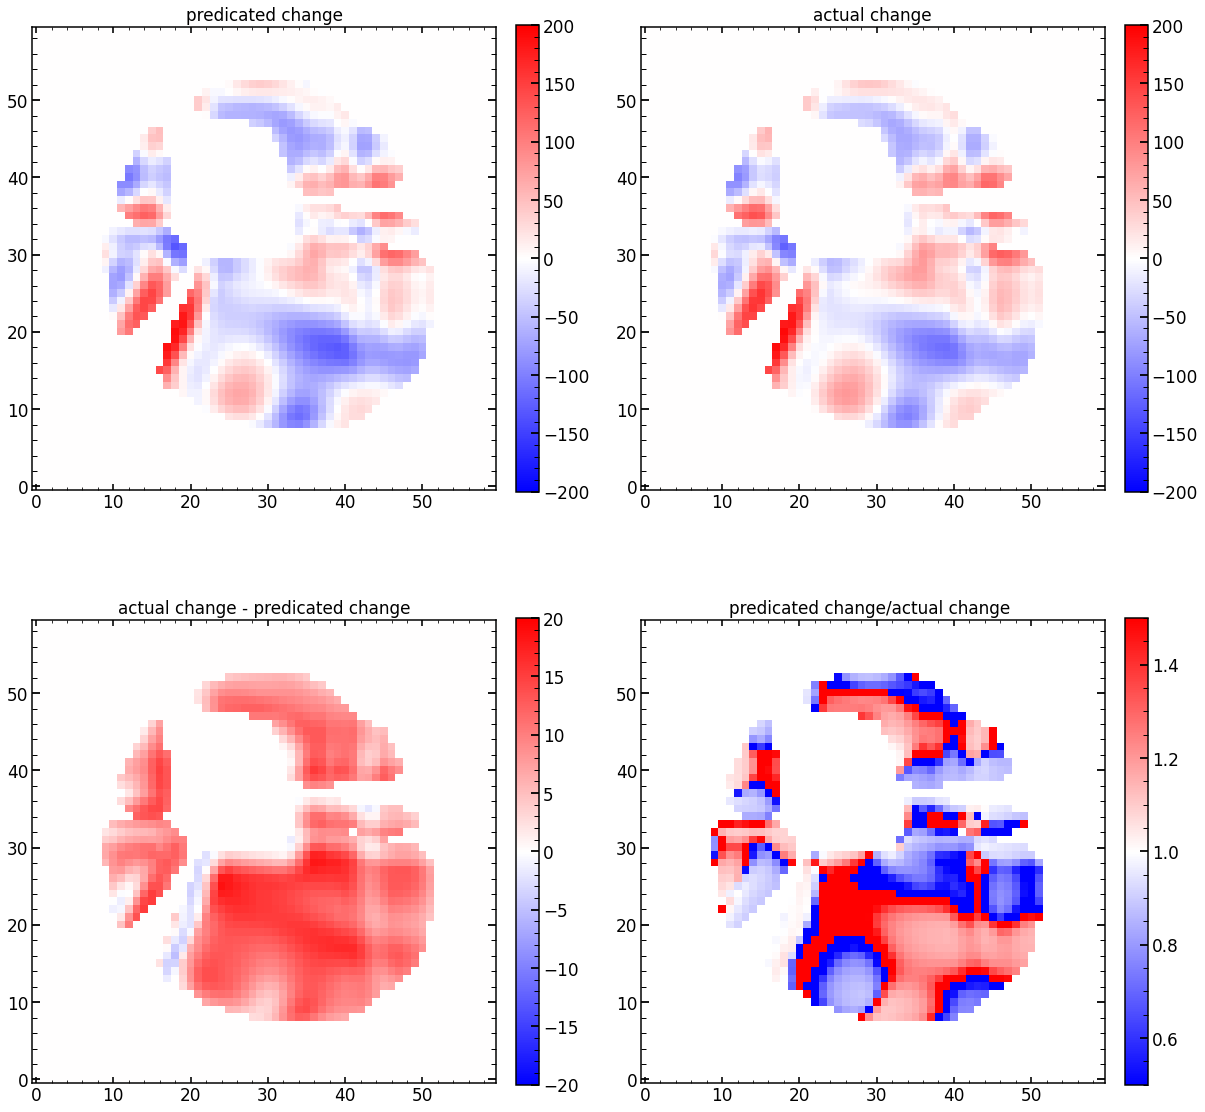

In [167]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.title('predicated change')
plt.imshow(predicted_change_dedicated_ratio_0,cmap='bwr',vmax=200,vmin=-200)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(222)
plt.title('actual change')
plt.imshow(actual_change_0_flux,cmap='bwr',vmax=200,vmin=-200)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(223)
plt.title('actual change - predicated change')
plt.imshow(actual_change_0_flux-predicted_change_dedicated_ratio_0,cmap='bwr',vmax=20,vmin=-20)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(224)
plt.title('predicated change/actual change ')
plt.imshow(predicted_change_dedicated_ratio_0/actual_change_0_flux,cmap='bwr',vmax=1.5,vmin=0.5)
plt.colorbar(fraction=0.046, pad=0.04)

In [158]:
print(np.sum(actual_change_0_flux))
print(np.mean(actual_change_0_flux[list_of_flux_mask[0]]))

4886.253601074219
4.274937533748223


In [160]:
print(np.sum(predicted_change_dedicated_ratio_0))
print(np.mean(predicted_change_dedicated_ratio_0[list_of_flux_mask[0]]))

-5979.100836556248
-5.23105934956802


In [164]:

print((predicted_change_dedicated_ratio_0/actual_change_0_flux)[list_of_flux_mask[0]])

predicted_change_dedicated_ratio_0/actual_change_0_flux

[2.84582783 1.21609456 1.12254578 ... 0.67772749 0.29628255 2.74598024]


array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [165]:
np.mean((predicted_change_dedicated_ratio_0/actual_change_0_flux)[list_of_flux_mask[0]])

1.0926343708476458

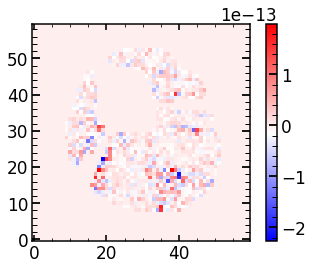

In [148]:
plt.imshow(predicted_change_dedicated_ratio_0-predicted_change_0,cmap='bwr')
plt.colorbar()

### second image 

#### via ratios 

In [182]:
array_of_wavefront_changes_dedicated[:,0][:1153]/uber_M0_previous_best_dedicated[:1153]

array([-0.41768008, -0.42616361, -0.42988662, ..., -0.34793099,
       -0.32411983, -0.70647702])

In [183]:
array_of_wavefront_changes_ratio_dedicated=np.transpose(array_of_wavefront_changes_dedicated[:1153]/uber_M0_previous_best_dedicated[:1153][:,None])

In [190]:
par_change_all_dedicated=best_result_from_Tokovinin_5[8]-best_result_from_Tokovinin_5[7]
actual_wavefront_change_dedicated=np.concatenate((par_change_all_dedicated[:19*2],par_change_all_dedicated[19*2+23:]))

In [192]:
# change I expect from the changes of singular parameters
predicted_change_dedicated_ratio=np.dot(actual_wavefront_change_dedicated,array_of_wavefront_changes_ratio_dedicated).ravel()
predicted_change_dedicated_ratio_0=np.zeros((60,60))
predicted_change_dedicated_ratio_0[list_of_flux_mask[0]]=predicted_change_dedicated_ratio[:1143]*uber_M0_previous_best_dedicated[:1143]

actual_change_0_flux_dedicated=np.zeros((60,60))
actual_change_0_dedicated=best_result_from_Tokovinin_5[6][0]-best_result_from_Tokovinin_5[5][0]
actual_change_0_flux_dedicated[list_of_flux_mask[0]]=actual_change_0_dedicated[list_of_flux_mask[0]]

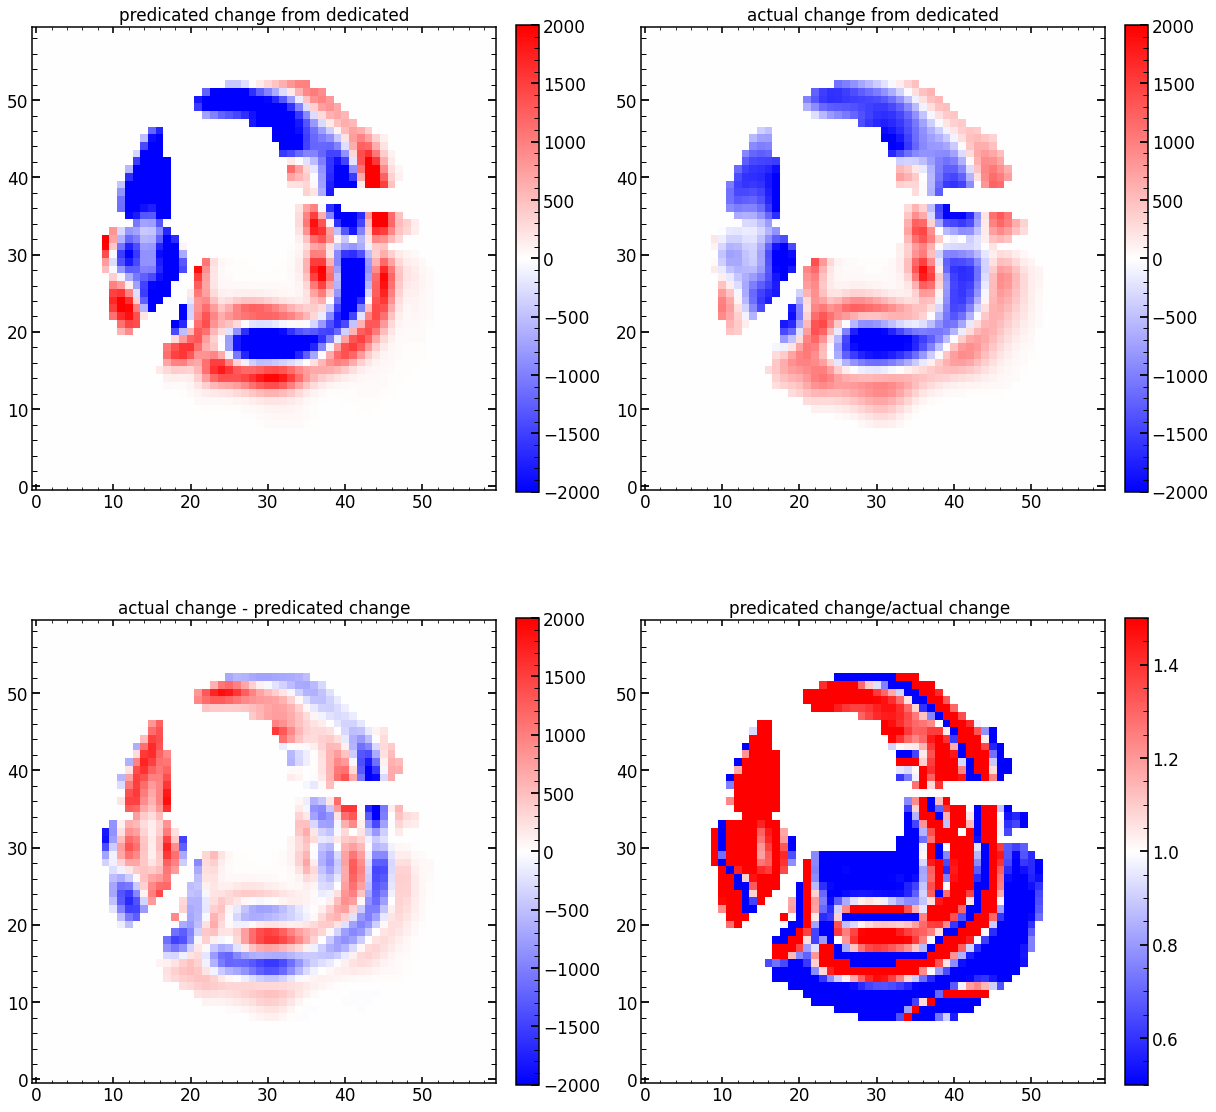

In [198]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.title('predicated change from dedicated')
plt.imshow(predicted_change_dedicated_ratio_0,cmap='bwr',vmax=2000,vmin=-2000)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(222)
plt.title('actual change from dedicated')
plt.imshow(actual_change_0_flux_dedicated,cmap='bwr',vmax=2000,vmin=-2000)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(223)
plt.title('actual change - predicated change')
plt.imshow(actual_change_0_flux_dedicated-predicted_change_dedicated_ratio_0,cmap='bwr',vmax=2000,vmin=-2000)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(224)
plt.title('predicated change/actual change ')
plt.imshow(predicted_change_dedicated_ratio_0/actual_change_0_flux_dedicated,cmap='bwr',vmax=1.5,vmin=0.5)
plt.colorbar(fraction=0.046, pad=0.04)

#### via change 

In [226]:
array_of_wavefront_changes_dedicated[:,0][:1153]

array([-10.30502319, -10.83679199, -11.20834351, ..., -10.5178833 ,
        -8.87680054, -32.54699707])

In [182]:
array_of_wavefront_changes_dedicated[:,0][:1153]/uber_M0_previous_best_dedicated[:1153]

array([-0.41768008, -0.42616361, -0.42988662, ..., -0.34793099,
       -0.32411983, -0.70647702])

In [183]:
array_of_wavefront_changes_ratio_dedicated=np.transpose(array_of_wavefront_changes_dedicated[:1153]

In [203]:
par_change_all_dedicated=best_result_from_Tokovinin_5[8]-best_result_from_Tokovinin_5[7]
actual_wavefront_change_dedicated=np.concatenate((par_change_all_dedicated[:19*2],par_change_all_dedicated[19*2+23:]))

In [223]:
array_of_wavefront_changes_dedicated.shape

(5057, 106)

In [225]:
array_of_wavefront_changes_dedicated[:,0][0:5]

array([-10.30502319, -10.83679199, -11.20834351, -11.42807007,
       -11.3319397 ])

In [236]:
# change I expect from the changes of singular parameters
predicted_change_dedicated=np.dot(array_of_wavefront_changes_dedicated,actual_wavefront_change_dedicated[:,None]).ravel()
predicted_change_dedicated_0=np.zeros((60,60))
predicted_change_dedicated_0[list_of_flux_mask[0]]=predicted_change_dedicated[:1143]



actual_change_0_flux_dedicated=np.zeros((60,60))
actual_change_0_dedicated=best_result_from_Tokovinin_5[6][0]-best_result_from_Tokovinin_5[5][0]
actual_change_0_flux_dedicated[list_of_flux_mask[0]]=actual_change_0_dedicated[list_of_flux_mask[0]]

In [260]:
actual_wavefront_change_dedicated[0:5]

array([-0.02296041, -1.29475315, -0.65396748, -1.58326897, -0.22245096])

In [261]:
actual_wavefront_change[0:5]

array([-0.09652792, -0.45882299,  0.16198556,  0.01088182, -0.02373699])

In [237]:
predicted_change_dedicated.shape

(5057,)

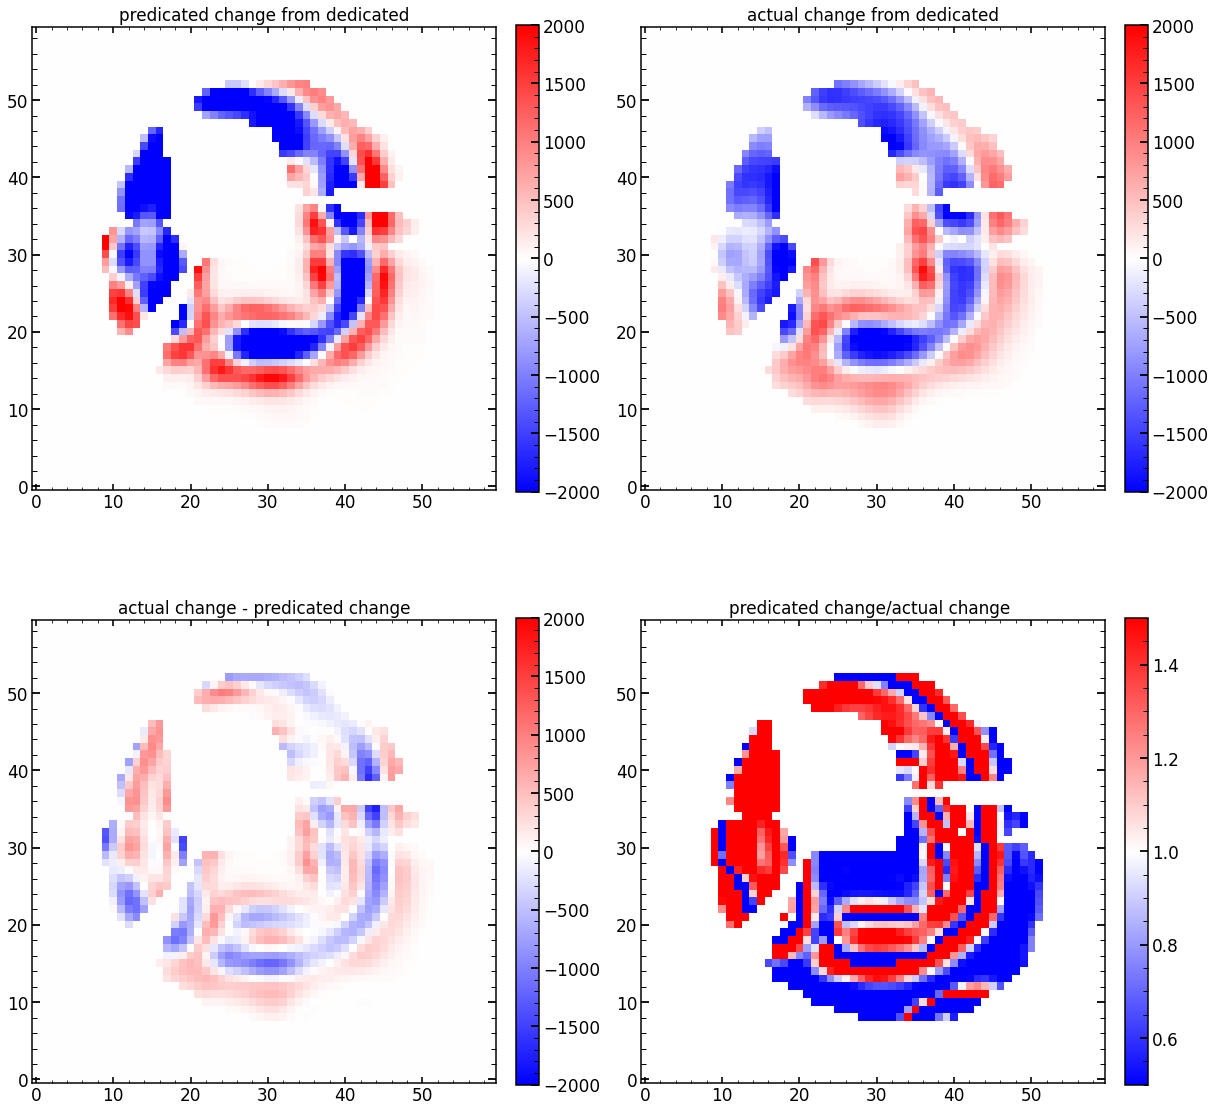

In [246]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.title('predicated change from dedicated')
plt.imshow(predicted_change_dedicated_0,cmap='bwr',vmax=2000,vmin=-2000)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(222)
plt.title('actual change from dedicated')
plt.imshow(actual_change_0_flux_dedicated,cmap='bwr',vmax=2000,vmin=-2000)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(223)
plt.title('actual change - predicated change')
plt.imshow(actual_change_0_flux_dedicated-0.75*predicted_change_dedicated_0,cmap='bwr',vmax=2000,vmin=-2000)
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(224)
plt.title('predicated change/actual change ')
plt.imshow(predicted_change_dedicated_0/actual_change_0_flux_dedicated,cmap='bwr',vmax=1.5,vmin=0.5)
plt.colorbar(fraction=0.046, pad=0.04)

In [245]:
np.mean(actual_change_0_flux_dedicated-0.75*predicted_change_dedicated_0)

2.3078274777218133

In [ ]:
# why is it different

In [230]:
print(predicted_change_dedicated.shape)
predicted_change_dedicated

(5057,)


array([6.46906234, 8.08072384, 9.52347966, ..., 5.17016093, 6.41256048,
       5.01545063])

In [234]:
print(predicted_change_dedicated_ratio.shape)
predicted_change_dedicated_ratio

(1153,)


array([0.48769076, 0.8702017 , 1.25896865, ..., 0.34385455, 0.19967145,
       0.91865239])

In [216]:
uber_M0_previous_best_dedicated[0:5]

array([24.672049, 25.428713, 26.07279 , 26.519861, 26.66901 ],
      dtype=float32)

In [212]:
array_of_wavefront_changes_dedicated[0][0:5]

array([-10.30502319,   2.58883145,  -3.4311395 ,   0.84960688,
         9.59086941])

In [214]:
array_of_wavefront_changes_ratio_dedicated[0][0:5]

array([-0.41768008, -0.42616361, -0.42988662, -0.43092496, -0.4249104 ])

In [219]:
array_of_wavefront_changes_ratio_dedicated[0:5][:,0]*uber_M0_previous_best_dedicated[0:5]

array([-10.30502319,   2.66822803,  -3.6259405 ,   0.91323817,
        10.36715671])

# error in out2 in May06 run 

In [162]:
out20=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/May0621/out20.npy',allow_pickle=True)
out21=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/May0621/out21.npy',allow_pickle=True)
out22=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/May0621/out22.npy',allow_pickle=True)

In [163]:
print(out20.shape)
print(out21.shape)
print(out22.shape)

(480, 15)
(480, 15)
(480, 15)


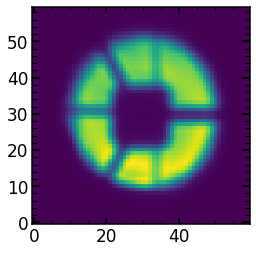

In [164]:
plt.imshow(out22[0][5][0])

In [167]:
out22[348][8]

array([   -7.14916652,     0.3084908 ,     0.05373343,     0.06294714,
           0.08223451,    -0.46426516,     0.01742116,     0.33341953,
           0.00986669,    -0.0373038 ,     0.00405113,    -0.07357417,
          -0.00986717,    -0.28121989,     0.06884757,    -0.38081305,
          -0.00560713,    -0.01991907,     0.00083238,    -0.03904129,
           0.00672716,    -0.01528049,     0.00209517,     0.01034842,
          -0.00656395,    -0.02451019,     0.00649775,     0.03761395,
           0.00088058,    -0.00175424,    -0.00182116,    -0.00025094,
           0.00227272,    -0.00971916,     0.00011846,     0.02356437,
          -0.02973854,    -0.00137178,     0.65986851,     0.0742971 ,
          -0.03721673,    -0.05442053,     0.05748462,     0.02884292,
           0.28275699,     0.28045917,     0.25977405,     0.59634898,
           0.0253993 ,    -0.06525822,     1.        ,     0.06532539,
           0.47377537,     1.03015512,     0.18722502, 61593.22967487,
      

In [168]:
chain0_swarm_1[2][348]-out22[348][8]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

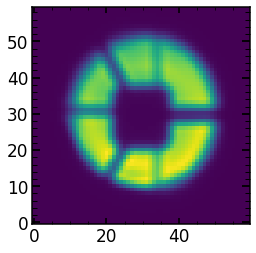

In [174]:
plt.imshow(list_of_single_model_image[0])

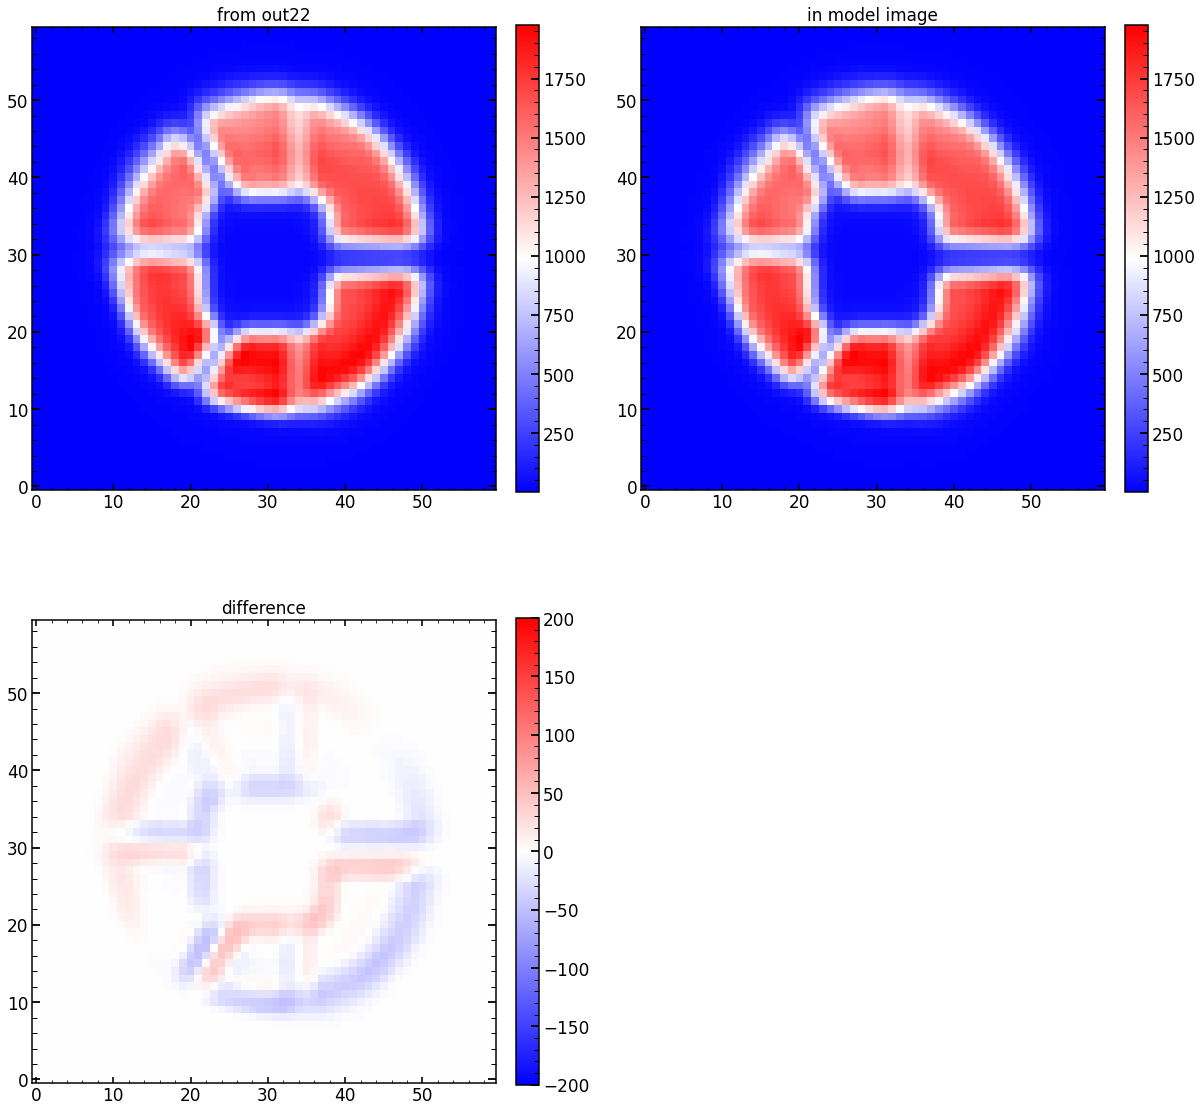

In [183]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.title('from out22')
plt.imshow(out22[348][6][0],cmap='bwr',vmax=np.max(list_of_single_model_image[0]))
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(222)
plt.title('in model image')
plt.imshow(list_of_single_model_image[0],cmap='bwr',vmax=np.max(list_of_single_model_image[0]))
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(223)
plt.title('difference')
plt.imshow(list_of_single_model_image[0]-out22[348][6][0],cmap='bwr',vmax=200,vmin=-200)
plt.colorbar(fraction=0.046, pad=0.04)


In [184]:
out22[348][-1]

array([[ -8.68450188,  -5.49665652],
       [ -2.98664735,   2.83715699],
       [ -6.62304314,   2.29371979],
       [  2.72180036,  -0.3914607 ],
       [ -0.98691315,  -0.97224107],
       [ -4.35649768,   7.54820962],
       [ -3.87109291,   4.7038007 ],
       [  1.69085734,  13.21446189],
       [-10.83559705,  12.29985204]])

In [185]:
res_multi[-1]

array([[ -8.169592  ,  -6.07665418],
       [ -2.57966623,   2.37885795],
       [ -6.31406233,   1.91771309],
       [  2.69353914,  -0.35164685],
       [ -0.99311793,  -0.94076832],
       [ -4.34600781,   7.56862453],
       [ -4.29111075,   5.1330227 ],
       [  1.21996639,  13.7196104 ],
       [-11.46361067,  12.90248797]])

In [186]:
res_multi[0]

-3.118515372276306

In [190]:
nsteps=3
array_of_multi_background_factors=np.concatenate((np.arange(80,3,-(80-3)/(nsteps-1)),np.array([3])) )

In [191]:
array_of_multi_background_factors

array([80. , 41.5,  3. ])

In [239]:
30*150

4500

In [240]:
4500*0.97

4365.0

In [384]:
best_result_from_Tokovinin_5_0=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/May0721/best_result_from_Tokovinin_5_0.npy',allow_pickle=True)
best_result_from_Tokovinin_5_1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/May0721/best_result_from_Tokovinin_5.npy',allow_pickle=True)
#best_result_from_Tokovinin_5_2=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/May0721/best_result_from_Tokovinin_5_2.npy',allow_pickle=True)

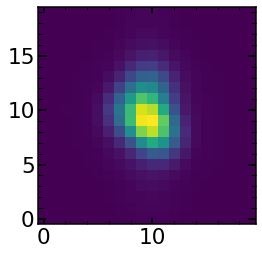

In [385]:
plt.imshow(best_result_from_Tokovinin_5_0[5][0])

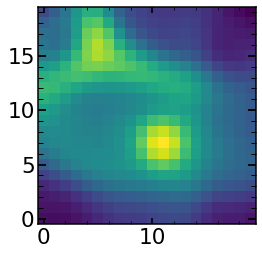

In [386]:
plt.imshow(best_result_from_Tokovinin_5_0[6][2])

In [390]:
list_of_sci_images_0=list_of_sci_images[3:6]
list_of_var_images_0=list_of_var_images[3:6]
list_of_mask_images_0=list_of_mask_images[3:6]

list_of_init_images

In [ ]:
def create_liner_combination(list_of_sci_images=list_of_sci_images_0,list_of_var_images=list_of_var_images_0,
                             list_of_mask_images=list_of_mask_images_0,list_of_init_images=best_result_from_Tokovinin_5_0[5],out_images):
    
    ############################################################################
    list_of_mean_value_of_background=[]
    list_of_flux_mask=[]
    list_of_sci_image_std=[]
    for i in range(len(list_of_sci_images)):
        sci_image=list_of_sci_images[i]
        var_image=list_of_var_images[i]

        mean_value_of_background_via_var=np.mean([np.median(var_image[0]),np.median(var_image[-1]),\
                                              np.median(var_image[:,0]),np.median(var_image[:,-1])])*multi_background_factor

        mean_value_of_background_via_sci=np.mean([np.median(sci_image[0]),np.median(sci_image[-1]),\
                                              np.median(sci_image[:,0]),np.median(sci_image[:,-1])])*multi_background_factor

        mean_value_of_background=np.max([mean_value_of_background_via_var,mean_value_of_background_via_sci])
        if verbosity>1:
            print(str(multi_background_factor)+'x mean_value_of_background in image with index'+str(i)+' is estimated to be: '+str(mean_value_of_background))


        list_of_mean_value_of_background.append(mean_value_of_background)
        flux_mask=sci_image>(mean_value_of_background)


        # normalized science image
        var_image=list_of_var_images[i]
        sci_image_std=sci_image/np.sqrt(var_image)
        list_of_sci_image_std.append(sci_image_std)
        list_of_flux_mask.append(flux_mask)
    
    ############################################################################ 

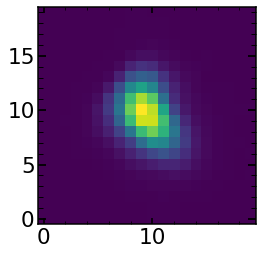

In [389]:
plt.imshow(list_of_sci_images[3])

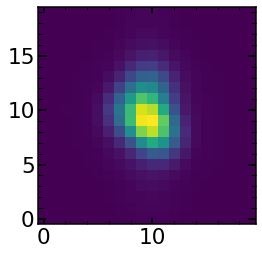

In [392]:
plt.imshow(best_result_from_Tokovinin_5_0[5][0])

In [395]:
len(best_result_from_Tokovinin_5_0[5])

3

In [333]:
previous_best_result=best_result0    

main_body_of_best_result=previous_best_result[:-1]
previous_best_result=previous_best_result[-1]

out_images=main_body_of_best_result[4]   


In [335]:
np.array(out_images).shape

(106, 9)

In [336]:
/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/May0721/

AttributeError: 'list' object has no attribute 'shape'

In [339]:
out_images_pre_renormalization=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/May0721/out_images_pre_renormalization.npy',allow_pickle=True)

out_images_pre_renormalization_0=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/May0721/out_images_pre_renormalization_0.npy',allow_pickle=True)

In [340]:
out_images_pre_renormalization_0.shape

(3, 20, 20)

In [341]:
out_images_pre_renormalization.shape

(9,)

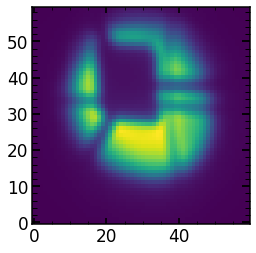

In [343]:
plt.imshow(out_images_pre_renormalization[0])

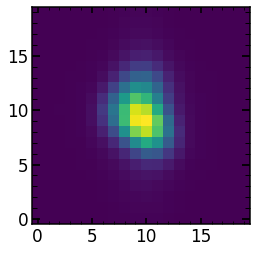

In [345]:
plt.imshow(out_images_pre_renormalization_0[0])

In [346]:
out_images_pre_renormalization*[1,1,1,1,1,1,1,1,1]

array([array([[23.765207, 25.15296 , 26.542969, ..., 30.718225, 29.116776,
        27.607634],
       [24.915335, 26.395054, 27.879936, ..., 32.404278, 30.667154,
        29.03578 ],
       [26.075195, 27.650301, 29.234009, ..., 34.142956, 32.26109 ,
        30.49985 ],
       ...,
       [32.731903, 34.868576, 37.053673, ..., 38.787933, 36.380775,
        34.177036],
       [31.213358, 33.20991 , 35.242157, ..., 36.873096, 34.618374,
        32.55044 ],
       [29.678549, 31.5411  , 33.42933 , ..., 34.936874, 32.82593 ,
        30.887228]], dtype=float32),
       array([[27.34858 , 29.282547, 31.258123, ..., 35.81341 , 33.5276  ,
        31.44226 ],
       [28.91569 , 31.00427 , 33.144623, ..., 38.20717 , 35.674965,
        33.37813 ],
       [30.50775 , 32.759346, 35.074745, ..., 40.71972 , 37.91252 ,
        35.382053],
       ...,
       [36.36634 , 39.28956 , 42.38305 , ..., 42.33569 , 39.16775 ,
        36.414413],
       [34.213947, 36.882565, 39.68225 , ..., 39.68243 , 36.77292

In [351]:
out_images_pre_renormalization_0*[1,1,1]

ValueError: operands could not be broadcast together with shapes (3,20,20) (3,) 

In [358]:
out_images_pre_renormalization_0*(np.array([1,1,1]).T)

ValueError: operands could not be broadcast together with shapes (3,20,20) (3,) 

In [361]:
np.matmul(np.array([1,1,1]).T,out_images_pre_renormalization_0)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 20 is different from 3)

# in focus idea 

In [637]:
first_proposal_Tokovnin=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/first_proposal_Tokovnin99_0.npy',allow_pickle=True)
first_proposal_Tokovnin

uber_I=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/uber_I_99.npy')
uber_M0=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/uber_M0_99_0.npy')
H=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/H_99_0.npy')
H_std=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/H_std_99_0.npy')

In [638]:
def create_linear_combination(list_of_sci_images=list_of_sci_images_0,list_of_var_images=list_of_var_images_0,
                             list_of_mask_images=list_of_mask_images_0,previous_best_result=best_result_from_Tokovinin_5_0,
                             first_proposal_Tokovnin=first_proposal_Tokovnin,multi_background_factor=3,verbosity=1):
    
    ######################################################################################################### 
    list_of_sci_image_std=[]
    for i in range(len(list_of_sci_images)):
        sci_image=list_of_sci_images[i]
        var_image=list_of_var_images[i]
        sci_image_std=sci_image/np.sqrt(var_image)
        list_of_sci_image_std.append(sci_image_std)
    
    
    ############################################################################
    list_of_mean_value_of_background=[]
    list_of_flux_mask=[]
    list_of_sci_image_std=[]
    for i in range(len(list_of_sci_images)):
        sci_image=list_of_sci_images[i]
        var_image=list_of_var_images[i]

        mean_value_of_background_via_var=np.mean([np.median(var_image[0]),np.median(var_image[-1]),\
                                              np.median(var_image[:,0]),np.median(var_image[:,-1])])*multi_background_factor

        mean_value_of_background_via_sci=np.mean([np.median(sci_image[0]),np.median(sci_image[-1]),\
                                              np.median(sci_image[:,0]),np.median(sci_image[:,-1])])*multi_background_factor

        mean_value_of_background=np.max([mean_value_of_background_via_var,mean_value_of_background_via_sci])
        if verbosity>1:
            print(str(multi_background_factor)+'x mean_value_of_background in image with index'+str(i)+' is estimated to be: '+str(mean_value_of_background))


        list_of_mean_value_of_background.append(mean_value_of_background)
        flux_mask=sci_image>(mean_value_of_background)


        # normalized science image
        var_image=list_of_var_images[i]
        sci_image_std=sci_image/np.sqrt(var_image)
        list_of_sci_image_std.append(sci_image_std)
        list_of_flux_mask.append(flux_mask)
    
    ############################################################################ 

    # masked science image
    list_of_I=[]
    list_of_I_std=[]    
    list_of_std_image=[]
    for i in range(len(list_of_sci_images)):

        sci_image=list_of_sci_images[i]
        sci_image_std=list_of_sci_image_std[i]
        flux_mask=list_of_flux_mask[i]
        std_image=np.sqrt(list_of_var_images[i][flux_mask]).ravel()

        I=sci_image[flux_mask].ravel()        
        #I=((sci_image[flux_mask])/np.sum(sci_image[flux_mask])).ravel()
        I_std=((sci_image_std[flux_mask])/1).ravel()
        #I_std=((sci_image_std[flux_mask])/np.sum(sci_image_std[flux_mask])).ravel()

        list_of_I.append(I)
        list_of_std_image.append(std_image)
        list_of_I_std.append(I_std)

    # join all I,I_std from all individual images into one uber I,I_std  
    uber_I=[item for sublist in list_of_I for item in sublist]
    uber_std=[item for sublist in list_of_std_image for item in sublist]
    uber_I_std=[item for sublist in list_of_I_std for item in sublist]    

    uber_I=np.array(uber_I)
    uber_std=np.array(uber_std)
    print(uber_I.shape)
    ############################################################################ 

    
    main_body_of_best_result=previous_best_result[:-1]
    previous_best_result=previous_best_result[-1]


    # we need actual final model images from the previous best result
    #list_of_image_0_from_previous_best_result=main_body_of_best_result[6]
    #list_of_image_0=list_of_image_0_from_previous_best_result

    # we need actual initial model images from the previous best result
    # this will be used to evalute change of model due to changes in singel wavefront parameters
    # i.e., to estimate matrix H
    list_of_image_0_from_previous_best_result=main_body_of_best_result[5]
    list_of_image_0=list_of_image_0_from_previous_best_result


    list_of_flux_mask=list_of_flux_mask 
    list_of_sci_image_std=list_of_sci_image_std

    list_of_image_0_std=[]
    for i in range(len(list_of_image_0)):
        # normalizing by standard deviation image
        STD=np.sqrt(list_of_var_images[i])    
        image_0=list_of_image_0[i]
        list_of_image_0_std.append(image_0/STD)  


    list_of_M0=[]
    list_of_M0_std=[]
    for i in range(len(list_of_image_0_std)):

        image_0=list_of_image_0[i]
        image_0_std=list_of_image_0_std[i]
        flux_mask=list_of_flux_mask[i]


        M0=image_0[flux_mask].ravel()            
        #M0=((image_0[flux_mask])/np.sum(image_0[flux_mask])).ravel()
        M0_std=((image_0_std[flux_mask])/1).ravel()
        #M0_std=((image_0_std[flux_mask])/np.sum(image_0_std[flux_mask])).ravel()

        list_of_M0.append(M0)
        list_of_M0_std.append(M0_std)

    # join all M0,M0_std from invidiual images into one uber M0,M0_std
    uber_M0_previous_best_dedicated=[item for sublist in list_of_M0 for item in sublist]
    uber_M0_previous_best_std_dedicated=[item for sublist in list_of_M0_std for item in sublist]    

    uber_M0_previous_best_dedicated=np.array(uber_M0_previous_best_dedicated)
    uber_M0_previous_best_std_dedicated=np.array(uber_M0_previous_best_std_dedicated)

    out_images=main_body_of_best_result[4]   

    # join all images together
    list_of_images_normalized_uber=[]
    list_of_images_normalized_std_uber=[]
    # go over (zmax-3)*2 images
    for j in range(len(out_images)):
        # two steps for what could have been achived in one, but to ease up transition from previous code 
        out_images_single_parameter_change=out_images[j]
        optpsf_list=out_images_single_parameter_change

        # flux image has to correct per image
        #  mask images that have been created in the fitting procedure with the appropriate flux mask
        images_normalized=[]
        for i in range(len(optpsf_list)):

            flux_mask=list_of_flux_mask[i]
            if j==0:

                #print('sum_flux_in images'+str([i,np.sum(flux_mask)]))
                pass
            images_normalized.append((optpsf_list[i][flux_mask]).ravel())                
            # !old double-normalizing code
            # !images_normalized.append((optpsf_list[i][flux_mask]/np.sum(optpsf_list[i][flux_mask])).ravel())



        images_normalized_flat=[item for sublist in images_normalized for item in sublist]  
        images_normalized_flat=np.array(images_normalized_flat)
        #images_normalized_flat=np.array(images_normalized_flat)/len(optpsf_list)        

        # list of (zmax-3)*2 raveled images
        list_of_images_normalized_uber.append(images_normalized_flat)

        # same but divided by STD
        images_normalized_std=[]
        for i in range(len(optpsf_list)):   
            # seems that I am a bit more verbose here with my definitions
            optpsf_list_i=optpsf_list[i]


            # do I want to generate new STD images, from each image?
            STD=list_of_sci_image_std[i]
            optpsf_list_i_STD=optpsf_list_i/STD    
            flux_mask=list_of_flux_mask[i]
            #images_normalized_std.append((optpsf_list_i_STD[flux_mask]/np.sum(optpsf_list_i_STD[flux_mask])).ravel())

        # join all images together
        #images_normalized_std_flat=[item for sublist in images_normalized_std for item in sublist]  
        # normalize so that the sum is still one
        #images_normalized_std_flat=np.array(images_normalized_std_flat)/len(optpsf_list)

        #list_of_images_normalized_std_uber.append(images_normalized_std_flat)

    # create uber images_normalized,images_normalized_std    
    # images that have zmax*2 rows and very large number of columns (number of non-masked pixels from all N images)
    uber_images_normalized_previous_best_dedicated=np.array(list_of_images_normalized_uber)   

    number_of_extra_zernike=56-22
    list_of_delta_z_parametrizations=[]
    for z_par in range(0,19*2+2*number_of_extra_zernike):
        z_par_i=z_par+4
        # if this is the parameter that change
        if np.mod(z_par_i,2)==0:
            list_of_delta_z_parametrizations.append(0.1*0.05/np.sqrt(z_par_i))
        if np.mod(z_par_i,2)==1:
            list_of_delta_z_parametrizations.append(0.05/np.sqrt(z_par_i))

    array_of_delta_z_parametrizations=np.array(list_of_delta_z_parametrizations)*(1)
    array_of_delta_parametrizations=array_of_delta_z_parametrizations



    array_of_delta_parametrizations_None_previous_best=previous_best_result[3]

    # ratio between current parametrization and the previous (provided) changed parametrization
    ratio_of_parametrizations=(array_of_delta_parametrizations[:,None]/array_of_delta_parametrizations_None_previous_best)

    # create the array of how wavefront changes the uber_model by multiply the changes with new ratios
    array_of_wavefront_changes_dedicated=np.transpose(ratio_of_parametrizations*\
                                            np.array(uber_images_normalized_previous_best_dedicated-uber_M0_previous_best_dedicated)/(array_of_delta_parametrizations_None_previous_best))    


     # how much did parameters change
    actual_wavefront_change=np.concatenate(((best_result_from_Tokovinin_5_0[8]-best_result_from_Tokovinin_5_0[7])[:19*2],(best_result_from_Tokovinin_5_0[8]-best_result_from_Tokovinin_5_0[7])[19*2+23:]))

    actual_wavefront_change=first_proposal_Tokovnin
    
    # change I expect from the changes of singular parameters
    predicted_change=np.dot(array_of_wavefront_changes_dedicated,actual_wavefront_change[:,None]).ravel()   
    

    
    return array_of_wavefront_changes_dedicated,actual_wavefront_change,predicted_change

In [639]:
array_of_wavefront_changes_dedicated,actual_wavefront_change,predicted_change=create_linear_combination()

(482,)


In [640]:
predicted_change=np.dot(H,first_proposal_Tokovnin).ravel()  

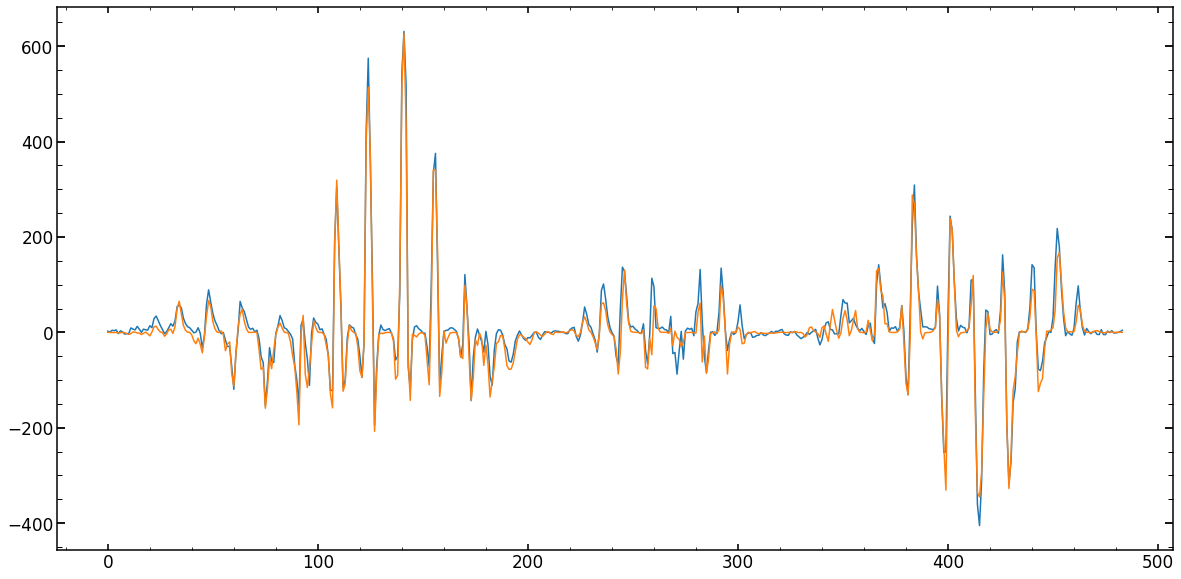

In [641]:
plt.figure(figsize=(20,10))
plt.plot(uber_I-uber_M0)
plt.plot(predicted_change)

non_singlular_parameters.shape)(104,)
[ 56 104]


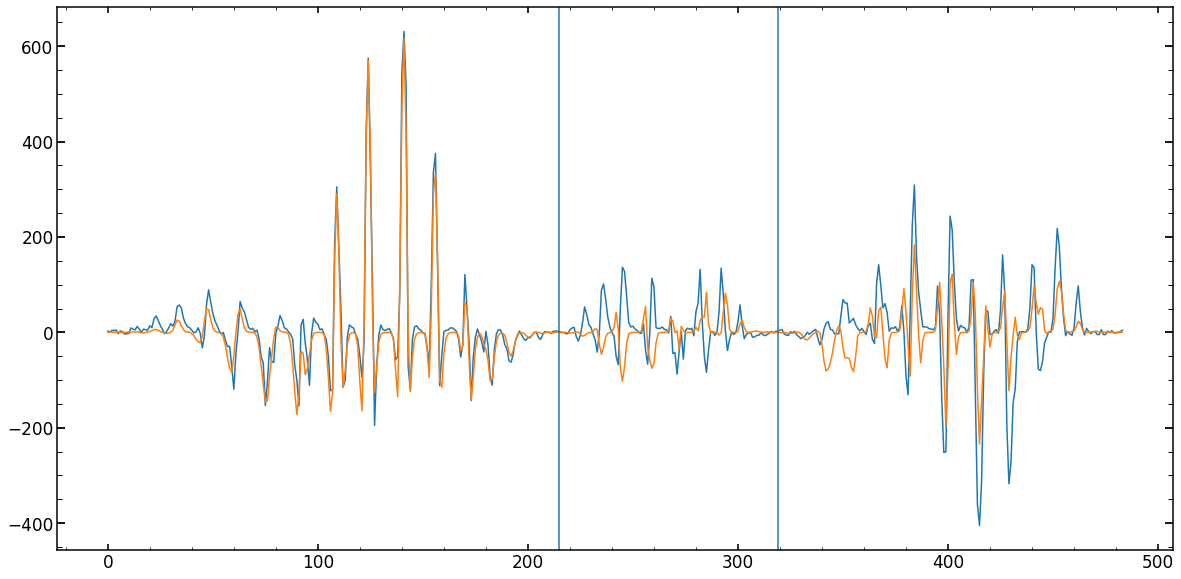

In [642]:
first_proposal_Tokovnin=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/first_proposal_Tokovnin99_0.npy',allow_pickle=True)
first_proposal_Tokovnin

uber_I=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/uber_I_99.npy')
uber_M0=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/uber_M0_99_0.npy')
H=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/H_99_0.npy')
H_std=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/H_std_99_0.npy')

list_of_flux_mask=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/list_of_flux_mask_99.npy')

#print('np.mean(H,axis=0).shape)'+str(np.mean(H,axis=0).shape))
singlular_parameters=np.arange(H.shape[1])[np.abs((np.mean(H,axis=0)))<0.001]
non_singlular_parameters=np.arange(H.shape[1])[np.abs((np.mean(H,axis=0)))>0.001]
print('non_singlular_parameters.shape)'+str(non_singlular_parameters.shape))
print(singlular_parameters)
H=H[:,non_singlular_parameters]
H_std=H_std[:,non_singlular_parameters]

H=H[:,0:(11-3)*2]

HHt=np.matmul(np.transpose(H),H)
HHt_std=np.matmul(np.transpose(H_std),H_std) 
#print('svd thresh is '+str(thresh))
#invHHt=svd_invert(HHt,thresh)
#invHHt_std=svd_invert(HHt_std,thresh)
invHHt=np.linalg.inv(HHt)        
invHHt_std=np.linalg.inv(HHt_std)

invHHtHt=np.matmul(invHHt,np.transpose(H))
invHHtHt_std=np.matmul(invHHt_std,np.transpose(H_std))

first_proposal_Tokovnin=np.matmul(invHHtHt,uber_I-uber_M0)

predicted_change=np.dot(H,first_proposal_Tokovnin).ravel()  

plt.figure(figsize=(20,10))
plt.plot(uber_I-uber_M0)
plt.plot(predicted_change)

plt.axvline(np.sum(list_of_flux_mask[0]))
plt.axvline(np.sum(list_of_flux_mask[0])+np.sum(list_of_flux_mask[1]))

In [643]:
first_proposal_Tokovnin

array([ 0.22993777, -0.22839255,  0.35120224, -0.09519532,  0.01339623,
       -0.119555  ,  0.55621382,  0.14750764, -0.44786827, -0.09663604,
       -0.04374517, -0.0577904 ,  0.12331301,  0.03507161,  0.05037613,
        0.11205413])

In [644]:
H=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/H_99_0.npy')

H=H[:,0:(11-3)*2]

In [645]:
H

array([[-0.09670258,  0.19877705, -0.2661656 , ...,  0.86705163,
        -0.10123336,  0.23403741],
       [ 0.11032104, -0.19250755, -0.21248397, ...,  0.70401104,
        -0.15561291,  0.34190247],
       [ 0.03044128, -0.02723178,  0.00883014, ..., -0.10365015,
        -0.02573318,  0.08915038],
       ...,
       [-0.41290283, -0.81373327, -0.49430087, ..., -1.24721492,
         0.26267265,  0.55172968],
       [-0.6060791 , -1.20047995, -0.57349179, ..., -0.88772661,
         0.15002929,  0.32712028],
       [ 0.07259369,  0.15549196, -0.01691275, ..., -0.28357125,
         0.06797444,  0.14361084]])

In [646]:
H=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/H_99_0.npy')
H_only_focus=H[np.sum(list_of_flux_mask[0]):(np.sum(list_of_flux_mask[0])+np.sum(list_of_flux_mask[1])),1:(11-3)*2:2]
print(H_only_focus.shape)


uber_I_only_focus=uber_I[np.sum(list_of_flux_mask[0]):(np.sum(list_of_flux_mask[0])+np.sum(list_of_flux_mask[1]))]
uber_M0_only_focus=uber_M0[np.sum(list_of_flux_mask[0]):(np.sum(list_of_flux_mask[0])+np.sum(list_of_flux_mask[1]))]

(104, 8)


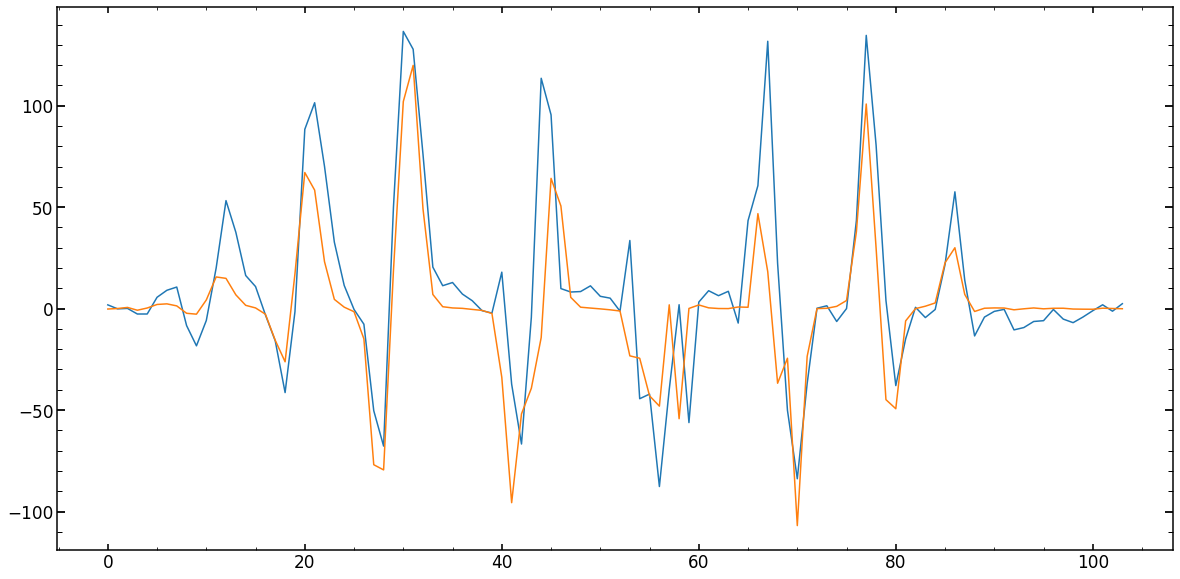

In [647]:
HHt=np.matmul(np.transpose(H_only_focus),H_only_focus)

#print('svd thresh is '+str(thresh))
#invHHt=svd_invert(HHt,thresh)
#invHHt_std=svd_invert(HHt_std,thresh)
invHHt=np.linalg.inv(HHt)        


invHHtHt=np.matmul(invHHt,np.transpose(H_only_focus))


first_proposal_Tokovnin_only_focus=np.matmul(invHHtHt,uber_I_only_focus-uber_M0_only_focus)

predicted_change=np.dot(H_only_focus,first_proposal_Tokovnin_only_focus).ravel()  

plt.figure(figsize=(20,10))
plt.plot(uber_I_only_focus-uber_M0_only_focus)
plt.plot(predicted_change)



In [678]:
array_of_delta_z_parametrizations=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/array_of_delta_z_parametrizations_99_0.npy')
uber_std=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/uber_std_99.npy')

array_of_delta_z_parametrizations[1:(11-3)*2:2]

array([0.2236068 , 0.18898224, 0.16666667, 0.15075567, 0.13867505,
       0.12909944, 0.12126781, 0.11470787])

In [649]:
first_proposal_Tokovnin_only_focus/array_of_delta_z_parametrizations[1:(11-3)*2:2]

array([-0.01549733,  3.04272805,  3.94670219, -2.55892507,  2.1072693 ,
        1.14137577, -6.35707754, -0.70428088])

In [ ]:
first_proposal_Tokovnin_only_focus

In [650]:
test_minchain=np.copy(list_of_minchain[index_of_single_image])
test_minchain[0:8]=test_minchain[0:8]+first_proposal_Tokovnin_only_focus

In [653]:
index_of_single_image=4
model = LN_PFS_single(list_of_sci_images[index_of_single_image],list_of_var_images[index_of_single_image],mask_image=list_of_mask_images[index_of_single_image],dithering=1,save=1,zmax=22,verbosity=1,\
                      double_sources=None,double_sources_positions_ratios=double_sources_positions_ratios,fit_for_flux=True,npix=1536)  

#res_with_Image=model(list_of_minchain[index_of_single_image],return_Image=True)
res_with_Image=model(test_minchain,return_Image=True)

Science image shape is: (20, 20)
Top left pixel value of the science image is: -1.7947999
Variance image shape is: (20, 20)
Top left pixel value of the variance image is: 3.0357723
Mask image shape is: (20, 20)
Sum of mask image is: 0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
np.__version__1.18.5
skimage.__version__0.17.2
scipy.__version__1.5.0
Zernike_Module.__version__0.45c
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 22

Entering lnlike_Neven
allparameters [    0.16145615    -0.31130643     0.14108806    -0.70516188
     0.80068095    -0.28014912    -1.3518691      0.50466031
     0.03863879     0.22954357    -0.04948961     0.03281349
     0.0587434      0.050954       0.02756475    -0.03203576
    -0.03294923     0.02517083     0.04498642     0.6982929
     0.10099376    -0.22868679     0.27114778     0.06266987
     0.10090548     0.2078081      0.31853494     0.31105295
     1.28564277    -0.0

chi2 within shgo optimization routine (chi_2_almost_multi_values): [-4.10283958 -4.43548541] / 9.844139
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-4.30798156 -4.43548541] / 10.827947
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-4.10283958 -4.65725968] / 9.919631
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-3.89769761 -4.65725968] / 9.312118
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-3.69255563 -4.76814682] / 9.261282
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-3.69255563 -4.54637255] / 9.110946
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-3.48741365 -4.49092898] / 9.397796
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-3.28227167 -4.87903395] / 10.221128
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-3.89769761 -4.54637255] / 9.256732
chi2 within shgo optimization routine (chi_2_almost_multi_valu

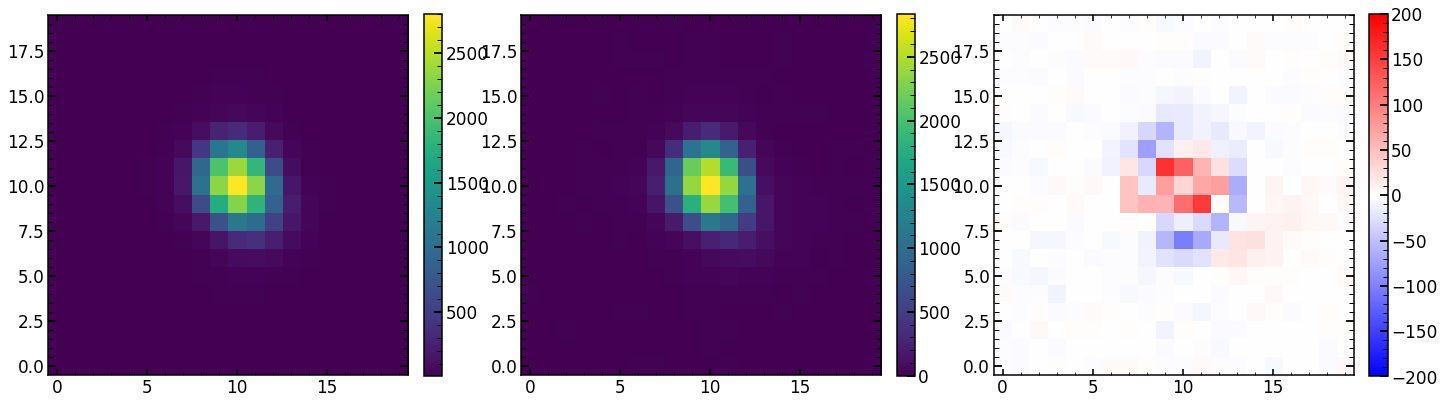

In [655]:
plt.figure(figsize=(24,10))
plt.subplot(131)
plt.imshow(res_with_Image[1])
cbar=plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.imshow(list_of_sci_images[index_of_single_image])
cbar=plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(133)
plt.imshow(list_of_sci_images[index_of_single_image]-res_with_Image[1],cmap='bwr',vmin=-200,vmax=200)
cbar=plt.colorbar(fraction=0.046, pad=0.04)

In [658]:
model_multi=LN_PFS_multi_same_spot(list_of_sci_images,list_of_var_images,list_of_mask_images=list_of_mask_images,dithering=1,save=1,zmax=56,verbosity=1,\
                      double_sources=double_sources,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536,test_run=False)   


#minchain_parametrization_test=np.copy(chain0_swarm_1[2][348])
#minchain_parametrization_test[0]=minchain_parametrization_test[0]+array_of_delta_z_parametrizations_None_1_0[0]

list_of_minchain=model_multi.create_list_of_allparameters(minchain_parametrization,list_of_defocuses=list_of_defocuses_input_long,zmax=56)
#list_of_minchain=model_multi.create_list_of_allparameters(gbests_positions[-1],list_of_defocuses=list_of_defocuses_input_long,zmax=56)



res_multi=model_multi(list_of_minchain,return_Images=True,use_only_chi=True)

################################
analyzing image 1 out of 9
 
Science image shape is: (60, 60)
Top left pixel value of the science image is: 11.366353
Variance image shape is: (60, 60)
Top left pixel value of the variance image is: 6.2264752
Mask image shape is: (60, 60)
Sum of mask image is: 0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
np.__version__1.18.5
skimage.__version__0.17.2
scipy.__version__1.5.0
Zernike_Module.__version__0.45c
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 56

Entering lnlike_Neven
allparameters [   32.26286464    -2.7904354     -1.38901013    -0.25933571
     0.7909853     -0.50167539    -0.49062885     0.8347611
     0.05159541     0.23869737    -0.15181199     0.02699841
     0.0328766      0.10617364     0.0171643     -0.0287926
    -0.04517753    -0.00510353     0.12597928     0.6982929
     0.10099376    -0.22868679     0.27114778     0.06266987
     0.10090548     0.207

chi2 within shgo optimization routine (chi_2_almost_multi_values): [-13.4350372 -10.026419 ] / 46.40675
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-13.43503722 -10.026419  ] / 46.406746
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-13.4350372  -10.02641902] / 46.406742
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-23.56003718 -25.77641895] / 1404.9917
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-17.92507994 -17.01092992] / 302.15085
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-15.56479648 -13.33937788] / 104.0078
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-14.4732371  -11.64139661] / 60.404507
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-13.94757115 -10.82369403] / 49.98264
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-13.68961651 -10.42243126] / 47.374523
chi2 within shgo optimization routine (chi

chi2 within shgo optimization routine (chi_2_almost_multi_values): [-13.66799903  -9.83314028] / 46.077065
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-13.66799936  -9.83312977] / 46.077057
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-13.66799925  -9.83313327] / 46.077057
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-13.66799665  -9.83312688] / 46.077053
We are fitting for only one source
One source fitting result is [-13.66799383  -9.8331275 ]
type(complete_realization_renormalized)<class 'numpy.float32'>
Time for single_Psf_position protocol is 0.7583901882171631
Sucesfully created optPsf_cut_fiber_convolved_downsampled
Finished with optPsf_postprocessing
 
Internally fitting for flux; disregarding passed value for flux
Internally fitting for flux; multiplying all values in the model by 0.9984090588552478
Finished with lnlike_Neven
chi_almost/d.o.f is 5.942976; chi_almost_max_dof is 83.02857 log(improvment) is -1.

chi2 within shgo optimization routine (chi_2_almost_multi_values): [-9.55746954 -1.42916147] / 46.18685
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-9.55746896 -1.37640982] / 46.64183
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-9.55746867 -1.34911443] / 46.886696
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-9.55746851 -1.33497112] / 47.016098
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-9.55746853 -1.33497112] / 47.0161
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-9.55746851 -1.33497113] / 47.016098
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-9.5505252  -1.34191427] / 46.92636
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-9.55381227 -1.33862728] / 46.968746
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-9.55554298 -1.33689661] / 46.991123
chi2 within shgo optimization routine (chi_2_almost_multi_va

Finished with optPsf_postprocessing
 
Internally fitting for flux; disregarding passed value for flux
Internally fitting for flux; multiplying all values in the model by 0.9982663428921026
Finished with lnlike_Neven
chi_almost/d.o.f is 5.63893; chi_almost_max_dof is 88.2037 log(improvment) is -1.19429
The likelihood reported is: -5.638929843902588
multiprocessing.current_process() <_MainProcess name='MainProcess' parent=None started> thread 4489811392
uname_result(system='Darwin', node='IapetusUSA', release='18.7.0', version='Darwin Kernel Version 18.7.0: Tue Aug 20 16:57:14 PDT 2019; root:xnu-4903.271.2~2/RELEASE_X86_64', machine='x86_64', processor='i386')
Time for lnlike_Neven function in thread 4489811392 is: 8.037091970443726 seconds
 
################################
analyzing image 3 out of 9
 
Science image shape is: (40, 40)
Top left pixel value of the science image is: 9.511934
Variance image shape is: (40, 40)
Top left pixel value of the variance image is: 5.372835
Mask imag

We are fitting for only one source
One source fitting result is [ -4.84349867 -12.95357902]
type(complete_realization_renormalized)<class 'numpy.float32'>
Time for single_Psf_position protocol is 0.32024502754211426
Sucesfully created optPsf_cut_fiber_convolved_downsampled
Finished with optPsf_postprocessing
 
Internally fitting for flux; disregarding passed value for flux
Internally fitting for flux; multiplying all values in the model by 0.996254312198276
Finished with lnlike_Neven
chi_almost/d.o.f is 5.48214; chi_almost_max_dof is 99.651505 log(improvment) is -1.2595338
The likelihood reported is: -5.482140064239502
multiprocessing.current_process() <_MainProcess name='MainProcess' parent=None started> thread 4489811392
uname_result(system='Darwin', node='IapetusUSA', release='18.7.0', version='Darwin Kernel Version 18.7.0: Tue Aug 20 16:57:14 PDT 2019; root:xnu-4903.271.2~2/RELEASE_X86_64', machine='x86_64', processor='i386')
Time for lnlike_Neven function in thread 4489811392 is: 

chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 0.2108071  -3.20953701] / 32.96736
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 0.21871237 -2.99070494] / 32.759926
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 0.22925272 -2.99070494] / 32.698383
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 0.23847553 -2.95423293] / 32.693733
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 0.24111062 -3.02717695] / 32.612495
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 0.25230975 -3.04541296] / 32.54748
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 0.26943783 -2.93599692] / 32.56322
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 0.28327204 -3.02717695] / 32.385498
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 0.3056703  -3.06364896] / 32.26855
chi2 within shgo optimization routine (chi_2_almost_multi_v

Finished with optPsf_postprocessing
 
Internally fitting for flux; disregarding passed value for flux
Internally fitting for flux; multiplying all values in the model by 0.98
Finished with lnlike_Neven
chi_almost/d.o.f is 5.4613633; chi_almost_max_dof is 40.33284 log(improvment) is -0.8683577
The likelihood reported is: -5.461363315582275
multiprocessing.current_process() <_MainProcess name='MainProcess' parent=None started> thread 4489811392
uname_result(system='Darwin', node='IapetusUSA', release='18.7.0', version='Darwin Kernel Version 18.7.0: Tue Aug 20 16:57:14 PDT 2019; root:xnu-4903.271.2~2/RELEASE_X86_64', machine='x86_64', processor='i386')
Time for lnlike_Neven function in thread 4489811392 is: 4.889502048492432 seconds
 
################################
analyzing image 5 out of 9
 
Science image shape is: (20, 20)
Top left pixel value of the science image is: -1.7947999
Variance image shape is: (20, 20)
Top left pixel value of the variance image is: 3.0357723
Mask image shap

chi2 within shgo optimization routine (chi_2_almost_multi_values): [-3.55326311 -4.85449605] / 11.242668
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-3.77192546 -4.85449605] / 11.309068
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-3.56692951 -4.77358778] / 11.212508
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-3.73092627 -4.66571009] / 11.241775
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-3.68651048 -4.71290658] / 11.19703
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-3.83684084 -4.68593716] / 11.355965
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-3.63440734 -4.75167513] / 11.183824
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-3.60365795 -4.71796335] / 11.203993
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-3.63205843 -4.7251271 ] / 11.190749
chi2 within shgo optimization routine (chi_2_almost_mult

Time to apodize the pupil: 0.12877678871154785
type(ilum_radiometric_apodized)<class 'numpy.float32'>
Time for postprocessing pupil after _get_Pupil 0.28225111961364746
Time for pupil and illumination calculation is 0.2876441478729248

Starting creation of wavefront
diam_sic: 0.1395327
aberrations: [0.0, 0, 0.0, 0.0, -3.8473214438365786, -0.6483145505384295, -0.40765632883409575, -0.32689611851895084, 0.47313902768679506, -0.4182281916809615, -0.5922516320404919, 0.5542825881371083, 0.03701921727871536, 0.22839935053516663, -0.036699312245598685, 0.03354037226601576, 0.0619767556281039, 0.04405154345961625, 0.028864804051634583, -0.03244115740840232, -0.03142069654292452, 0.028955127537114954, 0.03486231570193804, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
aberrations moved to z4=0: [0.0, 0.0, 0.0, 0.0, 0, -0.6483145505384295, -0.40765632883409575, -0.326896118

chi2 within shgo optimization routine (chi_2_almost_multi_values): [0.63623561 3.26440415] / 31.089401
chi2 within shgo optimization routine (chi_2_almost_multi_values): [0.84966982 3.20473755] / 31.00047
chi2 within shgo optimization routine (chi_2_almost_multi_values): [0.89134269 3.05811879] / 31.133307
chi2 within shgo optimization routine (chi_2_almost_multi_values): [0.79110216 3.23798155] / 30.987392
chi2 within shgo optimization routine (chi_2_almost_multi_values): [0.84141046 3.29140206] / 31.015474
chi2 within shgo optimization routine (chi_2_almost_multi_values): [0.80987375 3.18633829] / 30.992756
chi2 within shgo optimization routine (chi_2_almost_multi_values): [0.75130609 3.21958229] / 30.993101
chi2 within shgo optimization routine (chi_2_almost_multi_values): [0.77589703 3.2158711 ] / 30.987633
chi2 within shgo optimization routine (chi_2_almost_multi_values): [0.75712543 3.26751436] / 30.99952
chi2 within shgo optimization routine (chi_2_almost_multi_values): [0.79668

Time to apodize the pupil: 0.13411617279052734
type(ilum_radiometric_apodized)<class 'numpy.float32'>
Time for postprocessing pupil after _get_Pupil 0.2816751003265381
Time for pupil and illumination calculation is 0.2872800827026367

Starting creation of wavefront
diam_sic: 0.1395327
aberrations: [0.0, 0, 0.0, 0.0, -23.908535936848207, 0.5417525879738455, 0.13754022731788662, -0.3644296774066478, 0.2965577631212643, -0.37186863684827154, -0.64870873398725, 0.3984611919388467, 0.02892133152391895, 0.2226782287111591, 0.027252176455337812, 0.037174795140606336, 0.07814351143109785, 0.009539268869445415, 0.03536508482493178, -0.03446813366453716, -0.023778011510373585, 0.04787660352243031, -0.015758218218489557, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
aberrations moved to z4=0: [0.0, 0.0, 0.0, 0.0, 0, 0.5417525879738455, 0.13754022731788662, -0.364429677406647

We are fitting for only one source
One source fitting result is [ 6.16029626 -3.42534751]
type(complete_realization_renormalized)<class 'numpy.float32'>
Time for single_Psf_position protocol is 0.428530216217041
Sucesfully created optPsf_cut_fiber_convolved_downsampled
Finished with optPsf_postprocessing
 
Internally fitting for flux; disregarding passed value for flux
Internally fitting for flux; multiplying all values in the model by 0.9827872567439042
Finished with lnlike_Neven
chi_almost/d.o.f is 4.840548; chi_almost_max_dof is 70.4936 log(improvment) is -1.1632552
The likelihood reported is: -4.840548038482666
multiprocessing.current_process() <_MainProcess name='MainProcess' parent=None started> thread 4489811392
uname_result(system='Darwin', node='IapetusUSA', release='18.7.0', version='Darwin Kernel Version 18.7.0: Tue Aug 20 16:57:14 PDT 2019; root:xnu-4903.271.2~2/RELEASE_X86_64', machine='x86_64', processor='i386')
Time for lnlike_Neven function in thread 4489811392 is: 6.08

chi2 within shgo optimization routine (chi_2_almost_multi_values): [10.38578376  4.5288506 ] / 32.874786
chi2 within shgo optimization routine (chi_2_almost_multi_values): [18.26078376  4.52885058] / 229.33568
chi2 within shgo optimization routine (chi_2_almost_multi_values): [13.97364379  4.52885058] / 65.70726
chi2 within shgo optimization routine (chi_2_almost_multi_values): [12.11780099  4.52885058] / 37.58828
chi2 within shgo optimization routine (chi_2_almost_multi_values): [11.24268317  4.52885058] / 32.647465
chi2 within shgo optimization routine (chi_2_almost_multi_values): [10.81467791  4.52885058] / 32.138275
chi2 within shgo optimization routine (chi_2_almost_multi_values): [10.60167905  4.52885058] / 32.346798
chi2 within shgo optimization routine (chi_2_almost_multi_values): [10.49477258  4.52885058] / 32.568398
chi2 within shgo optimization routine (chi_2_almost_multi_values): [10.44088323  4.52885058] / 32.70974
chi2 within shgo optimization routine (chi_2_almost_multi_

chi2 within shgo optimization routine (chi_2_almost_multi_values): [10.86595775  4.28098841] / 31.913954
chi2 within shgo optimization routine (chi_2_almost_multi_values): [10.86590269  4.28096293] / 31.913958
chi2 within shgo optimization routine (chi_2_almost_multi_values): [10.8659618   4.28097429] / 31.913954
chi2 within shgo optimization routine (chi_2_almost_multi_values): [10.86596992  4.28094605] / 31.913954
chi2 within shgo optimization routine (chi_2_almost_multi_values): [10.86595311  4.28095027] / 31.913956
chi2 within shgo optimization routine (chi_2_almost_multi_values): [10.8659363   4.28095449] / 31.913958
chi2 within shgo optimization routine (chi_2_almost_multi_values): [10.86590675  4.28094882] / 31.913954
chi2 within shgo optimization routine (chi_2_almost_multi_values): [10.86588125  4.28092902] / 31.913954
chi2 within shgo optimization routine (chi_2_almost_multi_values): [10.86589501  4.28093539] / 31.91395
chi2 within shgo optimization routine (chi_2_almost_mult

creating wf_full_fake_0
Time for wavefront and wavefront/pupil combining is 0.0004181861877441406
type(expwf_grid)<class 'numpy.complex64'>
Time for FFT is 0.33124208450317383
type(img_apod)<class 'numpy.float32'>
Finished with _getOptPsf_naturalResolution
 
 
Entering optPsf_postprocessing
optPsf.shape: (3072, 3072)
oversampling_original: 35.374287997579025
size_of_central_cut: 2971
optPsf_cut.shape(2972, 2972)
oversampling:9.0
optPsf_cut.shape[0]2972
size_of_optPsf_cut_downsampled: 756.0
optPsf_cut_downsampled.shape: (757, 757)
size_of_optPsf_cut_in_Microns: 1261.6666666666667
postprocessing parameters:
['grating_lines', 'scattering_slope', 'scattering_amplitude', 'pixel_effect', 'fiber_r']
[30096.76438941175, 2.3107404715388187, 0.006455527493489705, 0.4920384686666554, 1.8371325296272112]
type(pointsx): <class 'numpy.float32'>
optPsf_cut_downsampled_scattered.shape:(757, 757)
simulation_00 parameter:None
are we invoking double sources (1 or True if yes): False
double source positio

chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 6.50701028 -6.44537137] / 47.593445
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 6.51095289 -6.44678234] / 47.59352
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 6.5061843  -6.44327667] / 47.593445
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 6.50936336 -6.44561378] / 47.593468
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 6.50697906 -6.44386095] / 47.593437
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 6.50850615 -6.44200867] / 47.593468
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 6.50738425 -6.44453069] / 47.593445
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 6.50775822 -6.44369002] / 47.593437
chi2 within shgo optimization routine (chi_2_almost_multi_values): [ 6.50699467 -6.44461616] / 47.593445
chi2 within shgo optimization routine (chi_2_almost_mult

In [659]:
model_multi=LN_PFS_multi_same_spot(list_of_sci_images[4:5],list_of_var_images[4:5],list_of_mask_images=list_of_mask_images[4:5],dithering=1,save=1,zmax=56,verbosity=1,\
                      double_sources=double_sources,double_sources_positions_ratios=double_sources_positions_ratios,npix=1536,test_run=False)   


#minchain_parametrization_test=np.copy(chain0_swarm_1[2][348])
#minchain_parametrization_test[0]=minchain_parametrization_test[0]+array_of_delta_z_parametrizations_None_1_0[0]

list_of_minchain=model_multi.create_list_of_allparameters(minchain_parametrization,list_of_defocuses=list_of_defocuses_input_long[4:5],zmax=56)
#list_of_minchain=model_multi.create_list_of_allparameters(gbests_positions[-1],list_of_defocuses=list_of_defocuses_input_long,zmax=56)



res_multi_focus=model_multi(list_of_minchain,return_Images=True,use_only_chi=True)

################################
analyzing image 1 out of 1
 
Science image shape is: (20, 20)
Top left pixel value of the science image is: -1.7947999
Variance image shape is: (20, 20)
Top left pixel value of the variance image is: 3.0357723
Mask image shape is: (20, 20)
Sum of mask image is: 0
Dithering value is: 1

supplied extra Zernike parameters (beyond zmax): None
np.__version__1.18.5
skimage.__version__0.17.2
scipy.__version__1.5.0
Zernike_Module.__version__0.45c
 
Initializing ZernikeFitter_PFS
Verbosity parameter is: 1
Highest Zernike polynomial is (zmax): 56

Entering lnlike_Neven
allparameters [    0.16492145    -0.88632798    -0.51669564    -0.31938941
     0.50845528    -0.4275001     -0.58096021     0.58544687
     0.03863879     0.22954357    -0.04948961     0.03281349
     0.0587434      0.050954       0.02756475    -0.03203576
    -0.03294923     0.02517083     0.04498642     0.6982929
     0.10099376    -0.22868679     0.27114778     0.06266987
     0.10090548     0.

chi2 within shgo optimization routine (chi_2_almost_multi_values): [-3.64706028 -4.76576868] / 11.181929
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-3.64760827 -4.76591358] / 11.1819315
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-3.64692466 -4.76540441] / 11.181929
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-3.64709556 -4.7655317 ] / 11.181929
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-3.64743736 -4.76578628] / 11.18193
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-3.64718101 -4.76559535] / 11.181929
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-3.64726646 -4.76565899] / 11.1819315
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-3.6472841 -4.7655405] / 11.18193
chi2 within shgo optimization routine (chi_2_almost_multi_values): [-3.64749028 -4.76543081] / 11.1819315
chi2 within shgo optimization routine (chi_2_almost_mult

In [664]:
pre_model_result,model_results,pre_images,pre_input_parameters,chi_2_before_iteration_array,list_of_psf_positions=res_multi
pre_model_result,model_results_focus,pre_images_focus,pre_input_parameters_focus,chi_2_before_iteration_array_focus,list_of_psf_positions_focus=res_multi_focus

In [669]:
chi_2_before_iteration=chi_2_before_iteration_array[2]
chi_2_before_iteration

[6457.961, 117389.48, 5.48214, 99.651505]

In [790]:
def create_first_proposal_Tokovnin(H,H_std,uber_I,uber_M0,uber_std,up_to_which_z=None):
        
        H_shape=H.shape
    

        if up_to_which_z!=None:
            #H=H[:,1:(up_to_which_z-3)*2:2]
            #H_std=H_std[:,1:(up_to_which_z-3)*2:2]    
            H=H[:,0:(up_to_which_z-3)*2]
            H_std=H_std[:,0:(up_to_which_z-3)*2] 
            
        else:
            pass
    
        #print('np.mean(H,axis=0).shape)'+str(np.mean(H,axis=0).shape))
        singlular_parameters=np.arange(H.shape[1])[np.abs((np.mean(H,axis=0)))<0.01]
        non_singlular_parameters=np.arange(H.shape[1])[np.abs((np.mean(H,axis=0)))>0.01]
        #print('non_singlular_parameters.shape)'+str(non_singlular_parameters.shape))
        H=H[:,non_singlular_parameters]
        H_std=H_std[:,non_singlular_parameters]

        HHt=np.matmul(np.transpose(H),H)
        HHt_std=np.matmul(np.transpose(H_std),H_std) 
        #print('svd thresh is '+str(thresh))
        #invHHt=svd_invert(HHt,thresh)
        #invHHt_std=svd_invert(HHt_std,thresh)
        invHHt=np.linalg.inv(HHt)        
        invHHt_std=np.linalg.inv(HHt_std)

        invHHtHt=np.matmul(invHHt,np.transpose(H))
        invHHtHt_std=np.matmul(invHHt_std,np.transpose(H_std))


        # I is uber_I now (science images)
        # M0 is uber_M0 now (set of models before the iteration)
        first_proposal_Tokovnin=np.matmul(invHHtHt,uber_I-uber_M0)
        #first_proposal_Tokovnin_std=np.matmul(invHHtHt_std,uber_I_std-uber_M0_std)
        first_proposal_Tokovnin_std=np.matmul(invHHtHt_std,(uber_I-uber_M0)/uber_std.ravel())  



        # if you have removed certain parameters because of the singularity, return them here, with no change
        if len(singlular_parameters)>0:
            for i in range(len(singlular_parameters)):
                first_proposal_Tokovnin=np.insert(first_proposal_Tokovnin,singlular_parameters[i],0)
                first_proposal_Tokovnin_std=np.insert(first_proposal_Tokovnin_std,singlular_parameters[i],0)         
                
        if up_to_which_z!=None:
            #H=H[:,1:(up_to_which_z-3)*2:2]
            #H_std=H_std[:,1:(up_to_which_z-3)*2:2]    

            first_proposal_Tokovnin_0=np.zeros((H_shape[1]))
            first_proposal_Tokovnin_0_std=np.zeros((H_shape[1]))
            print('first_proposal_Tokovnin_0.shape'+str(first_proposal_Tokovnin_0.shape))

            print('up_to_which_z: '+str(up_to_which_z))
            print(first_proposal_Tokovnin)

            print(first_proposal_Tokovnin_0[0:(up_to_which_z-3)*2].shape)
            print(first_proposal_Tokovnin.shape)
            first_proposal_Tokovnin_0[0:(up_to_which_z-3)*2]=first_proposal_Tokovnin
            first_proposal_Tokovnin_0_std[0:(up_to_which_z-3)*2]=first_proposal_Tokovnin_std

            first_proposal_Tokovnin=first_proposal_Tokovnin_0
            first_proposal_Tokovnin_std=first_proposal_Tokovnin_0_std
        else:
            pass 

        return first_proposal_Tokovnin,first_proposal_Tokovnin_std

In [829]:
array_of_delta_z_parametrizations_0=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/array_of_delta_z_parametrizations_99_0.npy')
array_of_delta_z_parametrizations_1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/array_of_delta_z_parametrizations_99_1.npy')
array_of_delta_z_parametrizations_2=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/array_of_delta_z_parametrizations_99_2.npy')
array_of_delta_z_parametrizations_3=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/array_of_delta_z_parametrizations_99_3.npy')
array_of_delta_z_parametrizations_4=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/array_of_delta_z_parametrizations_99_4.npy')

uber_std=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/uber_std_99.npy')
uber_I=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/uber_I_99.npy')

uber_M0=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/uber_M0_99_0.npy')
H=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/H_99_0.npy')
H_std=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/H_std_99_0.npy')

H_1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/H_99_1.npy')
H_std_1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/H_std_99_1.npy')

uber_M_final=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/uber_M_final_99_0.npy')
#uber_M_final_1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/uber_M_final_99_1.npy')

best_result_from_Tokovinin_5=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/best_result_from_Tokovinin_5_0.npy',allow_pickle=True)

first_proposal_Tokovnin_0=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/first_proposal_Tokovnin99_0.npy')
first_proposal_Tokovnin_1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/first_proposal_Tokovnin99_1.npy')
first_proposal_Tokovnin_2=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/first_proposal_Tokovnin99_2.npy')
first_proposal_Tokovnin_3=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test/first_proposal_Tokovnin99_3.npy')


In [830]:
array_of_delta_z_parametrizations_1

array([0.0025    , 0.06104231, 0.00204124, 0.18291355, 0.00176777,
       0.04575056, 0.00158114, 0.01507557, 0.00144338, 0.26805046,
       0.00133631, 0.01290994, 0.00125   , 0.19128891, 0.00117851,
       0.06443273, 0.00111803, 0.01091089, 0.001066  , 0.01042572,
       0.00102062, 0.01      , 0.00098058, 0.0096225 , 0.00094491,
       0.00928477, 0.00091287, 0.00898027, 0.00088388, 0.00870388,
       0.00085749, 0.00845154, 0.00083333, 0.00821995, 0.00081111,
       0.00800641, 0.00079057, 0.00780869, 0.00077152, 0.00762493,
       0.00075378, 0.00745356, 0.00073721, 0.00729325, 0.00072169,
       0.00714286, 0.00070711, 0.0070014 , 0.00069338, 0.00686803,
       0.00068041, 0.006742  , 0.00066815, 0.00662266, 0.00065653,
       0.00650945, 0.0006455 , 0.00640184, 0.000635  , 0.00629941,
       0.000625  , 0.00620174, 0.00061546, 0.00610847, 0.00060634,
       0.00601929, 0.00059761, 0.00593391, 0.00058926, 0.00585206,
       0.00058124, 0.0057735 , 0.00057354, 0.00569803, 0.00056

In [828]:
first_proposal_Tokovnin_0[:22]

array([ 0.        ,  0.24416923,  0.        ,  0.73165422,  0.        ,
        0.18300225,  0.        , -0.20956073,  0.        ,  1.07220184,
        0.        , -0.02881015,  0.        ,  0.76515564,  0.        ,
        0.25773093,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

In [819]:
first_proposal_Tokovnin_1[:22]

array([ 0.        ,  0.        ,  0.        ,  0.18377556,  0.        ,
        0.8912319 ,  0.        , -0.45204521,  0.        , -0.16888878,
        0.        ,  0.07290906,  0.        , -1.29583458,  0.        ,
       -0.18912928,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

In [820]:
first_proposal_Tokovnin_2[:22]

array([ 0.        ,  0.29590094,  0.        ,  0.77373077,  0.        ,
        0.06489392,  0.        , -0.14756783,  0.        ,  1.18517078,
        0.        , -0.07596906,  0.        ,  0.97428031,  0.        ,
        0.30123427,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

In [821]:
first_proposal_Tokovnin_3[:22]

array([ 0.        ,  0.        ,  0.        ,  0.04713046,  0.        ,
        0.88193371,  0.        , -0.45178682,  0.        , -0.29718874,
        0.        ,  0.00949546,  0.        , -1.45098903,  0.        ,
       -0.20603441,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

In [755]:
first_proposal_Tokovnin,first_proposal_Tokovnin_std=create_first_proposal_Tokovnin(H,H_std,uber_I,uber_M0,uber_std,up_to_which_z=11)

first_proposal_Tokovnin_0.shape(106,)
up_to_which_z: 11
[ 0.          0.24416923  0.          0.73165422  0.          0.18300225
  0.         -0.20956073  0.          1.07220184  0.         -0.02881015
  0.          0.76515564  0.          0.25773093]
(16,)
(16,)


In [733]:
t=np.array([ 0.        , -0.19390775,  0.        ,  1.19691389,  0.        ,
         0.41940357,  0.        , -0.6166786 ,  0.        ,  1.0865107 ,
         0.        ,  0.40504995,  0.        ,  0.22898822,  0.        ,
         0.22612439])

In [734]:
            
number_of_extra_zernike=56-22
list_of_delta_z_parametrizations=[]
for z_par in range(0,19*2+2*number_of_extra_zernike):
    z_par_i=z_par+4
    # if this is the parameter that change
    if np.mod(z_par_i,2)==0:
        list_of_delta_z_parametrizations.append(0.1*0.05/np.sqrt(z_par_i))
    if np.mod(z_par_i,2)==1:
        list_of_delta_z_parametrizations.append(0.05/np.sqrt(z_par_i))
        
        
array_of_delta_z_parametrizations=np.array(list_of_delta_z_parametrizations)*(1)
array_of_delta_z_parametrizations=array_of_delta_z_parametrizations[:16]

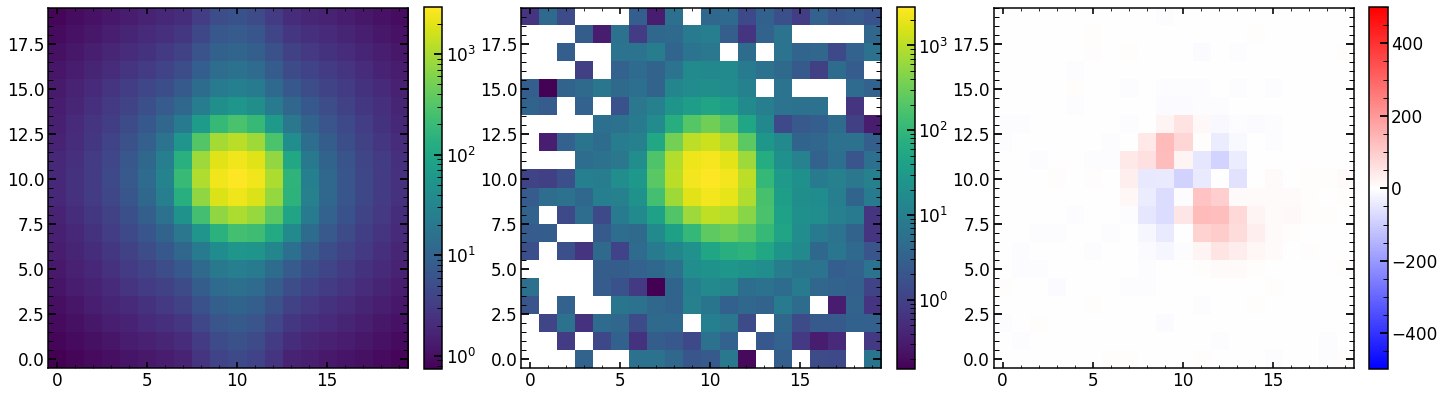

In [799]:

plt.figure(figsize=(24,10))
plt.subplot(131)
plt.imshow(best_result_from_Tokovinin_5_0[5][0],norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.imshow(list_of_sci_images[index_of_single_image],norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(133)
plt.imshow(list_of_sci_images[index_of_single_image]-best_result_from_Tokovinin_5_0[5][0],cmap='bwr',vmin=-500,vmax=500)
cbar=plt.colorbar(fraction=0.046, pad=0.04)



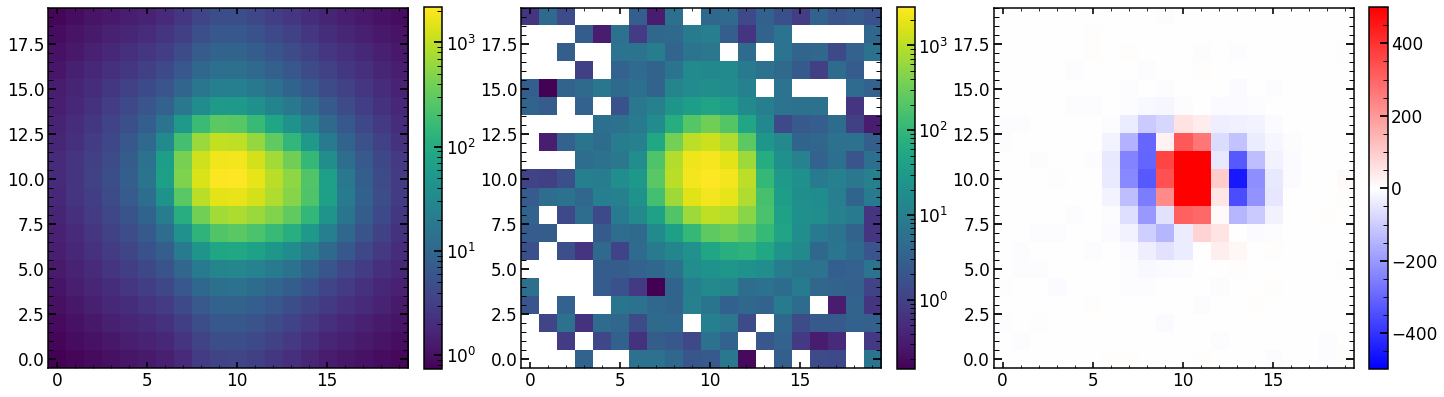

In [800]:

plt.figure(figsize=(24,10))
plt.subplot(131)
plt.imshow(best_result_from_Tokovinin_5_0[6][0],norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(132)
plt.imshow(list_of_sci_images[index_of_single_image],norm=LogNorm())
cbar=plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(133)
plt.imshow(list_of_sci_images[index_of_single_image]-best_result_from_Tokovinin_5_0[6][0],cmap='bwr',vmin=-500,vmax=500)
cbar=plt.colorbar(fraction=0.046, pad=0.04)

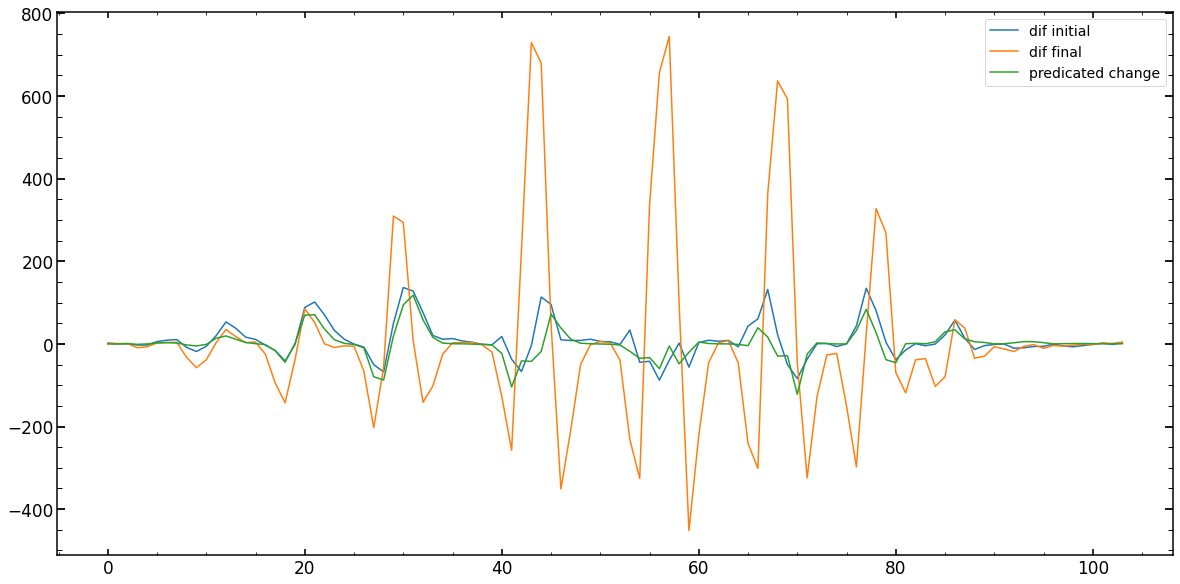

In [801]:
predicted_change=np.dot(H,first_proposal_Tokovnin).ravel()

plt.figure(figsize=(20,10))
plt.plot(uber_I_only_focus-uber_M0_only_focus,label='dif initial')

plt.plot(uber_I_only_focus-uber_M_final,label='dif final')

plt.plot(predicted_change,label='predicated change')

plt.legend()

In [756]:
# ratio between current parametrization and the previous (provided) changed parametrization
ratio_of_parametrizations=(array_of_delta_parametrizations[:,None]/array_of_delta_parametrizations_None_previous_best)

# create the array of how wavefront changes the uber_model by multiply the changes with new ratios
array_of_wavefront_changes_dedicated=np.transpose(ratio_of_parametrizations*\
                                        np.array(uber_images_normalized_previous_best_dedicated-uber_M0_previous_best_dedicated)/(array_of_delta_parametrizations_None_previous_best))  

NameError: name 'array_of_delta_parametrizations' is not defined

In [735]:
t/array_of_delta_z_parametrizations

array([  0.        ,  -8.67181821,   0.        ,  63.33472987,
         0.        ,  25.1642142 ,   0.        , -40.90583065,
         0.        ,  78.3494008 ,   0.        ,  31.37503421,
         0.        ,  18.88285236,   0.        ,  19.71306729])

In [805]:
H

array([[ 0.        ,  0.21687328,  0.        , ...,  0.04873253,
         0.        ,  0.00458006],
       [ 0.        ,  0.87649218,  0.        , ...,  0.42596568,
         0.        ,  0.08901247],
       [ 0.        ,  1.21077983,  0.        , ...,  0.31370331,
         0.        ,  0.1603021 ],
       ...,
       [ 0.        ,  0.26562178,  0.        , ..., -0.51751181,
         0.        , -0.05396505],
       [ 0.        ,  0.05732108,  0.        , ..., -0.07378933,
         0.        , -0.00557573],
       [ 0.        , -0.23768629,  0.        , ...,  0.37881154,
         0.        ,  0.05097806]])

In [806]:
np.nan_to_num(H,0)

array([[ 0.        ,  0.21687328,  0.        , ...,  0.04873253,
         0.        ,  0.00458006],
       [ 0.        ,  0.87649218,  0.        , ...,  0.42596568,
         0.        ,  0.08901247],
       [ 0.        ,  1.21077983,  0.        , ...,  0.31370331,
         0.        ,  0.1603021 ],
       ...,
       [ 0.        ,  0.26562178,  0.        , ..., -0.51751181,
         0.        , -0.05396505],
       [ 0.        ,  0.05732108,  0.        , ..., -0.07378933,
         0.        , -0.00557573],
       [ 0.        , -0.23768629,  0.        , ...,  0.37881154,
         0.        ,  0.05097806]])

array([[nan,  1.],
       [ 2., nan]])

In [808]:
np.nan_to_num(np.array([[np.nan,1],[2,np.nan]]),0)

array([[0., 1.],
       [2., 0.]])

In [811]:
np.maximum(array_of_delta_z_parametrizations,first_proposal_Tokovnin)

array([0.0025    , 0.24416923, 0.00204124, 0.73165422, 0.00176777,
       0.18300225, 0.00158114, 0.01507557, 0.00144338, 1.07220184,
       0.00133631, 0.01290994, 0.00125   , 0.76515564, 0.00117851,
       0.25773093, 0.00111803, 0.01091089, 0.001066  , 0.01042572,
       0.00102062, 0.01      , 0.00098058, 0.0096225 , 0.00094491,
       0.00928477, 0.00091287, 0.00898027, 0.00088388, 0.00870388,
       0.00085749, 0.00845154, 0.00083333, 0.00821995, 0.00081111,
       0.00800641, 0.00079057, 0.00780869, 0.00077152, 0.00762493,
       0.00075378, 0.00745356, 0.00073721, 0.00729325, 0.00072169,
       0.00714286, 0.00070711, 0.0070014 , 0.00069338, 0.00686803,
       0.00068041, 0.006742  , 0.00066815, 0.00662266, 0.00065653,
       0.00650945, 0.0006455 , 0.00640184, 0.000635  , 0.00629941,
       0.000625  , 0.00620174, 0.00061546, 0.00610847, 0.00060634,
       0.00601929, 0.00059761, 0.00593391, 0.00058926, 0.00585206,
       0.00058124, 0.0057735 , 0.00057354, 0.00569803, 0.00056

In [823]:
            list_of_delta_z_parametrizations=[]
            for z_par in range(0,19*2+2*number_of_extra_zernike):
                z_par_i=z_par+4
                # if this is the parameter that change
                if np.mod(z_par_i,2)==0:
                    list_of_delta_z_parametrizations.append(0.1*0.05/np.sqrt(z_par_i))
                if np.mod(z_par_i,2)==1:
                    list_of_delta_z_parametrizations.append(0.05/np.sqrt(z_par_i))
                        
            array_of_delta_z_parametrizations=np.array(list_of_delta_z_parametrizations)*(1)
            array_of_delta_z_parametrizations

array([0.0025    , 0.02236068, 0.00204124, 0.01889822, 0.00176777,
       0.01666667, 0.00158114, 0.01507557, 0.00144338, 0.0138675 ,
       0.00133631, 0.01290994, 0.00125   , 0.01212678, 0.00117851,
       0.01147079, 0.00111803, 0.01091089, 0.001066  , 0.01042572,
       0.00102062, 0.01      , 0.00098058, 0.0096225 , 0.00094491,
       0.00928477, 0.00091287, 0.00898027, 0.00088388, 0.00870388,
       0.00085749, 0.00845154, 0.00083333, 0.00821995, 0.00081111,
       0.00800641, 0.00079057, 0.00780869, 0.00077152, 0.00762493,
       0.00075378, 0.00745356, 0.00073721, 0.00729325, 0.00072169,
       0.00714286, 0.00070711, 0.0070014 , 0.00069338, 0.00686803,
       0.00068041, 0.006742  , 0.00066815, 0.00662266, 0.00065653,
       0.00650945, 0.0006455 , 0.00640184, 0.000635  , 0.00629941,
       0.000625  , 0.00620174, 0.00061546, 0.00610847, 0.00060634,
       0.00601929, 0.00059761, 0.00593391, 0.00058926, 0.00585206,
       0.00058124, 0.0057735 , 0.00057354, 0.00569803, 0.00056

In [833]:
array_of_multi_background_factors=np.concatenate((np.arange(3,3,-(3-3)/(nsteps-1)),np.array([3])) )
array_of_multi_background_factors

ZeroDivisionError: float division by zero

In [836]:
array_of_multi_background_factors=np.ones((nsteps))*3
array_of_multi_background_factors

array([3., 3., 3.])

In [841]:
list_of_particle_postion_focus_proposal=[]
for l in range(len(array_of_particle_position_proposal)):
    list_of_minchain=model_multi.create_list_of_allparameters(array_of_particle_position_proposal[0],\
                                                          list_of_defocuses=['0'],zmax=56)
    list_of_particle_postion_focus_proposal.append(list_of_minchain)

array_of_particle_postion_focus_proposal=np.array(list_of_particle_postion_focus_proposal)

In [880]:
list_of_minchain[0]

array([    0.03305758,    -0.91129426,    -0.54302017,    -0.34325149,
           0.40795935,    -0.44396466,    -0.57982209,     0.54374951,
           0.01886295,     0.20247791,    -0.04694434,     0.01222624,
           0.03680648,     0.03962365,     0.0319801 ,    -0.03244641,
          -0.03921772,     0.01216259,     0.03708531,     0.70255835,
           0.10599709,    -0.21711041,     0.27352715,     0.0627802 ,
           0.10376147,     0.25      ,     0.25      ,     0.25      ,
           1.        ,    -0.03620577,    -0.01351665,     0.89335116,
           0.02591337,     0.73920926,     1.04663307,     0.59825735,
       25718.09765165,     2.31572029,     0.00717128,     0.48939688,
           1.84215377,     0.99083419,    -0.01511988,    -0.01584725,
          -0.00785104,     0.00851931,     0.0022975 ,    -0.000155  ,
          -0.01416621,     0.00245813,    -0.01031893,     0.01306438,
           0.00319384,    -0.02084817,     0.00160031,     0.01114524,
      

In [844]:
allparameters_proposal_22=list_of_minchain[0]

In [854]:
stronger_array_01=np.array([1,0,0,0,0,0,0,0,
                                0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,
                                0.0,0.0,0.0,0.0,0.0,0.0,
                                0,0,0,0,
                                0,0,0,
                                0,0,0,0,
                                1,1,1,
                                1,1,1])  
zmax_input=22
stronger_array_01=np.concatenate((stronger_array_01,np.zeros((zmax_input-22))))
stronger_array_01

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1.])

In [876]:
zmax_input=56    
print('allparameters_proposal_22: '+str(allparameters_proposal_22))
parInit1=create_parInit(allparameters_proposal=allparameters_proposal_22,multi=None,pupil_parameters=None,\
                        allparameters_proposal_err=None,\
                        stronger=stronger_array_01,use_optPSF=None,deduced_scattering_slope=None,zmax=zmax_input)

allparameters_proposal_22: [    0.03305758    -0.91129426    -0.54302017    -0.34325149
     0.40795935    -0.44396466    -0.57982209     0.54374951
     0.01886295     0.20247791    -0.04694434     0.01222624
     0.03680648     0.03962365     0.0319801     -0.03244641
    -0.03921772     0.01216259     0.03708531     0.70255835
     0.10599709    -0.21711041     0.27352715     0.0627802
     0.10376147     0.25           0.25           0.25
     1.            -0.03620577    -0.01351665     0.89335116
     0.02591337     0.73920926     1.04663307     0.59825735
 25718.09765165     2.31572029     0.00717128     0.48939688
     1.84215377     0.99083419    -0.01511988    -0.01584725
    -0.00785104     0.00851931     0.0022975     -0.000155
    -0.01416621     0.00245813    -0.01031893     0.01306438
     0.00319384    -0.02084817     0.00160031     0.01114524
     0.00307501    -0.00239154    -0.00073899     0.00217737
     0.01019274    -0.00834874     0.00685014    -0.01084985
    -0

In [867]:
?? find_centroid_of_flux

In [877]:
14139*0.9

12725.1

In [928]:
out20=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test_2/out20.npy',allow_pickle=True)
out21=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test_2/out21.npy',allow_pickle=True)


best_particle0=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test_2/best_particle0.npy',allow_pickle=True)
best_particle1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test_2/best_particle1.npy',allow_pickle=True)

best_result0=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test_2/best_result0.npy',allow_pickle=True)
best_result1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test_2/best_result1.npy',allow_pickle=True)

array_of_particle_position_proposal0=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test_2/array_of_particle_position_proposal0.npy',allow_pickle=True)
array_of_particle_position_proposal1=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test_2/array_of_particle_position_proposal1.npy',allow_pickle=True)

In [932]:
out20[12][2]

array([    4.50030168,    -0.63775652,    -0.33172367,    -0.39387243,
           0.2183226 ,    -0.37758738,    -0.53761969,     0.8026604 ,
           0.01886295,     0.20247791,    -0.04694434,     0.01222624,
           0.03680648,     0.03962365,     0.0319801 ,    -0.03244641,
          -0.03921772,     0.01216259,     0.03708531,     0.70255835,
           0.10599709,    -0.21711041,     0.27352715,     0.0627802 ,
           0.10376147,     0.25      ,     0.25      ,     0.25      ,
           1.        ,    -0.03620577,    -0.01351665,     0.89335116,
           0.02591337,     0.73920926,     1.04663307,     0.59825735,
       85051.83246867,     1.55034087,     0.0082512 ,     0.62497022,
           1.76719692,     0.99751371,    -0.01511988,    -0.01584725,
          -0.00785104,     0.00851931,     0.0022975 ,    -0.000155  ,
          -0.01416621,     0.00245813,    -0.01031893,     0.01306438,
           0.00319384,    -0.02084817,     0.00160031,     0.01114524,
      

In [974]:
gbests_positions=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Test_2/chainMay1221_Single_P_34389116Arres_gbests_position.npy')
gbests_positions[-1]

array([    0.26171978,    -0.94039191,    -0.5919298 ,    -0.62910179,
           0.77424995,    -0.72266234,    -0.92990731,     0.83330667,
           0.03863879,     0.22954357,    -0.04948961,     0.03281349,
           0.0587434 ,     0.050954  ,     0.02756475,    -0.03203576,
          -0.03294923,     0.02517083,     0.04498642,     0.6982929 ,
           0.10099376,    -0.22868679,     0.27114778,     0.06266987,
           0.10090548,     0.2078081 ,     0.31853494,     0.31105295,
           1.28564277,    -0.0509813 ,    -0.0183548 ,     0.87879873,
           0.03103068,     0.7212447 ,     1.04674646,     0.57226047,
       41743.30611071,     2.3012498 ,     0.00531958,     0.35327868,
           1.78696424,     0.98282497,    -0.01291785,    -0.01807254,
          -0.00805709,     0.01291273,     0.00101384,     0.00141808,
          -0.01207241,     0.00628245,    -0.00219551,     0.01574115,
           0.00356404,    -0.0226188 ,     0.00086017,     0.01206215,
      

In [975]:
res_test=model(gbests_positions[-1],return_Image=True)


Entering lnlike_Neven
allparameters [    0.26171978    -0.94039191    -0.5919298     -0.62910179
     0.77424995    -0.72266234    -0.92990731     0.83330667
     0.03863879     0.22954357    -0.04948961     0.03281349
     0.0587434      0.050954       0.02756475    -0.03203576
    -0.03294923     0.02517083     0.04498642     0.6982929
     0.10099376    -0.22868679     0.27114778     0.06266987
     0.10090548     0.2078081      0.31853494     0.31105295
     1.28564277    -0.0509813     -0.0183548      0.87879873
     0.03103068     0.7212447      1.04674646     0.57226047
 41743.30611071     2.3012498      0.00531958     0.35327868
     1.78696424     0.98282497    -0.01291785    -0.01807254
    -0.00805709     0.01291273     0.00101384     0.00141808
    -0.01207241     0.00628245    -0.00219551     0.01574115
     0.00356404    -0.0226188      0.00086017     0.01206215
     0.00444335    -0.00095454    -0.00213609     0.00216633
     0.01068864    -0.00586613     0.00746922    

We are fitting for only one source
One source fitting result is [-3.90591631 -4.64877684]
type(complete_realization_renormalized)<class 'numpy.float32'>
Time for single_Psf_position protocol is 0.28982114791870117
Sucesfully created optPsf_cut_fiber_convolved_downsampled
Finished with optPsf_postprocessing
 
Internally fitting for flux; disregarding passed value for flux
Internally fitting for flux; multiplying all values in the model by 0.9956606666189773
Finished with lnlike_Neven
chi_2_almost/d.o.f is 10.024325; chi_2_almost_max_dof is 2514.4185 log(improvment) is -2.3993824
The likelihood reported is: -1233.0096435546875
multiprocessing.current_process() <_MainProcess name='MainProcess' parent=None started> thread 4489811392
uname_result(system='Darwin', node='IapetusUSA', release='18.7.0', version='Darwin Kernel Version 18.7.0: Tue Aug 20 16:57:14 PDT 2019; root:xnu-4903.271.2~2/RELEASE_X86_64', machine='x86_64', processor='i386')
Time for lnlike_Neven function in thread 448981139

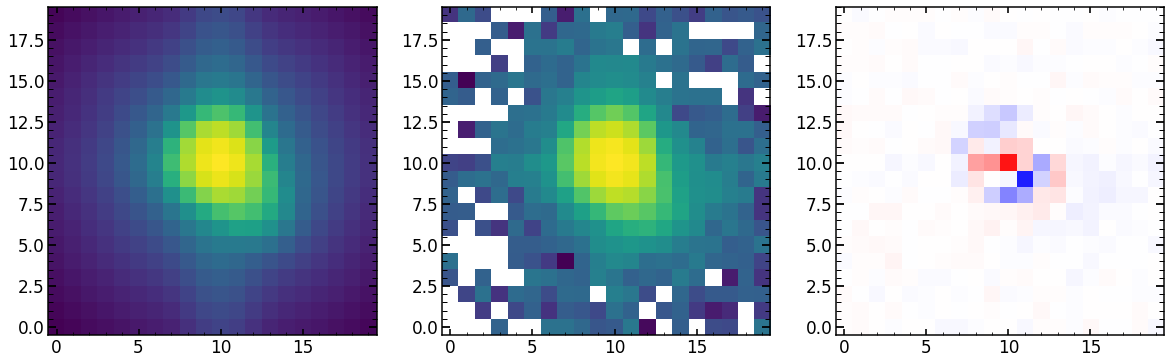

In [977]:
plt.figure(figsize=(20,10))
plt.subplot(131)
plt.imshow(res_test[1],norm=LogNorm())

plt.subplot(132)
plt.imshow(list_of_sci_images[4],norm=LogNorm())

plt.subplot(133)
plt.imshow(res_test[1]-list_of_sci_images[4],cmap='bwr',vmin=-200,vmax=200)

In [979]:
minchain_focus_proposed=gbests_positions[-1]
minchain_focus_proposed

array([    0.26171978,    -0.94039191,    -0.5919298 ,    -0.62910179,
           0.77424995,    -0.72266234,    -0.92990731,     0.83330667,
           0.03863879,     0.22954357,    -0.04948961,     0.03281349,
           0.0587434 ,     0.050954  ,     0.02756475,    -0.03203576,
          -0.03294923,     0.02517083,     0.04498642,     0.6982929 ,
           0.10099376,    -0.22868679,     0.27114778,     0.06266987,
           0.10090548,     0.2078081 ,     0.31853494,     0.31105295,
           1.28564277,    -0.0509813 ,    -0.0183548 ,     0.87879873,
           0.03103068,     0.7212447 ,     1.04674646,     0.57226047,
       41743.30611071,     2.3012498 ,     0.00531958,     0.35327868,
           1.78696424,     0.99566067,    -0.01291785,    -0.01807254,
          -0.00805709,     0.01291273,     0.00101384,     0.00141808,
          -0.01207241,     0.00628245,    -0.00219551,     0.01574115,
           0.00356404,    -0.0226188 ,     0.00086017,     0.01206215,
      

In [981]:
list_of_minchain=model_multi.create_list_of_allparameters(minchain_parametrization,list_of_defocuses=list_of_defocuses_input_long,zmax=56)
list_of_minchain[4]

array([    0.16492145,    -0.88632798,    -0.51669564,    -0.31938941,
           0.50845528,    -0.4275001 ,    -0.58096021,     0.58544687,
           0.03863879,     0.22954357,    -0.04948961,     0.03281349,
           0.0587434 ,     0.050954  ,     0.02756475,    -0.03203576,
          -0.03294923,     0.02517083,     0.04498642,     0.6982929 ,
           0.10099376,    -0.22868679,     0.27114778,     0.06266987,
           0.10090548,     0.2078081 ,     0.31853494,     0.31105295,
           1.28564277,    -0.0509813 ,    -0.0183548 ,     0.87879873,
           0.03103068,     0.7212447 ,     1.04674646,     0.57226047,
       30096.76438941,     2.31074047,     0.00645553,     0.49203847,
           1.83713253,     0.99250387,    -0.01291785,    -0.01807254,
          -0.00805709,     0.01291273,     0.00101384,     0.00141808,
          -0.01207241,     0.00628245,    -0.00219551,     0.01574115,
           0.00356404,    -0.0226188 ,     0.00086017,     0.01206215,
      

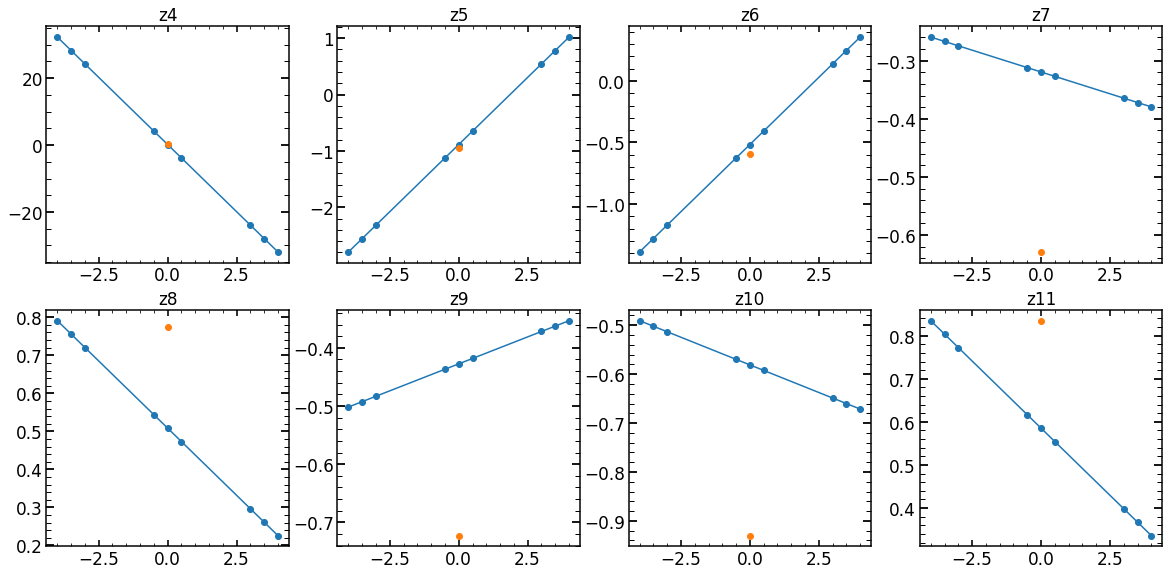

In [1007]:
plt.figure(figsize=(20,20))

for i in range(8):
    plt.subplot(4,4,i+1)
    
    points_single_par=np.array([[-4,list_of_minchain[0][i]],[-3.5,list_of_minchain[1][i]],[-3,list_of_minchain[2][i]],\
              [-0.5,list_of_minchain[3][i]],[0,list_of_minchain[4][i]],[0.5,list_of_minchain[5][i]],\
              [3,list_of_minchain[6][i]],[3.5,list_of_minchain[7][i]],[4,list_of_minchain[8][i]]])

    plt.plot(points_single_par[:,0],points_single_par[:,1],marker='o')
    plt.plot(0,minchain_focus_proposed[i],marker='o')
    plt.title('z'+str(i+4))



In [1015]:
minchain_parametrization_test=np.copy(minchain_parametrization)
for i in range(8):
    minchain_parametrization_test[i*2+1]=minchain_focus_proposed[i]

In [1018]:
minchain_parametrization_test-minchain_parametrization

array([ 0.        ,  0.09679832,  0.        , -0.05406393,  0.        ,
       -0.07523416,  0.        , -0.30971238,  0.        ,  0.26579467,
        0.        , -0.29516224,  0.        , -0.3489471 ,  0.        ,
        0.2478598 ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [1017]:
minchain_parametrization

array([   -8.0244858 ,     0.16492145,     0.47602686,    -0.88632798,
           0.21807862,    -0.51669564,    -0.01501342,    -0.31938941,
          -0.07063251,     0.50845528,     0.01854382,    -0.4275001 ,
          -0.02258284,    -0.58096021,    -0.06232856,     0.58544687,
          -0.00323915,     0.03863879,    -0.00228845,     0.22954357,
           0.0255806 ,    -0.04948961,     0.00145377,     0.03281349,
           0.0064667 ,     0.0587434 ,    -0.01380491,     0.050954  ,
           0.00260011,     0.02756475,    -0.00081079,    -0.03203576,
           0.00305707,    -0.03294923,     0.00756859,     0.02517083,
          -0.02024821,     0.04498642,     0.6982929 ,     0.10099376,
          -0.22868679,     0.27114778,     0.06266987,     0.10090548,
           0.2078081 ,     0.31853494,     0.31105295,     1.28564277,
          -0.0509813 ,    -0.0183548 ,     0.87879873,     0.03103068,
           0.7212447 ,     1.04674646,     0.57226047, 30096.76438941,
      

In [1057]:
results_of_fit_many_direct_Ar=np.load('/Users/nevencaplar/Documents/PFS/Fit_Results/Apr1421/results_of_fit_many_direct_Ar_from_Apr1421.pkl',allow_pickle=True)
results_of_fit_many_direct_Ne=np.load('/Users/nevencaplar/Documents/PFS/Fit_Results/Apr1421/results_of_fit_many_direct_Ne_from_Apr1421.pkl',allow_pickle=True)
results_of_fit_many_direct_Kr=np.load('/Users/nevencaplar/Documents/PFS/Fit_Results/Apr1421/results_of_fit_many_direct_Kr_from_Apr1421.pkl',allow_pickle=True)

In [1058]:
print(len(results_of_fit_many_direct_Ar['m4']))
print(len(results_of_fit_many_direct_Ne['m4']))
print(len(results_of_fit_many_direct_Kr['m4']))

83
16
8


In [1062]:
# in minutes
((83+15+8)*(160))/3600

4.711111111111111

In [1060]:
530/60

8.833333333333334

In [1068]:
results_of_fit_many_direct_Ar['0'].loc['11']

z4         0.141509
z5        -0.866217
z6        -0.492212
z7        -0.350574
z8         0.462323
             ...   
z54        0.001938
z55        0.004467
z56       -0.000056
chi2       5.060300
chi2max    5.401278
Name: 11, Length: 78, dtype: float64

In [1069]:
    allparameters_proposal_22=np.array([    0.16492145,    -0.88632798,    -0.51669564,    -0.31938941,
           0.50845528,    -0.4275001 ,    -0.58096021,     0.58544687,
           0.03863879,     0.22954357,    -0.04948961,     0.03281349,
           0.0587434 ,     0.050954  ,     0.02756475,    -0.03203576,
          -0.03294923,     0.02517083,     0.04498642,     0.6982929 ,
           0.10099376,    -0.22868679,     0.27114778,     0.06266987,
           0.10090548,     0.2078081 ,     0.31853494,     0.31105295,
           1.28564277,    -0.0509813 ,    -0.0183548 ,     0.87879873,
           0.03103068,     0.7212447 ,     1.04674646,     0.57226047,
       30096.76438941,     2.31074047,     0.00645553,     0.49203847,
           1.83713253,     0.99250387,    -0.01291785,    -0.01807254,
          -0.00805709,     0.01291273,     0.00101384,     0.00141808,
          -0.01207241,     0.00628245,    -0.00219551,     0.01574115,
           0.00356404,    -0.0226188 ,     0.00086017,     0.01206215,
           0.00444335,    -0.00095454,    -0.00213609,     0.00216633,
           0.01068864,    -0.00586613,     0.00746922,    -0.00992799,
          -0.00369008,    -0.01585207,    -0.00102798,     0.00326984,
          -0.00046356,    -0.00617323,    -0.01062363,     0.00643621,
           0.00136246,     0.00197025,     0.00300083,     0.0008643 ])

In [1070]:
allparameters_proposal_22.shape

(76,)

In [1074]:
results_of_fit_input=results_of_fit_many_direct_Ar
labelInput='0'
allparameters_proposalp2=results_of_fit_input[labelInput].loc[11].values

TypeError: cannot do label indexing on <class 'pandas.core.indexes.base.Index'> with these indexers [11] of <class 'int'>

In [1079]:
results_of_fit_input[labelInput].loc['119']

z4        -0.110626
z5         0.307557
z6        -0.405004
z7        -0.141118
z8        -0.769986
             ...   
z54       -0.008748
z55        0.004465
z56       -0.004019
chi2       5.578534
chi2max    6.262082
Name: 119, Length: 78, dtype: float64

In [1080]:
results_of_fit_many_direct_Ar=pickle.load('/Users/nevencaplar/Documents/PFS/Fit_Results/Apr1421/results_of_fit_many_direct_Ar_from_Apr1421.pkl')


TypeError: file must have 'read' and 'readline' attributes

In [1082]:
with open('/Users/nevencaplar/Documents/PFS/Fit_Results/Apr1421/results_of_fit_many_direct_Ar_from_Apr1421.pkl', 'rb') as f:
    results_of_fit_input_HgAr=pickle.load(f)

In [1085]:
results_of_fit_input_HgAr

{'m4':             z4        z5        z6        z7        z8        z9       z10  \
 1    30.290384 -0.644932  0.064155  0.388022  0.307304  0.195472 -0.339191   
 100  30.585876  0.288952 -0.276118  0.338667 -0.720702 -0.015958 -0.398630   
 101  30.613730  0.404984 -0.456706  0.211602 -0.701137  0.031037 -0.382912   
 102  29.782121  0.936275 -0.781658  0.068944 -0.724301 -0.068564 -0.314337   
 103  29.604000  1.161121 -0.779373  0.145028 -0.635748 -0.047075 -0.349592   
 ..         ...       ...       ...       ...       ...       ...       ...   
 93   31.058508  0.849810 -1.661763 -0.013216 -0.386707 -0.125456 -0.369292   
 95   31.392135  0.995179 -2.075854 -0.088601 -0.356210 -0.130338 -0.245515   
 97   30.324235 -0.047577 -0.299759  0.376226 -0.782590  0.021636 -0.288402   
 98   30.101740  0.083810 -0.357582  0.327705 -0.642663  0.026658 -0.294792   
 99   29.944398  0.481207 -0.791697  0.317473 -0.749966 -0.041459 -0.309717   
 
           z11       z12       z13  ...     

# May13 (focus run)

In [ ]:
import glob

finalAr=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalAr_flip.pkl",allow_pickle=True)
finalNe=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalNe_flip.pkl",allow_pickle=True)
finalKr=np.load("/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalKr_flip.pkl",allow_pickle=True)

def remove(string): 
    return string.replace(" ", "")

## scripts 

### first scripts

In [1158]:
results_of_fit_many_direct_Ar=np.load('/Users/nevencaplar/Documents/PFS/Fit_Results/Apr1421/results_of_fit_many_direct_Ar_from_Apr1421.pkl',allow_pickle=True)
results_of_fit_many_direct_Ne=np.load('/Users/nevencaplar/Documents/PFS/Fit_Results/Apr1421/results_of_fit_many_direct_Ne_from_Apr1421.pkl',allow_pickle=True)
results_of_fit_many_direct_Kr=np.load('/Users/nevencaplar/Documents/PFS/Fit_Results/Apr1421/results_of_fit_many_direct_Kr_from_Apr1421.pkl',allow_pickle=True)

In [1159]:

#list_of_HgAr_to_analyze=finalHgAr_Feb2020_dataset[finalHgAr_Feb2020_dataset['close']=='1'].index
list_of_Ar_to_analyze=finalAr[finalAr['close']=='1'].index & finalAr[finalAr['xc']<3000].index
list_of_Ne_to_analyze=finalNe[finalNe['close']=='1'].index & finalNe[finalNe['xc']<3000].index
list_of_Kr_to_analyze=finalKr[finalKr['close']==1].index & finalKr[finalKr['xc']<3000].index

#print(len(list_of_HgAr_to_analyze))
print(len(list_of_Ar_to_analyze))
print(len(list_of_Ne_to_analyze))
print(len(list_of_Kr_to_analyze))

print(list_of_Ar_to_analyze)
print(list_of_Ne_to_analyze)
print(list_of_Kr_to_analyze)


64
32
8
Int64Index([ 1,  3,  5,  6,  7,  8,  9, 11, 13, 15, 17, 18, 19, 20, 21, 23, 25,
            27, 29, 30, 31, 32, 33, 35, 37, 39, 41, 42, 43, 44, 45, 47, 49, 51,
            53, 54, 55, 56, 57, 59, 61, 63, 65, 66, 67, 68, 69, 71, 73, 75, 77,
            78, 79, 80, 81, 83, 85, 87, 89, 90, 91, 92, 93, 95],
           dtype='int64')
Int64Index([ 2,  5,  6,  7, 11, 14, 15, 16, 20, 23, 24, 25, 29, 32, 33, 34, 38,
            41, 42, 43, 47, 50, 51, 52, 56, 59, 60, 61, 65, 68, 69, 70],
           dtype='int64')
Int64Index([3, 7, 11, 15, 19, 23, 27, 31], dtype='int64')


In [1132]:
results_of_fit_many_direct_Ar['0'].index.values

array(['1', '100', '101', '102', '103', '104', '105', '106', '107', '109',
       '11', '110', '111', '112', '113', '114', '115', '116', '117',
       '118', '119', '13', '15', '17', '18', '19', '20', '21', '23', '25',
       '27', '29', '3', '30', '32', '33', '37', '39', '41', '42', '43',
       '44', '47', '49', '5', '51', '53', '54', '55', '56', '57', '59',
       '6', '61', '63', '65', '66', '67', '68', '69', '7', '71', '73',
       '75', '77', '78', '79', '8', '80', '81', '83', '85', '87', '89',
       '9', '90', '91', '92', '93', '95', '97', '98', '99'], dtype=object)

In [1160]:
len(results_of_fit_many_direct_Ar['0'].index.values)

83

In [1134]:
date='May1321'


file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T_Ar_1_'+date+'.sh','w') 

for single_spot in results_of_fit_many_direct_Ar['0'].index.values.astype(int):
    if str(finalAr.loc[single_spot]['close'])=='0' or str(finalAr.loc[single_spot]['close'])=='0.5':
        double_source=True
    else:
        double_source=False    
        

    file.write("python /home/ncaplar/Code/Zernike_parameter_estimation.py -obs 34389 -spot "+str(single_spot)+\
               " -nsteps 13 -eps 6 -dataset 6 -arc Ar -double_sources "+str(double_source)+\
               " -double_sources_positions_ratios "+remove(str(list(finalAr.loc[single_spot][['second_offset','second_ratio']].values)))+\
               " -twentytwo_or_extra 56 -date_of_input Apr1421 -direct_or_interpolation direct -date_of_output "+date+" -analysis_type focus \n")

file.close()    
  




### 2nd script 

In [ ]:
results_of_fit_many_direct_Ar['0'].index.values

In [1162]:
analyzed_Ar_images[:,1]

array(['100', '101', '102', '103', '104', '105', '106', '107', '109',
       '110', '111', '112', '113', '114', '115', '116', '11', '118',
       '119', '13', '15', '1', '17', '18', '19', '20', '21', '23', '25',
       '29', '30', '32', '33', '3', '37', '39', '41', '42', '43', '47',
       '49', '51', '53', '54', '5', '57', '59', '61', '63', '65', '6',
       '69', '71', '7', '78', '80', '81', '83', '8', '87', '89', '90',
       '91', '92', '95', '9', '97', '98', '99'], dtype='<U21')

In [1166]:
values_for_2nd_focus_script=np.setdiff1d(results_of_fit_many_direct_Ar['0'].index.values,analyzed_Ar_images[:,1])
values_for_2nd_focus_script

array(['117', '27', '44', '55', '56', '66', '67', '68', '73', '75', '77',
       '79', '85', '93'], dtype=object)

In [1182]:
date='May1321'


file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/T_Ar_2_'+date+'.sh','w') 

for single_spot in values_for_2nd_focus_script.astype(int):
    if str(finalAr.loc[single_spot]['close'])=='0' or str(finalAr.loc[single_spot]['close'])=='0.5':
        double_source=True
    else:
        double_source=False    
        

    file.write("python /home/ncaplar/Code/Zernike_parameter_estimation.py -obs 34389 -spot "+str(single_spot)+\
               " -nsteps 13 -eps 6 -dataset 6 -arc Ar -double_sources "+str(double_source)+\
               " -double_sources_positions_ratios "+remove(str(list(finalAr.loc[single_spot][['second_offset','second_ratio']].values)))+\
               " -twentytwo_or_extra 56 -date_of_input Apr1421 -direct_or_interpolation direct -date_of_output "+date+" -analysis_type focus \n")

file.close()    
  


## which are avaliable 

In [1200]:
date='May1321'

ResultsFromTiger_FOLDER='/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/'


Emcee3_HgAr=glob.glob(ResultsFromTiger_FOLDER+date+'/chain'+date+'_Single_P_*HgArSwarm1.npy', recursive=True)

Emcee3_Ar=glob.glob(ResultsFromTiger_FOLDER+date+'/chain'+date+'_Single_P_*ArSwarm1.npy', recursive=True)
Emcee3_Ne=glob.glob(ResultsFromTiger_FOLDER+date+'/chain'+date+'_Single_P_*NeSwarm1.npy', recursive=True)
Emcee3_Kr=glob.glob(ResultsFromTiger_FOLDER+date+'/chain'+date+'_Single_P_*KrSwarm1.npy', recursive=True)

In [1201]:
eps_value=6

analyzed_Neon_images=[]
for i in range(len(Emcee3_Ne)):
    single_string=Emcee3_Ne[i][len(ResultsFromTiger_FOLDER)+30:len(Emcee3_Ne[i])-13]
    # only select images with a given eps
    if Emcee3_Ne[i][Emcee3_Ne[i].find('Ne')-1:Emcee3_Ne[i].find('Ne')]==str(eps_value):
        analyzed_Neon_images.append([int(single_string[:5]),int(single_string[5:]),'Ne'])
   
analyzed_Neon_images=np.array(analyzed_Neon_images)
###########
analyzed_Ar_images=[]
for i in range(len(Emcee3_Ar)):
    single_string=Emcee3_Ar[i][len(ResultsFromTiger_FOLDER)+30:len(Emcee3_Ar[i])-13]
    # only select images with a given eps
    if Emcee3_Ar[i][Emcee3_Ar[i].find('Ar')-1:Emcee3_Ar[i].find('Ar')]==str(eps_value):
        analyzed_Ar_images.append([int(single_string[:5]),int(single_string[5:]),'Ar'])
 

analyzed_Ar_images=np.array(analyzed_Ar_images)
###########
analyzed_Kr_images=[]
for i in range(len(Emcee3_Kr)):
    single_string=Emcee3_Kr[i][len(ResultsFromTiger_FOLDER)+30:len(Emcee3_Kr[i])-13]
    # only select images with a given eps
    if Emcee3_Kr[i][Emcee3_Kr[i].find('Kr')-1:Emcee3_Kr[i].find('Kr')]==str(eps_value):
        analyzed_Kr_images.append([int(single_string[:5]),int(single_string[5:]),'Kr'])
    
analyzed_Kr_images=np.array(analyzed_Kr_images)

In [1202]:
print(analyzed_Ar_images)
print(analyzed_Neon_images)
print(analyzed_Kr_images)

[['34389' '100' 'Ar']
 ['34389' '101' 'Ar']
 ['34389' '102' 'Ar']
 ['34389' '103' 'Ar']
 ['34389' '104' 'Ar']
 ['34389' '105' 'Ar']
 ['34389' '106' 'Ar']
 ['34389' '107' 'Ar']
 ['34389' '109' 'Ar']
 ['34389' '110' 'Ar']
 ['34389' '111' 'Ar']
 ['34389' '112' 'Ar']
 ['34389' '113' 'Ar']
 ['34389' '114' 'Ar']
 ['34389' '115' 'Ar']
 ['34389' '116' 'Ar']
 ['34389' '11' 'Ar']
 ['34389' '117' 'Ar']
 ['34389' '118' 'Ar']
 ['34389' '119' 'Ar']
 ['34389' '13' 'Ar']
 ['34389' '15' 'Ar']
 ['34389' '1' 'Ar']
 ['34389' '17' 'Ar']
 ['34389' '18' 'Ar']
 ['34389' '19' 'Ar']
 ['34389' '20' 'Ar']
 ['34389' '21' 'Ar']
 ['34389' '23' 'Ar']
 ['34389' '25' 'Ar']
 ['34389' '27' 'Ar']
 ['34389' '29' 'Ar']
 ['34389' '30' 'Ar']
 ['34389' '32' 'Ar']
 ['34389' '33' 'Ar']
 ['34389' '3' 'Ar']
 ['34389' '37' 'Ar']
 ['34389' '39' 'Ar']
 ['34389' '41' 'Ar']
 ['34389' '42' 'Ar']
 ['34389' '43' 'Ar']
 ['34389' '44' 'Ar']
 ['34389' '47' 'Ar']
 ['34389' '49' 'Ar']
 ['34389' '51' 'Ar']
 ['34389' '53' 'Ar']
 ['34389' '54' 'A

In [1203]:
if len(analyzed_Ar_images)>0:
    arranged_by_defocus_Ar=analyzed_Ar_images[analyzed_Ar_images[:,0].argsort()]
    arranged_by_spot_number_Ar=analyzed_Ar_images[analyzed_Ar_images[:,1].argsort()]
else:
    arranged_by_defocus_Ar=[]
    arranged_by_spot_number_Ar=[]

if len(analyzed_Neon_images)>0:
    arranged_by_defocus_Ne=analyzed_Neon_images[analyzed_Neon_images[:,0].argsort()]
    arranged_by_spot_number_Ne=analyzed_Neon_images[analyzed_Neon_images[:,1].argsort()]
else:
    arranged_by_defocus_Ne=[]
    arranged_by_spot_number_Ne=[]

if len(analyzed_Kr_images)>0:
    arranged_by_defocus_Kr=analyzed_Kr_images[analyzed_Kr_images[:,0].argsort()]
    arranged_by_spot_number_Kr=analyzed_Kr_images[analyzed_Kr_images[:,1].argsort()]
else:
    arranged_by_defocus_Kr=[]
    arranged_by_spot_number_Kr=[]
    
print('analyzed_Ar_images:'+str(len(analyzed_Ar_images))+' / '+'analyzed_Ne_images:'+str(len(analyzed_Neon_images))+' / '+'analyzed_Kr_images:'+str(len(analyzed_Kr_images)))

analyzed_Ar_images:83 / analyzed_Ne_images:0 / analyzed_Kr_images:0


## single image analysis 

In [1190]:
date='May1321'
#obs=34389
#obs_int=int(obs)
single_number='23'
image_index=int(single_number)
eps=6
arc='Ar'
dataset=6

if arc=='Ar':
    obs=34389
    finalArc=finalAr
if arc=='Ne':
    obs=34389
    finalArc=finalNe
if arc=='Kr':
    obs=34389
    finalArc=finalKr



list_of_defocuses_input_short=['m4','p4']
list_of_defocuses_input_long=['m4','m35','m3','m05','0','p05','p3','p35','p4']

finalArc.loc[int(single_number)]

fiber                  587
xc                     453
yc                    4020
wavelength        966.0642
close                    1
lamp                    Ar
xc_effective           453
second_offset            0
second_ratio             0
second2_offset           0
second2_ratio            0
Name: 23, dtype: object

In [1136]:
single_analysis=Zernike_Analysis(date=date,obs='m4',single_number=single_number,eps=eps,arc=arc,dataset=dataset,multi_var=False,\
                                 list_of_defocuses=list_of_defocuses_input_long)
single_analysis.create_basic_data_image()

STAMPS_FOLDER: /Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/


UnboundLocalError: local variable 'obs_single' referenced before assignment

In [1137]:
double_sources,double_sources_positions_ratios=single_analysis.return_double_sources()
list_of_sci_images,list_of_var_images,list_of_mask_images=single_analysis.return_lists_of_images()
index_of_single_image=single_analysis.return_index_of_single_image_in_list_of_images()
columns,columns22,columns22_analysis=single_analysis.return_columns()


chain0_swarm_1,likechain0_swarm_1=single_analysis.create_chains_swarm_1()
#chain0_Emcee3,likechain0_Emcee3=single_analysis.create_chains_Emcee_2()
len_of_chains=single_analysis.len_of_chains()

minchain_parametrization,like_min=single_analysis.create_likelihood()

Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Apr1421/chainApr1421_Single_P_3443736ArSwarm1.npy
Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Apr1421/chainApr1421_Single_P_3443736ArSwarm1.npy
(51, 480, 129)
Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Apr1421/chainApr1421_Single_P_3443736ArSwarm1.npy
(51, 480, 129)
minimal likelihood is: 2.859537045160929
average chi2 reduced is: -4.444352120235594


In [1191]:
for Argon_index in analyzed_Ar_images[:,1]:
    gbests_positions=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/May1321/chainMay1321_Single_P_34389'+\
                             Argon_index+'6Arres_gbests_position.npy')
    minchain_parametrization_focus=gbests_positions[-1]

    date='Apr1421'
    #obs=34313
    #obs_int=int(obs)
    single_number=str(Argon_index)
    image_index=int(single_number)
    eps=6
    arc='Ar'
    dataset=6

    if arc=='Ar':
        obs=34341+96
        finalArc=finalAr

    list_of_defocuses_input_short=['m4','p4']
    list_of_defocuses_input_long=['m4','m35','m3','m05','0','p05','p3','p35','p4']



    single_analysis=Zernike_Analysis(date=date,obs='m4',single_number=single_number,eps=eps,arc=arc,dataset=dataset,multi_var=True,\
                                     list_of_defocuses=list_of_defocuses_input_long)

    minchain_parametrization,like_min=single_analysis.create_likelihood()

STAMPS_FOLDER: /Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/
labelInput: m4
self.single_number: 100
list_of_defocuses: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
list_of_obs: [34341, 34347, 34353, 34383, 34389, 34395, 34425, 34431, 34437]
<_io.BufferedReader name='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalHgAr_Feb2020'>
analyzing label: 34341
double_sources_positions_ratios for this spot is: [-13.14 0.011]
Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Apr1421/chainApr1421_Single_P_344371006ArSwarm1.npy
(41, 480, 129)
minimal likelihood is: 5.166008710861206
average chi2 reduced is: -4.7614817005132535
STAMPS_FOLDER: /Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/
labelInput: m4
self.single_number: 101
list_of_defocuses: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
list_of_obs: [34341, 34347, 34353, 343

Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Apr1421/chainApr1421_Single_P_344371126ArSwarm1.npy
(41, 480, 129)
minimal likelihood is: 5.532273981306288
average chi2 reduced is: -4.754088456959487
STAMPS_FOLDER: /Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/
labelInput: m4
self.single_number: 113
list_of_defocuses: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
list_of_obs: [34341, 34347, 34353, 34383, 34389, 34395, 34425, 34431, 34437]
<_io.BufferedReader name='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalHgAr_Feb2020'>
analyzing label: 34341
double_sources_positions_ratios for this spot is: [0.0 0.0]
Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Apr1421/chainApr1421_Single_P_344371136ArSwarm1.npy
(41, 480, 129)
minimal likelihood is: 12.295840581258139
average chi2 reduced is: -5.881756243

Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Apr1421/chainApr1421_Single_P_34437176ArSwarm1.npy
(51, 480, 129)
minimal likelihood is: 7.367576016320123
average chi2 reduced is: -5.809459286886445
STAMPS_FOLDER: /Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/
labelInput: m4
self.single_number: 18
list_of_defocuses: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
list_of_obs: [34341, 34347, 34353, 34383, 34389, 34395, 34425, 34431, 34437]
<_io.BufferedReader name='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalHgAr_Feb2020'>
analyzing label: 34341
double_sources_positions_ratios for this spot is: [0 0]
Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Apr1421/chainApr1421_Single_P_34437186ArSwarm1.npy
(51, 480, 129)
minimal likelihood is: 4.623629278606838
average chi2 reduced is: -5.066474377170675
S

Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Apr1421/chainApr1421_Single_P_34437376ArSwarm1.npy
(51, 480, 129)
minimal likelihood is: 4.0202855004204645
average chi2 reduced is: -4.832688091120991
STAMPS_FOLDER: /Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/
labelInput: m4
self.single_number: 39
list_of_defocuses: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
list_of_obs: [34341, 34347, 34353, 34383, 34389, 34395, 34425, 34431, 34437]
<_io.BufferedReader name='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalHgAr_Feb2020'>
analyzing label: 34341
double_sources_positions_ratios for this spot is: [0 0]
Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Apr1421/chainApr1421_Single_P_34437396ArSwarm1.npy
(51, 480, 129)
minimal likelihood is: 2.6658375130759344
average chi2 reduced is: -4.34370246383512


Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Apr1421/chainApr1421_Single_P_34437596ArSwarm1.npy
(51, 480, 129)
minimal likelihood is: 4.411076837115818
average chi2 reduced is: -4.782815874686889
STAMPS_FOLDER: /Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/
labelInput: m4
self.single_number: 61
list_of_defocuses: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
list_of_obs: [34341, 34347, 34353, 34383, 34389, 34395, 34425, 34431, 34437]
<_io.BufferedReader name='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalHgAr_Feb2020'>
analyzing label: 34341
double_sources_positions_ratios for this spot is: [0 0]
Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Apr1421/chainApr1421_Single_P_34437616ArSwarm1.npy
(51, 480, 129)
minimal likelihood is: 3.5124304559495716
average chi2 reduced is: -4.749544338380287


Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Apr1421/chainApr1421_Single_P_3443786ArSwarm1.npy
(51, 480, 129)
minimal likelihood is: 4.9326249493492975
average chi2 reduced is: -5.125329908458201
STAMPS_FOLDER: /Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/
labelInput: m4
self.single_number: 87
list_of_defocuses: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
list_of_obs: [34341, 34347, 34353, 34383, 34389, 34395, 34425, 34431, 34437]
<_io.BufferedReader name='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalHgAr_Feb2020'>
analyzing label: 34341
double_sources_positions_ratios for this spot is: [0 0]
Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Apr1421/chainApr1421_Single_P_34437876ArSwarm1.npy
(51, 480, 129)
minimal likelihood is: 2.5093792147106595
average chi2 reduced is: -4.1729959411336
ST

In [1215]:
results_of_fit_many_single_defocus_Ar=pd.DataFrame(np.zeros((len(finalAr),len(columns56_analysis))).reshape(-1,len(columns56_analysis)),\
                                                     index=finalAr.index,columns=columns56_analysis)
err_results_of_fit_many_single_defocus_Ar=pd.DataFrame(np.zeros((len(finalAr),len(columns56_analysis))).reshape(-1,len(columns56_analysis)),\
                                                         index=finalAr.index,columns=columns56_analysis)

results_of_fit_many_single_defocus_Ar_pd=pd.DataFrame(results_of_fit_many_single_defocus_Ar)
err_results_of_fit_many_single_defocus_Ar_pd=pd.DataFrame(err_results_of_fit_many_single_defocus_Ar)

results_of_fit_many_Ar = {'m4': results_of_fit_many_single_defocus_Ar_pd.copy(), 
                       'm35' :results_of_fit_many_single_defocus_Ar_pd.copy(),
                       'm3' :  results_of_fit_many_single_defocus_Ar_pd.copy(),
                       'm25' : results_of_fit_many_single_defocus_Ar_pd.copy(),
                       'm2' :results_of_fit_many_single_defocus_Ar_pd.copy(),
                       'm15' : results_of_fit_many_single_defocus_Ar_pd.copy(),
                       'm1' :results_of_fit_many_single_defocus_Ar_pd.copy(),
                       'm05' : results_of_fit_many_single_defocus_Ar_pd.copy(),
                       '0' : results_of_fit_many_single_defocus_Ar_pd.copy(),
                       '0d' :  results_of_fit_many_single_defocus_Ar_pd.copy(),
                       'p05' :results_of_fit_many_single_defocus_Ar_pd.copy(),
                       'p1' : results_of_fit_many_single_defocus_Ar_pd.copy(),
                       'p15': results_of_fit_many_single_defocus_Ar_pd.copy(),
                       'p2' : results_of_fit_many_single_defocus_Ar_pd.copy(),
                       'p25' :results_of_fit_many_single_defocus_Ar_pd.copy(),
                       'p3' : results_of_fit_many_single_defocus_Ar_pd.copy(),
                       'p35' : results_of_fit_many_single_defocus_Ar_pd.copy(),
                        'p4' :results_of_fit_many_single_defocus_Ar_pd.copy(),
                      '0p' :results_of_fit_many_single_defocus_Ar_pd.copy()}

label=['m4','m35','m3','m25','m2','m15','m1','m05','0','0d','p05','p1','p15','p2','p25','p3','p35','p4','0p']



for Argon_index in analyzed_Ar_images[:,1]:
    
    # focus analysis
    gbests_positions=np.load('/Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/May1321/chainMay1321_Single_P_34389'+Argon_index+'6Arres_gbests_position.npy')
    minchain_parametrization_focus=gbests_positions[-1]

    # defocus
    date='Apr1421'
    #obs=34313
    #obs_int=int(obs)
    single_number=str(Argon_index)
    image_index=int(single_number)
    eps=6
    arc='Ar'
    dataset=6

    if arc=='Ar':
        obs=34341+96
        finalArc=finalAr

    list_of_defocuses_input_short=['m4','p4']
    list_of_defocuses_input_long=['m4','m35','m3','m05','0','p05','p3','p35','p4']

    single_analysis=Zernike_Analysis(date=date,obs='m4',single_number=single_number,eps=eps,arc=arc,dataset=dataset,multi_var=True,\
                                     list_of_defocuses=list_of_defocuses_input_long)
    minchain_parametrization,like_min=single_analysis.create_likelihood()
    
    
    # result from the defocused analysis
    # arguments are date,single_number,arc,zmax,dataset,verbosity=None):
    minchain_parametrization_modified_via_focus=np.copy(minchain_parametrization)
    # changing z
    for i in range(8):
        minchain_parametrization_modified_via_focus[2*i+1]=minchain_parametrization_focus[0]
    # changing global
    for i in range(6):
        minchain_parametrization_modified_via_focus[2*19+17+i]=minchain_parametrization_focus[19+17+i]
    
    for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]:
        
        
        defocus_value=[-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0,0.5,1,1.5,2,2.5,3,3.5,4]

        parameterization_2d=model_multi.move_parametrizations_from_1d_to_2d(minchain_parametrization)
        single_parametrization=model_multi.create_allparameters_single(defocus_value[i],parameterization_2d,56)
        # this can be done to really show the ratio between input chi2 and final chi 2 in focus
        results_of_fit_many_Ar[label[i]].at[single_number]=np.concatenate((single_parametrization[0:len(columns56_analysis)-2],np.array([like_min[-1],like_min[0]])))  

            
for i in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]:        
    results_of_fit_many_Ar[label[i]]=results_of_fit_many_Ar[label[i]][np.abs(results_of_fit_many_Ar[label[i]]['z4'])>0]

STAMPS_FOLDER: /Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/
labelInput: m4
self.single_number: 100
list_of_defocuses: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
list_of_obs: [34341, 34347, 34353, 34383, 34389, 34395, 34425, 34431, 34437]
<_io.BufferedReader name='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalHgAr_Feb2020'>
analyzing label: 34341
double_sources_positions_ratios for this spot is: [-13.14 0.011]
Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Apr1421/chainApr1421_Single_P_344371006ArSwarm1.npy
(41, 480, 129)
minimal likelihood is: 5.166008710861206
average chi2 reduced is: -4.7614817005132535
STAMPS_FOLDER: /Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/
labelInput: m4
self.single_number: 101
list_of_defocuses: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
list_of_obs: [34341, 34347, 34353, 343

Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Apr1421/chainApr1421_Single_P_344371126ArSwarm1.npy
(41, 480, 129)
minimal likelihood is: 5.532273981306288
average chi2 reduced is: -4.754088456959487
STAMPS_FOLDER: /Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/
labelInput: m4
self.single_number: 113
list_of_defocuses: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
list_of_obs: [34341, 34347, 34353, 34383, 34389, 34395, 34425, 34431, 34437]
<_io.BufferedReader name='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalHgAr_Feb2020'>
analyzing label: 34341
double_sources_positions_ratios for this spot is: [0.0 0.0]
Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Apr1421/chainApr1421_Single_P_344371136ArSwarm1.npy
(41, 480, 129)
minimal likelihood is: 12.295840581258139
average chi2 reduced is: -5.881756243

Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Apr1421/chainApr1421_Single_P_34437176ArSwarm1.npy
(51, 480, 129)
minimal likelihood is: 7.367576016320123
average chi2 reduced is: -5.809459286886445
STAMPS_FOLDER: /Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/
labelInput: m4
self.single_number: 18
list_of_defocuses: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
list_of_obs: [34341, 34347, 34353, 34383, 34389, 34395, 34425, 34431, 34437]
<_io.BufferedReader name='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalHgAr_Feb2020'>
analyzing label: 34341
double_sources_positions_ratios for this spot is: [0 0]
Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Apr1421/chainApr1421_Single_P_34437186ArSwarm1.npy
(51, 480, 129)
minimal likelihood is: 4.623629278606838
average chi2 reduced is: -5.066474377170675
S

Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Apr1421/chainApr1421_Single_P_3443736ArSwarm1.npy
(51, 480, 129)
minimal likelihood is: 2.859537045160929
average chi2 reduced is: -4.444352120235594
STAMPS_FOLDER: /Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/
labelInput: m4
self.single_number: 37
list_of_defocuses: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
list_of_obs: [34341, 34347, 34353, 34383, 34389, 34395, 34425, 34431, 34437]
<_io.BufferedReader name='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalHgAr_Feb2020'>
analyzing label: 34341
double_sources_positions_ratios for this spot is: [0 0]
Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Apr1421/chainApr1421_Single_P_34437376ArSwarm1.npy
(51, 480, 129)
minimal likelihood is: 4.0202855004204645
average chi2 reduced is: -4.832688091120991
S

Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Apr1421/chainApr1421_Single_P_34437556ArSwarm1.npy
(51, 480, 129)
minimal likelihood is: 4.879402531517877
average chi2 reduced is: -5.356514174461366
STAMPS_FOLDER: /Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/
labelInput: m4
self.single_number: 56
list_of_defocuses: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
list_of_obs: [34341, 34347, 34353, 34383, 34389, 34395, 34425, 34431, 34437]
<_io.BufferedReader name='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalHgAr_Feb2020'>
analyzing label: 34341
double_sources_positions_ratios for this spot is: [0 0]
Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Apr1421/chainApr1421_Single_P_34437566ArSwarm1.npy
(51, 480, 129)
minimal likelihood is: 4.083590149879456
average chi2 reduced is: -5.055117966737677
S

Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Apr1421/chainApr1421_Single_P_34437696ArSwarm1.npy
(51, 480, 129)
minimal likelihood is: 11.947154257032606
average chi2 reduced is: -6.16655277310669
STAMPS_FOLDER: /Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/
labelInput: m4
self.single_number: 71
list_of_defocuses: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
list_of_obs: [34341, 34347, 34353, 34383, 34389, 34395, 34425, 34431, 34437]
<_io.BufferedReader name='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalHgAr_Feb2020'>
analyzing label: 34341
double_sources_positions_ratios for this spot is: [0 0]
Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Apr1421/chainApr1421_Single_P_34437716ArSwarm1.npy
(51, 480, 129)
minimal likelihood is: 4.460354407628377
average chi2 reduced is: -4.735163720929999
S

Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Apr1421/chainApr1421_Single_P_3443786ArSwarm1.npy
(51, 480, 129)
minimal likelihood is: 4.9326249493492975
average chi2 reduced is: -5.125329908458201
STAMPS_FOLDER: /Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Stamps_cleaned/
labelInput: m4
self.single_number: 87
list_of_defocuses: ['m4', 'm35', 'm3', 'm05', '0', 'p05', 'p3', 'p35', 'p4']
list_of_obs: [34341, 34347, 34353, 34383, 34389, 34395, 34425, 34431, 34437]
<_io.BufferedReader name='/Users/nevencaplar/Documents/PFS/ReducedData/Data_Nov_20_2020/Dataframes/finalHgAr_Feb2020'>
analyzing label: 34341
double_sources_positions_ratios for this spot is: [0 0]
Swarm1 and likechainSwarm1 found
Path searched was: /Volumes/Saturn_USA/PFS/TigerAnalysis/ResultsFromTiger/Apr1421/chainApr1421_Single_P_34437876ArSwarm1.npy
(51, 480, 129)
minimal likelihood is: 2.5093792147106595
average chi2 reduced is: -4.1729959411336
ST

In [1216]:
pd.reset_option("display.max_rows")
import pickle
DATAFRAMES_FOLDER='/Users/nevencaplar/Documents/PFS/Fit_Results/May1321/'
if not os.path.exists(DATAFRAMES_FOLDER):
    os.makedirs(DATAFRAMES_FOLDER )

with open(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_Ar_from_May1321.pkl', 'wb') as f:
    pickle.dump(results_of_fit_many_Ar,f, protocol=pickle.HIGHEST_PROTOCOL)
#with open(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_Ne_from_May1321.pkl', 'wb') as f:
#    pickle.dump(results_of_fit_many_Ne,f, protocol=pickle.HIGHEST_PROTOCOL)
#with open(DATAFRAMES_FOLDER + 'results_of_fit_many_direct_Kr_from_May1321.pkl', 'wb') as f:
#    pickle.dump(results_of_fit_many_Kr,f, protocol=pickle.HIGHEST_PROTOCOL)

In [1147]:
analyzed_Ar_images[:,1].shape

(34,)

In [1174]:
allparameters_proposal_22=np.array([   -0.07001616  ,   0.3385249   ,  -0.36234435  ,  -0.11249673,
    -0.71619391,    -0.27537886,    -0.36035797 ,    0.1586063,
    -0.07159296,    -0.11903967,     0.0178079 ,     0.02988218,
    -0.04978552,    -0.00005764,     0.00266139,    -0.02077106,
    -0.01813029,     0.02040715,     0.00745137,     0.73256636,
     0.08035342,     0.20697778,     0.1597874 ,     0.06018542,
     0.00871432,     0.3153336 ,     0.27308536 ,    0.09679828,
     0.48476759 ,   -0.03972511,    -0.13168892,     1.,
     0.03385841,     0.64167438 ,    1.01242789,    -0.68434795,
 75238.84818433,     2.82067489 ,    0.01308926 ,    0.28485623,
     1.91107906 ,    0.98219235,    -0.0050601  ,    0.01088821,
     0.001766  ,    -0.00397595,     0.00148333,     0.00508183,
     0.00222197 ,   -0.00303946,    -0.00558958,    -0.00249056,
    -0.00195052,     0.00285769,     0.00779455,    -0.00006951,
     0.00252552,    -0.00423502,     0.00040061,     0.0013776,
     0.00212445,    -0.00220433,    -0.00563019,    -0.00001041,
     0.0034419,     -0.00066924,    -0.00023523,    -0.00190326,
     0.00003105 ,   -0.00438227,     0.00078681 ,    0.00026228,
    -0.00114965 ,   -0.00287758,     0.00204203,     0.0032706,
    17.23176384 ,   46.55322944])

In [1177]:
parInit1=create_parInit(allparameters_proposal=allparameters_proposal_22,multi=None,pupil_parameters=None,\
                allparameters_proposal_err=None,\
                stronger=stronger_array_01,use_optPSF=None,deduced_scattering_slope=None,zmax=56)

# the number of walkers is given by options array, specified with the parameter eps at the start
while len(parInit1)<480:
    parInit1_2=create_parInit(allparameters_proposal=allparameters_proposal_22,multi=None,pupil_parameters=None,\
                              allparameters_proposal_err=None,\
                              stronger= stronger_array_01,use_optPSF=None,deduced_scattering_slope=None,zmax=zmax_input)
    parInit1=np.vstack((parInit1,parInit1_2))

0.73256636: 456
0.08035342: 456
0.20697778: 456
0.1597874: 456
0.06018542: 456
0.00871432: 456
0.3153336: 456
0.27308536: 456
0.09679828: 456
0.48476759: 456
-0.03972511: 456
-0.13168892: 456
1.0: 456
0.03385841: 456
0.64167438: 456
1.01242789: 456
-0.68434795: 456
75238.84818433: 456
2.82067489: 456
0.01308926: 456
0.28485623: 456
1.91107906: 456
0.98219235: 456
0.73256636: 456
0.08035342: 456
0.20697778: 456
0.1597874: 456
0.06018542: 456
0.00871432: 456
0.3153336: 456
0.27308536: 456
0.09679828: 456
0.48476759: 456
-0.03972511: 456
-0.13168892: 456
1.0: 456
0.03385841: 456
0.64167438: 456
1.01242789: 456
-0.68434795: 456
75238.84818433: 456
2.82067489: 456
0.01308926: 456
0.28485623: 456
1.91107906: 456
0.98219235: 456


In [1173]:
parInit1[0]

array([    0.16492145,    -0.88632798,    -0.51669564,    -0.31938941,
           0.50845528,    -0.4275001 ,    -0.58096021,     0.58544687,
           0.03863879,     0.22954357,    -0.04948961,     0.03281349,
           0.0587434 ,     0.050954  ,     0.02756475,    -0.03203576,
          -0.03294923,     0.02517083,     0.04498642,     0.6982929 ,
           0.10099376,    -0.22868679,     0.27114778,     0.06266987,
           0.10090548,     0.2078081 ,     0.31853494,     0.31105295,
           1.28564277,    -0.0509813 ,    -0.0183548 ,     0.87879873,
           0.03103068,     0.7212447 ,     1.04674646,     0.57226047,
       30096.76438941,     2.31074047,     0.00645553,     0.49203847,
           1.83713253,     0.99250387,    -0.01291785,    -0.01807254,
          -0.00805709,     0.01291273,     0.00101384,     0.00141808,
          -0.01207241,     0.00628245,    -0.00219551,     0.01574115,
           0.00356404,    -0.0226188 ,     0.00086017,     0.01206215,
      

In [1210]:
results_of_fit_many_Ar['m4'].index.astype(int)

Int64Index([100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113,
            114, 115, 116,  11, 117, 118, 119,  13,  15,   1,  17,  18,  19,
             20,  21,  23,  25,  27,  29,  30,  32,  33,   3,  37,  39,  41,
             42,  43,  44,  47,  49,  51,  53,  54,  55,  56,   5,  57,  59,
             61,  63,  65,  66,   6,  67,  68,  69,  71,  73,  75,   7,  77,
             78,  79,  80,  81,  83,  85,   8,  87,  89,  90,  91,  92,  93,
             95,   9,  97,  98,  99],
           dtype='int64')

In [1213]:
label='m4'
if int(single_number) in results_of_fit_input[label].index.astype(int):
    print(1)

1


In [1218]:
results_of_fit_many_Ar['m4'].index.astype(int)

Int64Index([100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113,
            114, 115, 116,  11, 117, 118, 119,  13,  15,   1,  17,  18,  19,
             20,  21,  23,  25,  27,  29,  30,  32,  33,   3,  37,  39,  41,
             42,  43,  44,  47,  49,  51,  53,  54,  55,  56,   5,  57,  59,
             61,  63,  65,  66,   6,  67,  68,  69,  71,  73,  75,   7,  77,
             78,  79,  80,  81,  83,  85,   8,  87,  89,  90,  91,  92,  93,
             95,   9,  97,  98,  99],
           dtype='int64')

In [1223]:
results_of_fit_many_Ar['m4'].loc['11']

z4         32.225672
z5         -2.842332
z6         -1.388538
z7         -0.339291
z8          0.776137
             ...    
z54         0.012496
z55         0.002174
z56         0.026717
chi2        5.060300
chi2max     5.401278
Name: 11, Length: 78, dtype: float64

In [1229]:
type(results_of_fit_many_Ar['m4'].index[0])==str

True

In [1231]:
parInit1.shape[1]

76

In [1239]:
results_of_fit_many_Ar['0']

z4        z5        z6        z7        z8        z9       z10  \
100  0.548473 -0.568507 -0.125218  0.373691 -0.803355  0.009048 -0.316340   
101  0.614050 -0.430231  0.032457  0.284276 -0.743021 -0.036727 -0.323499   
102  0.513211 -0.225052  0.041941  0.162731 -0.662420 -0.091029 -0.332471   
103  0.396547  0.020131  0.036862  0.098334 -0.630436 -0.100235 -0.338485   
104  0.260061  0.172471 -0.076560  0.038949 -0.647441 -0.142815 -0.343105   
..        ...       ...       ...       ...       ...       ...       ...   
95  -0.082058  0.216326 -0.762162 -0.137787 -0.448578 -0.114900 -0.328846   
9    0.362063 -0.904987 -0.365740 -0.263358  0.503873 -0.335363 -0.307692   
97   0.650283 -0.634564 -0.230429  0.511329 -0.857167  0.068832 -0.204667   
98   0.599535 -0.671418 -0.207277  0.455729 -0.793069  0.040637 -0.228391   
99   0.581421 -0.606787 -0.160324  0.371316 -0.768184 -0.011404 -0.264013   

          z11       z12       z13  ...       z49       z50       z51  \
100 -0.215712 -0.127737  0.096974  ...  0.005446 -0.007415 -0.001499   
101 -0.240701 -0.126180  0.054981  ...  0.000847 -0.007742  0.000254   
102 -0.209098 -0.115726  0.019899  ...  0.000110 -0.006042  0.000463   
103 -0.189316 -0.105897 -0.019381  ...  0.001222 -0.007737 -0.002712   
104 -0.145419 -0.110329 -0.051784  ... -0.000066 -0.007836 -0.004445   
..        ...       ...       ...  ...       ...       ...       ...   
95   0.071396  0.059272 -0.100780  ... -0.003456 -0.003316  0.004204   
9    0.227665 -0.070145  0.171032  ... -0.000706 -0.005580 -0.002843   
97  -0.160685 -0.077383  0.117331  ...  0.007888 -0.008843 -0.001682   
98  -0.170618 -0.075092  0.114428  ...  0.005391 -0.008497 -0.002681   
99  -0.191148 -0.106880  0.081836  ...  0.004127 -0.008171 -0.002622   

          z52       z53       z54       z55       z56       chi2    chi2max  
100  0.003604  0.002728 -0.006380 -0.000403  0.005272   5.201240   5.666430  
101  0.001566  0.000241 -0.003502  0.000986  0.002734  11.935018  13.145102  
102  0.002931 -0.004497 -0.002766  0.002884  0.000495   6.164428   6.869142  
103  0.004026 -0.001965 -0.002946  0.001685  0.001108   7.385048   8.057009  
104  0.002570 -0.002725 -0.001715  0.003782  0.000820   5.483433   6.298566  
..        ...       ...       ...       ...       ...        ...        ...  
95   0.004258 -0.002729 -0.009679 -0.000852  0.004570   4.462058   4.647131  
9    0.001411  0.000711  0.001506  0.007624  0.008623  12.119239  13.673769  
97   0.001592  0.002397 -0.003809  0.001688  0.000850   4.683351   4.904297  
98   0.002358  0.002623 -0.004645  0.000486  0.004208   3.501802   4.017262  
99   0.002475  0.003356 -0.005275 -0.000350  0.003084   2.652528   3.039426  

[83 rows x 78 columns]

In [1240]:
columns56_analysis

['z4',
 'z5',
 'z6',
 'z7',
 'z8',
 'z9',
 'z10',
 'z11',
 'z12',
 'z13',
 'z14',
 'z15',
 'z16',
 'z17',
 'z18',
 'z19',
 'z20',
 'z21',
 'z22',
 'hscFrac',
 'strutFrac',
 'dxFocal',
 'dyFocal',
 'slitFrac',
 'slitFrac_dy',
 'wide_0',
 'wide_23',
 'wide_43',
 'misalign',
 'x_fiber',
 'y_fiber',
 'effective_radius_illumination',
 'frd_sigma',
 'frd_lorentz_factor',
 'det_vert',
 'slitHolder_frac_dx',
 'grating_lines',
 'scattering_slope',
 'scattering_amplitude',
 'pixel_effect',
 'fiber_r',
 'flux',
 'z23',
 'z24',
 'z25',
 'z26',
 'z27',
 'z28',
 'z29',
 'z30',
 'z31',
 'z32',
 'z33',
 'z34',
 'z35',
 'z36',
 'z37',
 'z38',
 'z39',
 'z40',
 'z41',
 'z42',
 'z43',
 'z44',
 'z45',
 'z46',
 'z47',
 'z48',
 'z49',
 'z50',
 'z51',
 'z52',
 'z53',
 'z54',
 'z55',
 'z56',
 'chi2',
 'chi2max']